### Faculdade de Engenharia Industrial - FEI

### Centro Universitário da Fundação Educacional Inaciana "Padre Sabóia de Medeiros" (FEI)


*FEI's Stricto Sensu Graduate Program in Electrical Engineering*

Concentration area: ARTIFICIAL INTELLIGENCE APPLIED TO AUTOMATION AND ROBOTICS

Master's thesis student Andre Luiz Florentino

***

## Check for GPU

In [1]:
import tensorflow as tf
#tf.config.run_functions_eagerly(True)

print(tf.__version__)

pd = tf.config.experimental.list_physical_devices()
for i in pd:
    print(i)
print('------------------------------------------------------------------------------------------')


print(tf.config.list_physical_devices('GPU'))
# [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

print(tf.test.is_built_with_cuda)
# <function is_built_with_cuda at 0x000001AA24AFEC10>

print(tf.test.gpu_device_name())
# /device:GPU:0

#gvd = tf.config.get_visible_devices()
for j in tf.config.get_visible_devices():
    print(j)
# PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
# PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

physical_devices = tf.config.experimental.list_physical_devices()
tf.config.experimental.set_memory_growth(physical_devices[2], True)

2.3.0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')
------------------------------------------------------------------------------------------
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
<function is_built_with_cuda at 0x0000019A2FAEA0D0>
/device:GPU:0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Chapter 6: Neural networks

***

## Importe modules

In [2]:
import librosa
import os
import warnings
import itertools
import time
import sys
import pickle

import pandas     as pd
import seaborn    as sns
import numpy      as np

from matplotlib  import pyplot  as plt
from keras       import backend as K

from tqdm                        import tqdm
from collections                 import Counter

from sklearn                     import metrics
from sklearn.model_selection     import train_test_split
from sklearn.metrics             import confusion_matrix, classification_report
from sklearn.decomposition       import PCA

from tensorflow                  import keras
from tensorflow.keras.models     import Sequential, load_model
from tensorflow.keras.layers     import Dense, Dropout, Conv1D, GlobalAveragePooling1D, MaxPooling1D, Flatten, GlobalMaxPooling1D

from keras.callbacks             import ModelCheckpoint, EarlyStopping
from keras.regularizers          import l2


warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

pd.set_option('display.max_columns', 9)
pd.set_option('display.width', 300)
pd.set_option('display.max_colwidth', 120)

cmap_cm   = plt.cm.Blues

In [3]:
# Globals
current_path = os.getcwd()

# For the picture names
pic_first_name = '06_Neural_network_'

# For Librosa
FRAME_SIZE  = 1024
HOP_LENGTH  = 512
SEED        = 1000
SR          = 22050

## Loading the dataset


In [4]:
# Select the dataset

opc = 0
while str(opc) not in '1234':
    print()
    print("1-) ESC-10")
    print("2-) BDLib2")
    print("3-) US8K")
    print("4-) US8K_AV")


    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0

if opc == 1:

    path        = os.path.join(current_path, "_dataset", "ESC-10")
    path_pic    = os.path.join(current_path, "ESC-10_results")
    path_models = os.path.join(current_path, "ESC-10_saved_models")
    
   
    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'ESC-10' 
    csv_file    = 'ESC-10.csv'
    fold        = '1'

    pkl_features          = 'ESC-10_features_original.pkl'
    pkl_aug_features      = 'ESC-10_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'ESC-10_features_augmented.pkl'

    
if opc == 2:
    
    path        = os.path.join(current_path, "_dataset", "BDLib2")
    path_pic    = os.path.join(current_path, "BDLib2_results")
    path_models = os.path.join(current_path, "BDLib2_saved_models")

    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'BDLib2' 
    csv_file    = 'BDLib2.csv'
    fold        = 'fold-1'

    pkl_features          = 'BDLib2_features_original.pkl'
    pkl_aug_features      = 'BDLib2_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'BDLib2_features_augmented.pkl'

    
if opc == 3:
    
    path        = os.path.join(current_path, "_dataset", "US8K")
    path_pic    = os.path.join(current_path, "US8K_results")
    path_models = os.path.join(current_path, "US8K_saved_models")
    
    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'US8K' 
    csv_file    = 'US8K.csv'
    fold        = '1'
    
    pkl_features          = 'US8K_features_original.pkl'
    pkl_aug_features      = 'US8K_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'US8K_features_windowed.pkl' # augmented and windowed makes no sense. Dataset is already quite large
    

if opc == 4:

    path        = os.path.join(current_path, "_dataset", "US8K_AV")
    path_pic    = os.path.join(current_path, "US8K_AV_results")
    path_models = os.path.join(current_path, "US8K_AV_saved_models")

    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'US8K_AV' 
    csv_file    = 'US8K_AV.csv'
    fold        = '1'

    pkl_features          = 'US8K_AV_features_original.pkl'
    pkl_aug_features      = 'US8K_AV_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'US8K_AV_features_windowed.pkl' # augmented and windowed makes no sense. Dataset is already quite large


1-) ESC-10
2-) BDLib2
3-) US8K
4-) US8K_AV

Select the dataset: 4


In [5]:
def get_next_file_number(folder: str):
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f)) and f.startswith(pic_first_name)]
    if not files:
        return 1
    else:
        numbers = [int(f.split('.')[0].split('_')[-1]) for f in files]
        return max(numbers) + 1

In [6]:
from MT_loadDataset import loadDataset

In [7]:
loadDataset = loadDataset(path)
DB          = loadDataset.db_B

print("\nClasses:\n--------------------")
print(DB["Class_categorical"].value_counts())
print("\nTotal number of unique files..........: ", len(np.unique(DB["File_name"])))
print("Total number of AUDIO files...........: ", len(DB))
DB


Classes:
--------------------
Class_categorical
dog_bark            1000
children_playing    1000
background          1000
siren                929
car_horn             429
Name: count, dtype: int64

Total number of unique files..........:  4358
Total number of AUDIO files...........:  4358


,Fold,Folder_name,Class_OHEV,Class_categorical,...,fsID,start,end,salience
0,5,fold5,"[0, 0, 0, 1, 0]",dog_bark,...,100032,0.000000,0.317551,1
1,5,fold5,"[0, 0, 1, 0, 0]",children_playing,...,100263,58.500000,62.500000,1
2,5,fold5,"[0, 0, 1, 0, 0]",children_playing,...,100263,60.500000,64.500000,1
3,5,fold5,"[0, 0, 1, 0, 0]",children_playing,...,100263,63.000000,67.000000,1
4,5,fold5,"[0, 0, 1, 0, 0]",children_playing,...,100263,68.500000,72.500000,1
...,...,...,...,...,...,...,...,...,...
4353,7,fold7,"[0, 1, 0, 0, 0]",car_horn,...,99812,159.522205,163.522205,2
4354,7,fold7,"[0, 1, 0, 0, 0]",car_horn,...,99812,181.142431,183.284976,2
4355,7,fold7,"[0, 1, 0, 0, 0]",car_horn,...,99812,242.691902,246.197885,2
4356,7,fold7,"[0, 1, 0, 0, 0]",car_horn,...,99812,253.209850,255.741948,2


In [8]:
DB.dtypes

Fold                   int64
Folder_name           object
Class_OHEV            object
Class_categorical     object
File_name             object
Path                  object
classID                int64
fsID                   int64
start                float64
end                  float64
salience               int64
dtype: object

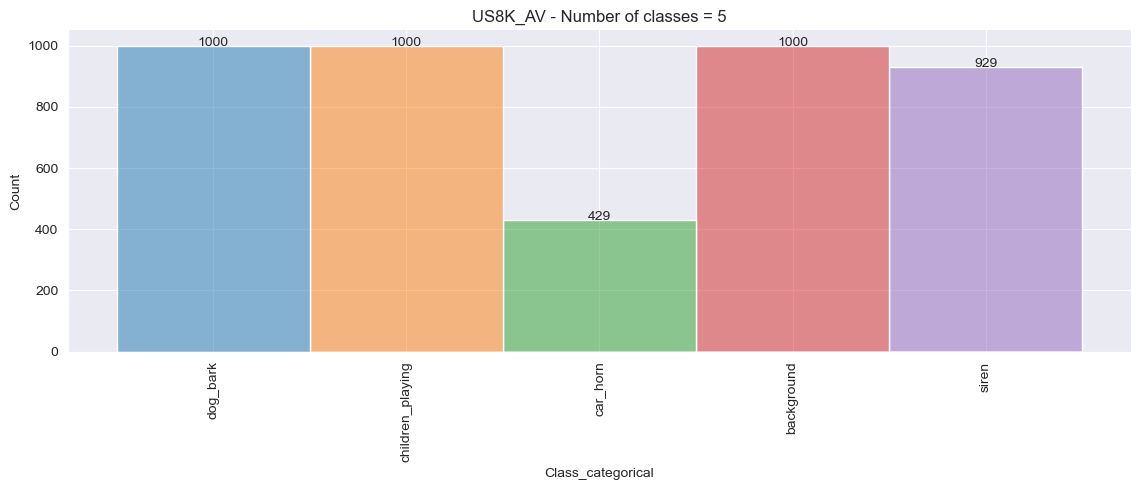

In [9]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = f'{nom_dataset} - Number of classes = ' + str(len(pd.Series(DB['Class_categorical']).unique()))
g = sns.displot(DB,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()

In [10]:
# Read the pkl file with the augmented features extracted

opc = 0
while str(opc) not in '123':
    print()
    print("1-) Features original")
    print("2-) Features augmented")
    print("3-) Features augmented and windowed (US8K is only windowed)")

    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0

if opc == 1:
    DB_from_pkl   = pd.read_pickle(os.path.join(path_models, pkl_features))
    model_surname = '_original'

if opc == 2:
    DB_from_pkl   = pd.read_pickle(os.path.join(path_models, pkl_aug_features))
    model_surname = '_augmented'

if opc == 3:
    DB_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_aug_wind_features))
    model_surname = '_windowed'


1-) Features original
2-) Features augmented
3-) Features augmented and windowed (US8K is only windowed)

Select the dataset: 3


In [11]:
DB_from_pkl.dtypes

Audio                  object
Class_categorical      object
Class_OHEV             object
Fold                   object
RMSE                  float64
                       ...   
TONNETZ_6             float64
TONNETZ_std_6         float64
TONNETZ_median_6      float64
TONNETZ_skew_6        float64
TONNETZ_kurtosis_6    float64
Length: 379, dtype: object

In [12]:
total_duration = 0
for audio in DB_from_pkl['Audio']:
    total_duration = total_duration + librosa.get_duration(y=audio)
print('Total duration of the dataset: ' , "{:0.4f} h".format(total_duration / 3600))

Total duration of the dataset:  8.4608 h


In [13]:
DB_from_pkl

,Audio,Class_categorical,Class_OHEV,Fold,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
0,"[-0.0034710653, -0.0050192624, -0.004654482, -0.0049833283, -0.0038681468, -0.0023575649, -0.00025486574, 0.00135406...",dog_bark,"[0, 0, 0, 1, 0]",5,...,0.025644,-0.046785,0.461191,-0.338882
1,"[-0.015428771, -0.0064468235, -0.002025701, -0.009768408, -0.020482529, -0.03246226, -0.046539657, -0.050950672, -0....",dog_bark,"[0, 0, 0, 1, 0]",5,...,0.026433,-0.030688,0.414979,-0.840459
2,"[-0.17165461, -0.1961453, -0.2095497, -0.116395764, 0.02499168, 0.15181583, 0.2456393, 0.24304995, 0.1697193, 0.0706...",dog_bark,"[0, 0, 0, 1, 0]",5,...,0.023640,-0.045384,0.629947,0.096665
3,"[-0.004147315, -0.014180049, -0.016550057, -0.017083425, -0.010863152, -0.0018686495, 0.006234308, 0.00725661, 0.005...",dog_bark,"[0, 0, 0, 1, 0]",5,...,0.024617,-0.025407,0.554764,-0.364067
4,"[-0.047271818, -0.08598116, -0.08329079, -0.15244874, -0.21367016, -0.26584676, -0.19677721, -0.17195633, -0.0841544...",dog_bark,"[0, 0, 0, 1, 0]",5,...,0.024934,-0.036388,0.770805,0.232676
...,...,...,...,...,...,...,...,...,...
30501,"[-0.024376377, -0.010054192, 0.0009410139, 0.005863713, -0.0005189497, -0.0021953415, 0.0013682423, -0.0043018945, -...",car_horn,"[0, 1, 0, 0, 0]",7,...,0.033488,-0.069738,0.175013,-0.974133
30502,"[0.0066777063, 0.008175363, 0.006157635, 0.0026387093, 0.00059039844, 0.0030925209, 0.0033645788, 0.0056151543, 0.00...",car_horn,"[0, 1, 0, 0, 0]",7,...,0.021007,-0.018432,-0.690702,-0.099409
30503,"[-0.0020232266, 0.001032982, 0.0023606261, 0.0017964527, 0.0009908059, -0.0011728329, -0.003362489, -0.0054453667, -...",car_horn,"[0, 1, 0, 0, 0]",7,...,0.021124,-0.016391,-0.028383,-1.071243
30504,"[-0.0015619812, 0.0005301243, 0.0032789772, 0.002725502, 0.0023546133, -0.0019822496, -0.002666029, -0.004454969, -0...",car_horn,"[0, 1, 0, 0, 0]",7,...,0.027106,-0.017513,-0.121982,-0.606880


In [14]:
print(type(DB_from_pkl['Fold'][0][0]))
print(type(DB_from_pkl['Class_OHEV'][0][0]))
print(type(DB_from_pkl['Class_OHEV'][0]))

<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


## Input split

In [15]:
# Separate 1 fold for validation and create a DB for the training / testing according to the datasets specification

DB_from_pkl_VAL = DB_from_pkl[DB_from_pkl['Fold'] == fold].copy()
DB_from_pkl_TRN = DB_from_pkl[DB_from_pkl['Fold'] != fold].copy()

In [16]:
print(len(DB_from_pkl_VAL))
print(len(DB_from_pkl_TRN))
print('Total: ', len(DB_from_pkl_VAL) + len(DB_from_pkl_TRN),'\n')

3010
27496
Total:  30506 



In [17]:
DB_from_pkl_VAL

,Audio,Class_categorical,Class_OHEV,Fold,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
231,"[6.402111e-05, 8.269498e-05, 5.2123058e-05, 7.1509836e-05, 3.3138364e-05, -6.1828905e-07, -8.950657e-05, -9.0291964e...",dog_bark,"[0, 0, 0, 1, 0]",1,...,0.019867,0.005833,0.230194,-0.774566
232,"[0.0005136457, 0.00041881658, 0.00034897702, 0.00021603762, 0.0002278979, 0.00011100468, 0.00010083006, 0.0001630317...",dog_bark,"[0, 0, 0, 1, 0]",1,...,0.018672,0.009202,0.529034,0.970660
233,"[-5.3512427e-05, 2.2222208e-05, 2.7161423e-05, 0.00017825539, 0.00032240857, 0.00041231932, 0.0005614782, 0.00053010...",dog_bark,"[0, 0, 0, 1, 0]",1,...,0.030452,-0.029692,0.291676,-0.927084
234,"[-9.721824e-05, -0.0002176053, -0.00031682133, -0.00042641407, -0.00044769727, -0.00042776082, -0.00044338158, -0.00...",dog_bark,"[0, 0, 0, 1, 0]",1,...,0.031560,-0.005922,-0.290679,-1.082696
235,"[0.00023775743, 0.00023206181, 0.00023593163, 0.00017538742, 0.00011133426, 0.00021567091, 0.00011633049, 8.274122e-...",dog_bark,"[0, 0, 0, 1, 0]",1,...,0.030058,0.002691,1.003930,1.476461
...,...,...,...,...,...,...,...,...,...
30333,"[-0.28165075, -0.39413118, -0.48126578, -0.54062337, -0.5627302, -0.5343282, -0.45225257, -0.33417547, -0.2137392, -...",background,"[1, 0, 0, 0, 0]",1,...,0.029579,0.014569,0.348922,-0.837185
30334,"[-0.74769396, -0.725761, -0.69069016, -0.64954436, -0.6015309, -0.53891814, -0.45484614, -0.35106456, -0.23903547, -...",background,"[1, 0, 0, 0, 0]",1,...,0.023069,0.014551,0.736680,0.175157
30335,"[-0.0073982505, 0.00089106406, 0.0060087573, -0.0026300459, -0.028010733, -0.059386022, -0.07765661, -0.06947853, -0...",background,"[1, 0, 0, 0, 0]",1,...,0.032426,0.030839,0.338930,-0.276007
30336,"[-0.19841202, -0.19705483, -0.20790972, -0.22519125, -0.2374166, -0.23624307, -0.2194226, -0.18771836, -0.14198783, ...",background,"[1, 0, 0, 0, 0]",1,...,0.053901,0.111005,-0.161630,-1.176320


In [18]:
DB_from_pkl_TRN

,Audio,Class_categorical,Class_OHEV,Fold,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
0,"[-0.0034710653, -0.0050192624, -0.004654482, -0.0049833283, -0.0038681468, -0.0023575649, -0.00025486574, 0.00135406...",dog_bark,"[0, 0, 0, 1, 0]",5,...,0.025644,-0.046785,0.461191,-0.338882
1,"[-0.015428771, -0.0064468235, -0.002025701, -0.009768408, -0.020482529, -0.03246226, -0.046539657, -0.050950672, -0....",dog_bark,"[0, 0, 0, 1, 0]",5,...,0.026433,-0.030688,0.414979,-0.840459
2,"[-0.17165461, -0.1961453, -0.2095497, -0.116395764, 0.02499168, 0.15181583, 0.2456393, 0.24304995, 0.1697193, 0.0706...",dog_bark,"[0, 0, 0, 1, 0]",5,...,0.023640,-0.045384,0.629947,0.096665
3,"[-0.004147315, -0.014180049, -0.016550057, -0.017083425, -0.010863152, -0.0018686495, 0.006234308, 0.00725661, 0.005...",dog_bark,"[0, 0, 0, 1, 0]",5,...,0.024617,-0.025407,0.554764,-0.364067
4,"[-0.047271818, -0.08598116, -0.08329079, -0.15244874, -0.21367016, -0.26584676, -0.19677721, -0.17195633, -0.0841544...",dog_bark,"[0, 0, 0, 1, 0]",5,...,0.024934,-0.036388,0.770805,0.232676
...,...,...,...,...,...,...,...,...,...
30501,"[-0.024376377, -0.010054192, 0.0009410139, 0.005863713, -0.0005189497, -0.0021953415, 0.0013682423, -0.0043018945, -...",car_horn,"[0, 1, 0, 0, 0]",7,...,0.033488,-0.069738,0.175013,-0.974133
30502,"[0.0066777063, 0.008175363, 0.006157635, 0.0026387093, 0.00059039844, 0.0030925209, 0.0033645788, 0.0056151543, 0.00...",car_horn,"[0, 1, 0, 0, 0]",7,...,0.021007,-0.018432,-0.690702,-0.099409
30503,"[-0.0020232266, 0.001032982, 0.0023606261, 0.0017964527, 0.0009908059, -0.0011728329, -0.003362489, -0.0054453667, -...",car_horn,"[0, 1, 0, 0, 0]",7,...,0.021124,-0.016391,-0.028383,-1.071243
30504,"[-0.0015619812, 0.0005301243, 0.0032789772, 0.002725502, 0.0023546133, -0.0019822496, -0.002666029, -0.004454969, -0...",car_horn,"[0, 1, 0, 0, 0]",7,...,0.027106,-0.017513,-0.121982,-0.606880


In [19]:
for i in DB_from_pkl_TRN.columns:
    print(i)

Audio
Class_categorical
Class_OHEV
Fold
RMSE
ZCR
CENTROIDS
BANDWIDTH
ROLLOFF
MEL_1
MEL_2
MEL_3
MEL_4
MEL_5
MEL_6
MEL_7
MEL_8
MEL_9
MEL_10
MEL_11
MEL_12
MEL_13
MEL_14
MEL_15
MEL_16
MEL_17
MEL_18
MEL_19
MEL_20
MEL_21
MEL_22
MEL_23
MEL_24
MEL_25
MEL_26
MEL_27
MEL_28
MEL_29
MEL_30
MEL_31
MEL_32
MEL_33
MEL_34
MEL_35
MEL_36
MEL_37
MEL_38
MEL_39
MEL_40
MEL_41
MEL_42
MEL_43
MEL_44
MEL_45
MEL_46
MEL_47
MEL_48
MEL_49
MEL_50
MEL_51
MEL_52
MEL_53
MEL_54
MEL_55
MEL_56
MEL_57
MEL_58
MEL_59
MEL_60
MEL_61
MEL_62
MEL_63
MEL_64
MEL_65
MEL_66
MEL_67
MEL_68
MEL_69
MEL_70
MEL_71
MEL_72
MEL_73
MEL_74
MEL_75
MEL_76
MEL_77
MEL_78
MEL_79
MEL_80
MEL_81
MEL_82
MEL_83
MEL_84
MEL_85
MEL_86
MEL_87
MEL_88
MEL_89
MEL_90
MEL_91
MEL_92
MEL_93
MEL_94
MEL_95
MEL_96
MEL_97
MEL_98
MEL_99
MEL_100
MEL_101
MEL_102
MEL_103
MEL_104
MEL_105
MEL_106
MEL_107
MEL_108
MEL_109
MEL_110
MEL_111
MEL_112
MEL_113
MEL_114
MEL_115
MEL_116
MEL_117
MEL_118
MEL_119
MEL_120
MEL_121
MEL_122
MEL_123
MEL_124
MEL_125
MEL_126
MEL_127
MEL_128
MFCC_1


In [20]:
# Separating data and labels

X      = DB_from_pkl_TRN.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
y      = np.array(DB_from_pkl_TRN.Class_categorical.to_list())
y_OHEV = np.array(DB_from_pkl_TRN.Class_OHEV.to_list())

In [21]:
# For the augmented dataset (only validation set)

X_val      = DB_from_pkl_VAL.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
y_val      = np.array(DB_from_pkl_VAL.Class_categorical.to_list())
y_OHEV_val = np.array(DB_from_pkl_VAL.Class_OHEV.to_list())

In [22]:
X

,RMSE,ZCR,CENTROIDS,BANDWIDTH,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
0,0.117183,0.129483,2069.471399,1734.789901,...,0.025644,-0.046785,0.461191,-0.338882
1,0.111724,0.131570,2098.418718,1743.608984,...,0.026433,-0.030688,0.414979,-0.840459
2,0.124646,0.131459,2096.616414,1747.412264,...,0.023640,-0.045384,0.629947,0.096665
3,0.110741,0.131658,2093.378630,1736.615179,...,0.024617,-0.025407,0.554764,-0.364067
4,0.125728,0.131836,2105.951159,1750.491381,...,0.024934,-0.036388,0.770805,0.232676
...,...,...,...,...,...,...,...,...,...
30501,0.012771,0.165439,2435.099768,2199.072455,...,0.033488,-0.069738,0.175013,-0.974133
30502,0.007954,0.148016,2363.629594,2317.859881,...,0.021007,-0.018432,-0.690702,-0.099409
30503,0.008383,0.154519,2389.715351,2316.671469,...,0.021124,-0.016391,-0.028383,-1.071243
30504,0.010459,0.173873,2467.091641,2211.234749,...,0.027106,-0.017513,-0.121982,-0.606880


In [23]:
X.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,27496.000000,27496.000000,27496.000000,27496.000000,...,27496.000000,27496.000000,27496.000000,27496.000000
mean,0.061757,0.111211,1946.880604,1941.677599,...,0.028865,-0.001712,0.117679,-0.267797
std,0.065669,0.075426,851.483462,537.300056,...,0.022403,0.035297,0.575863,1.089295
min,0.000145,0.000000,316.436258,478.380671,...,0.003497,-0.208415,-4.493470,-1.900563
25%,0.018061,0.064742,1369.743048,1545.724198,...,0.016744,-0.018674,-0.229967,-0.896474
50%,0.039756,0.094150,1792.585279,1896.864013,...,0.022840,-0.001946,0.106490,-0.506396
75%,0.082771,0.130216,2276.412570,2283.346224,...,0.033357,0.015029,0.450431,0.035052
max,0.701893,0.640292,6674.189171,4340.169312,...,0.257286,0.314713,3.473303,21.586886


In [24]:
y

array(['dog_bark', 'dog_bark', 'dog_bark', ..., 'car_horn', 'car_horn',
       'car_horn'], dtype='<U16')

In [25]:
y_OHEV

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0]])

In [26]:
X_statistics = pd.DataFrame({'mean': X.mean(), 'std': X.std(), 'min': X.min(), 'max': X.max()})

X_mean = X_statistics.values[:, 0]
X_std  = X_statistics.values[:, 1]
X_min  = X_statistics.values[:, 2]
X_max  = X_statistics.values[:, 3]

X_norm   =  (X.values - X_min) / (X_max - X_min)

X_normDB = X.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [27]:
RMSE_lst = []
for i in X_norm:
    RMSE_lst.append([i][0][0])
    
print(np.mean(RMSE_lst))

0.08779795319423672


In [28]:
X_normDB.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,27496.000000,27496.000000,27496.000000,27496.000000,...,27496.000000,27496.000000,27496.000000,27496.000000
mean,0.087798,0.173688,0.256450,0.378917,...,0.099956,0.395129,0.578798,0.069517
std,0.093580,0.117800,0.133928,0.139132,...,0.088276,0.067473,0.072283,0.046378
min,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000
25%,0.025530,0.101113,0.165673,0.276386,...,0.052194,0.362705,0.535161,0.042750
50%,0.056446,0.147041,0.232181,0.367313,...,0.076216,0.394680,0.577393,0.059358
75%,0.117743,0.203369,0.308281,0.467391,...,0.117657,0.427130,0.620565,0.082411
max,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000


In [29]:
X_standard = (X.values - X_mean) / X_std

X_standardDB = X.apply(lambda x: (x - x.mean()) / x.std())

In [30]:
RMSE_lst    = []
for i in X_standard:
    RMSE_lst.append([i][0][0])
    
print(np.mean(RMSE_lst))
print(np.std(RMSE_lst))

-8.269336465057902e-18
0.9999818153714614


In [31]:
X_standardDB.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,2.749600e+04,2.749600e+04,2.749600e+04,2.749600e+04,...,2.749600e+04,2.749600e+04,27496.000000,2.749600e+04
mean,-8.269336e-18,-5.788536e-17,1.488481e-16,-5.126989e-16,...,5.168335e-17,-2.144859e-17,0.000000,-1.033667e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000,1.000000e+00
min,-9.382175e-01,-1.474433e+00,-1.914828e+00,-2.723426e+00,...,-1.132315e+00,-5.856130e+00,-8.007378,-1.498921e+00
25%,-6.654041e-01,-6.160890e-01,-6.778024e-01,-7.369316e-01,...,-5.410548e-01,-4.805513e-01,-0.603696,-5.771418e-01
50%,-3.350271e-01,-2.262003e-01,-1.812077e-01,-8.340514e-02,...,-2.689247e-01,-6.645925e-03,-0.019429,-2.190398e-01
75%,3.199957e-01,2.519650e-01,3.870092e-01,6.358991e-01,...,2.005251e-01,4.742897e-01,0.577832,2.780233e-01
max,9.747881e+00,7.014547e+00,5.551850e+00,4.463971e+00,...,1.019584e+01,8.964689e+00,5.827128,2.006315e+01


In [32]:
X_norm.shape

(27496, 375)

In [33]:
X_standard.shape

(27496, 375)

In [34]:
y_OHEV.shape

(27496, 5)

In [35]:
len(X_norm)

27496

In [36]:
len(X_standard)

27496

In [37]:
X_val

,RMSE,ZCR,CENTROIDS,BANDWIDTH,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
231,0.020142,0.031516,1152.318462,1898.286145,...,0.019867,0.005833,0.230194,-0.774566
232,0.035680,0.036821,1237.588550,1949.387843,...,0.018672,0.009202,0.529034,0.970660
233,0.036087,0.045854,1422.395537,2117.020765,...,0.030452,-0.029692,0.291676,-0.927084
234,0.000778,0.040949,1877.232022,2785.436746,...,0.031560,-0.005922,-0.290679,-1.082696
235,0.076167,0.042880,1592.015997,2199.860601,...,0.030058,0.002691,1.003930,1.476461
...,...,...,...,...,...,...,...,...,...
30333,0.197044,0.070557,1087.442478,886.308473,...,0.029579,0.014569,0.348922,-0.837185
30334,0.197267,0.073486,1114.525841,940.949276,...,0.023069,0.014551,0.736680,0.175157
30335,0.196901,0.072865,1059.255494,857.858019,...,0.032426,0.030839,0.338930,-0.276007
30336,0.192756,0.066939,1058.530590,902.456226,...,0.053901,0.111005,-0.161630,-1.176320


In [38]:
X_val.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,3010.000000,3010.000000,3010.000000,3010.000000,...,3010.000000,3010.000000,3010.000000,3010.000000
mean,0.065873,0.113265,2027.375554,1988.820959,...,0.036852,-0.001223,0.118041,-0.305626
std,0.066159,0.081072,972.540017,531.004250,...,0.041177,0.044567,0.595448,1.049706
min,0.000083,0.005549,406.477247,695.196438,...,0.003733,-0.178653,-2.506518,-1.733951
25%,0.015080,0.060275,1318.434027,1621.312707,...,0.016706,-0.019668,-0.247503,-0.945905
50%,0.040219,0.101485,1894.516205,1917.492054,...,0.023036,-0.001336,0.113718,-0.550888
75%,0.097500,0.137557,2361.173895,2314.618141,...,0.036021,0.016743,0.504786,0.015309
max,0.469498,0.661577,6970.949555,3658.796731,...,0.227059,0.199019,2.530284,12.081950


In [39]:
y_OHEV_val

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [40]:
X_val_norm   =  (X_val.values - X_min) / (X_max - X_min)

In [41]:
X_val_standard = (X_val.values - X_mean) / X_std

In [42]:
X_val_norm.shape

(3010, 375)

In [43]:
X_val_standard.shape

(3010, 375)

In [44]:
y_OHEV_val.shape

(3010, 5)

In [45]:
len(y_OHEV_val)

3010

In [46]:
Counter_val = Counter(map(tuple, y_OHEV_val))
Counter_val

Counter({(0, 0, 0, 1, 0): 700,
         (1, 0, 0, 0, 0): 756,
         (0, 0, 1, 0, 0): 700,
         (0, 0, 0, 0, 1): 602,
         (0, 1, 0, 0, 0): 252})

In [47]:
# Group by the class and get one random sample of each class
k = DB_from_pkl.groupby('Class_categorical')['Class_OHEV'].apply(lambda s: s.sample(1))
print(k)

# Convert the pandas series into a dataframe
temp_k_df = k.reset_index()

# Delete the index from the grouppby result
del temp_k_df['level_1']

# Set the "Class" as the dataframe index
temp_k_df.set_index("Class_categorical", inplace=True)

# Convert the dataframe to a dictionary (Class: Class_encoder)
encoder_dict = temp_k_df["Class_OHEV"].to_dict()
encoder_dict

Class_categorical       
background         24455    [1, 0, 0, 0, 0]
car_horn           25513    [0, 1, 0, 0, 0]
children_playing   15386    [0, 0, 1, 0, 0]
dog_bark           14901    [0, 0, 0, 1, 0]
siren              14366    [0, 0, 0, 0, 1]
Name: Class_OHEV, dtype: object


{'background': array([1, 0, 0, 0, 0]),
 'car_horn': array([0, 1, 0, 0, 0]),
 'children_playing': array([0, 0, 1, 0, 0]),
 'dog_bark': array([0, 0, 0, 1, 0]),
 'siren': array([0, 0, 0, 0, 1])}

In [48]:
nom_classes = list(encoder_dict.keys())
nom_classes

['background', 'car_horn', 'children_playing', 'dog_bark', 'siren']

In [49]:
# Number of classes in the dataset

num_classes = len(encoder_dict.keys())
num_classes

5

## Neural networks

In [50]:
del DB_from_pkl_VAL, DB_from_pkl_TRN

In [51]:
# Separate 1 fold for validation and create a DB for the training / testing

opc = 0
while str(opc) not in '12':
    print()
    print("1-) Normalization")
    print("2-) Standardization")

    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0


    DB_from_pkl_VAL = DB_from_pkl[DB_from_pkl['Fold'] == fold].copy()
    DB_from_pkl_TRN = DB_from_pkl[DB_from_pkl['Fold'] != fold].copy()
    
    X      = DB_from_pkl_TRN.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
    y      = np.array(DB_from_pkl_TRN.Class_categorical.to_list())
    y_OHEV = np.array(DB_from_pkl_TRN.Class_OHEV.to_list())

    X_val      = DB_from_pkl_VAL.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
    y_val      = np.array(DB_from_pkl_VAL.Class_categorical.to_list())
    y_OHEV_val = np.array(DB_from_pkl_VAL.Class_OHEV.to_list())

    X_statistics = pd.DataFrame({'mean': X.mean(), 'std': X.std(), 'min': X.min(), 'max': X.max()})

    X_mean   = X_statistics.values[:, 0]
    X_std    = X_statistics.values[:, 1]
    X_min    = X_statistics.values[:, 2]
    X_max    = X_statistics.values[:, 3]
    
    # Normalization or standardization using values from the training set.
    if opc == 1:
        X_norm     = (X.values - X_min) / (X_max - X_min)
        X_val_norm = (X_val.values - X_min) / (X_max - X_min)
        norm_type  = '_norm'

    if opc == 2:
        X_norm     = (X.values - X_mean) / X_std
        X_val_norm = (X_val.values - X_mean) / X_std
        norm_type  = '_std'

    # Retrieve the indexes used for training the classifiers
    idx_trn = np.genfromtxt(os.path.join(path_models, '_idx_trn_' + nom_dataset + model_surname + '.csv'), delimiter=',', dtype = int)
    idx_tst = np.genfromtxt(os.path.join(path_models, '_idx_tst_' + nom_dataset + model_surname + '.csv'), delimiter=',', dtype = int)

    X_train      = X_norm[idx_trn]
    X_test       = X_norm[idx_tst]
    y_train      = y[idx_trn]
    y_test       = y[idx_tst]
    y_train_OHEV = y_OHEV[idx_trn]
    y_test_OHEV  = y_OHEV[idx_tst]


1-) Normalization
2-) Standardization

Select the dataset: 1


In [52]:
print("\n==================================")
print("Training set\n")

print(f'X_train.........: {np.shape(X_train)}')
print(f'y_train.........: {np.shape(y_train)}')
print(f'y_train_OHEV....: {np.shape(y_train_OHEV)}')

print("\n==================================")
print("Testing set\n")

print(f'X_test..........: {np.shape(X_test)}')
print(f'y_test..........: {np.shape(y_test)}')
print(f'y_test_OHEV.....: {np.shape(y_test_OHEV)}')

print("\n==================================")
print("Validation set\n")

print(f'X_val_norm......: {np.shape(X_val_norm)}')
print(f'y_val...........: {np.shape(y_val)}')
print(f'y_OHEV_val......: {np.shape(y_OHEV_val)}')


Training set

X_train.........: (24746, 375)
y_train.........: (24746,)
y_train_OHEV....: (24746, 5)

Testing set

X_test..........: (2750, 375)
y_test..........: (2750,)
y_test_OHEV.....: (2750, 5)

Validation set

X_val_norm......: (3010, 375)
y_val...........: (3010,)
y_OHEV_val......: (3010, 5)


In [53]:
# Simple confusion matrix

def simple_conf_matrix(y_true, y_pred, nom_classes, clf, acc):
    
    picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

    conf_matrix = metrics.confusion_matrix(y_true, y_pred)
    title = nom_dataset + model_surname + norm_type + ' - Classifier ' + clf + ' - Validation accuracy: '+ str("{:0.2f} %".format(acc*100))

    plt.figure(figsize = (10,10))
    sns.heatmap(conf_matrix, 
                annot=True, 
                fmt='g', 
                cmap=cmap_cm, 
                annot_kws={"size": 8}, 
                xticklabels=nom_classes, 
                yticklabels=nom_classes)
    plt.title(title, fontsize = 12)
    plt.savefig(os.path.join(path_pic, picture_name))
    plt.show()

In [54]:
# Plot the confusion matrix

def plot_confusion_matrix(cm, labels, title, cmap, normalize):

    if labels is not None:
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, fontsize=10, rotation=45)
        plt.yticks(tick_marks, labels, fontsize=10)
   
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize = 8)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize = 8)

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize=13)
    plt.colorbar(shrink=1)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)
    plt.tight_layout()

## Classifiers

- **Multilayer Perceptron** (MLP) is a type of Artificial Neural Network (ANN) used for supervised learning tasks, including classification, regression, and pattern recognition. It's a feedforward neural network that consists of multiple layers of nodes, including an input layer, one or more hidden layers, and an output layer. Each node, or neuron, in the network is connected to every node in the adjacent layers, and these connections have weights that are adjusted during training. MLP is capable of modeling complex relationships in data, making it suitable for tasks where the relationship between inputs and outputs is non-linear and intricate. It uses activation functions to introduce non-linearity into the network, allowing it to learn and approximate a wide variety of functions. One of the key advantages of MLP is its ability to learn from large and high-dimensional datasets. However, this advantage comes with the cost of increased complexity, making it more challenging to train and requiring careful tuning of hyperparameters like the number of hidden layers, the number of neurons in each layer, and the learning rate. Additionally, MLP is sensitive to feature scaling, and preprocessing techniques such as normalization are often applied to the input data to improve performance.
***
- **Convolutional Neural Networks** (CNNs) are a class of deep learning algorithms specifically designed for processing grid-like data, such as images and videos. CNNs are highly effective in tasks related to computer vision, including image recognition, object detection, and image segmentation. They are characterized by their ability to automatically and adaptively learn spatial hierarchies of features from input data. CNNs consist of multiple layers, including convolutional layers, pooling layers, and fully connected layers. The convolutional layers apply convolution operations to the input data, enabling the network to automatically learn patterns and features from images, such as edges, textures, and more complex structures. The pooling layers downsample the spatial dimensions of the data, reducing computational complexity while retaining important features. Fully connected layers at the end of the network process the learned features and make predictions based on them. One of the significant advantages of CNNs is their ability to capture local patterns and spatial hierarchies of features. By using shared weights and biases in the convolutional layers, CNNs are capable of learning translation-invariant features, making them well-suited for tasks where the spatial arrangement of features in the input data is essential. Additionally, CNNs can automatically learn relevant features from raw pixel values, eliminating the need for manual feature extraction.

In [55]:
# Number of the dimensions of the input layer

n_dim       = X_norm.shape[1]
n_dim

375

In [56]:
# For OHEV

Counter_test = Counter(map(tuple, y_test_OHEV))
Counter_train = Counter(map(tuple, y_train_OHEV))

In [57]:
print('Training samples')
Counter_train

Training samples


Counter({(0, 0, 0, 0, 1): 5311,
         (0, 0, 0, 1, 0): 5670,
         (0, 1, 0, 0, 0): 2476,
         (0, 0, 1, 0, 0): 5670,
         (1, 0, 0, 0, 0): 5619})

In [58]:
print('Testing samples')
Counter_test

Testing samples


Counter({(1, 0, 0, 0, 0): 625,
         (0, 0, 0, 1, 0): 630,
         (0, 1, 0, 0, 0): 275,
         (0, 0, 1, 0, 0): 630,
         (0, 0, 0, 0, 1): 590})

### ANN - Grid search for best parameters

In [59]:
#def create_model():
    
#    model = Sequential()
#    model.add(Dense(n_dim, activation='relu', input_shape=(n_dim,)))
#    model.add(Dropout(0.2))
#    model.add(Dense(375, activation='relu'))
#    model.add(Dropout(0.2))
#    model.add(Dense(num_classes, activation='softmax'))

#    model.compile(loss='MeanSquaredError', optimizer='adam', metrics=['accuracy'])
    
#    return model

In [60]:
# Grid search for the batch size and epochs

#model = KerasClassifier(build_fn = create_model, verbose=0)

# define the grid search parameters
#batch_size  = [20, 40, 80, 160]
#epochs      = [100, 250, 500]
#param_grid  = dict(batch_size = batch_size, epochs = epochs)
#grid        = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs=-1, cv=3)
#grid_result = grid.fit(X_train, y_train)

# summarize results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means  = grid_result.cv_results_['mean_test_score']
#stds   = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']

#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

In [61]:
#del model
#K.clear_session()

In [62]:
#from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, Adamax, Nadam

In [63]:
# Grid search for hidden layers, neurons, activation, dropout_rate and optimizer

#def tune_model(hidden_layers, neurons, activation, dropout_rate, optimizer='adam', learning_rate=0.001, momentum=0.9, nesterov=False, rho=0.9, epsilon=1e-07, centered=False, 
#                 initial_accumulator_value=0.1, amsgrad=False, beta_1=0.9, beta_2=0.999):
    
#    model = Sequential()
#    model.add(Dense(units = neurons, activation = activation, input_shape = (n_dim,)))

#    for i in range(hidden_layers):
#        model.add(Dense(units = neurons, activation = activation))
#        model.add(Dropout(dropout_rate))

#    model.add(Dense(units = num_classes, activation = 'sigmoid'))
    
#    if optimizer == 'sgd':
#        optimizer = SGD(lr=learning_rate, momentum=momentum, nesterov=nesterov)
#    elif optimizer == 'rmsprop':
#        optimizer = RMSprop(lr=learning_rate, rho=rho, epsilon=epsilon, centered=centered)
#    elif optimizer == 'adam':
#        optimizer = Adam(lr=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon, amsgrad=amsgrad)
#    elif optimizer == 'adagrad':
#        optimizer = Adagrad(lr=learning_rate, initial_accumulator_value=initial_accumulator_value, epsilon=epsilon)
#    elif optimizer == 'adadelta':
#        optimizer = Adadelta(lr=learning_rate, rho=rho, epsilon=epsilon)
#    elif optimizer == 'adamax':
#        optimizer = Adamax(lr=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
#    elif optimizer == 'nadam':
#        optimizer = Nadam(lr=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
        
#    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
#    return model

In [64]:
#hidden_layers  = [1, 2, 3]
#neurons        = [375, 500, 750, 1000]
#activation     = ['relu', 'sigmoid']
#dropout_rate   = [0.1, 0.2, 0.3]
#optimizer      = ['sgd', 'rmsprop', 'adam', 'adagrad', 'adadelta', 'adamax', 'nadam']

#learning_rate  = [0.001, 0.01, 0.1]

#param_grid     = dict(hidden_layers = hidden_layers, 
#                      neurons       = neurons, 
#                      activation    = activation,
#                     dropout_rate  = dropout_rate,
#                      optimizer     = optimizer,
#                      learning_rate = learning_rate)

In [65]:
#tf.autograph.set_verbosity(0)
#tf.config.set_visible_devices([], 'GPU')

In [66]:
#model = KerasClassifier(build_fn = tune_model, verbose=1, epochs = 100, batch_size = 80)
#grid  = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3)

In [67]:
#grid_result = grid.fit(X_train, y_train)

In [68]:
## summarize results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means  = grid_result.cv_results_['mean_test_score']
#stds   = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']

#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

In [70]:
# ANN (Artificial Neural Network) or MLP (Multi layer Perceptron) using Tensorflow

initializer = keras.initializers.Ones()

def build_ANN_model(model_name: str, neurons: int):
    
    #optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=False)
    optimizer = keras.optimizers.Adam(learning_rate=0.0001, 
                                      beta_1=0.5, 
                                      beta_2=0.999, 
                                      epsilon=1e-07, 
                                      amsgrad=True)
    
    
    model = Sequential(name = model_name)
    model.add(Dense(neurons, activation = 'relu', input_shape = (neurons,), name = 'Input'))

    # First hiden layer with 375 neurons
    model.add(Dense(neurons, activation ='relu', name = 'Hiden_1'))

    # Dropout de 20%
    model.add(Dropout(0.2, name = 'Dropout_1'))
    
    # Second hiden layer with 750 neurons (Kolmogorov's theorem)
    model.add(Dense(n_dim * 2, activation ='relu', name = 'Hiden_2'))

    # Dropout de 20%
    model.add(Dropout(0.2, name = 'Dropout_2'))

    # Final classification layer, with 1 neuron for each output class. Softmax divides the probability of each class.
    model.add(Dense(num_classes, activation='softmax', name = 'Output'))

    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

    return model

In [71]:
es = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=150, verbose=1, mode='auto', restore_best_weights=True)

if not os.path.exists(path_models):
    os.makedirs(path_models)

filepath       = os.path.join(path_models, 'Model_ANN_weights_0_best' + norm_type + model_surname + '.hdf5')
checkpoint     = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,es]

In [72]:
model_ANN = build_ANN_model('ANN_1', neurons = n_dim)
model_ANN.summary()

Model: "ANN_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 375)               141000    
_________________________________________________________________
Hiden_1 (Dense)              (None, 375)               141000    
_________________________________________________________________
Dropout_1 (Dropout)          (None, 375)               0         
_________________________________________________________________
Hiden_2 (Dense)              (None, 750)               282000    
_________________________________________________________________
Dropout_2 (Dropout)          (None, 750)               0         
_________________________________________________________________
Output (Dense)               (None, 5)                 3755      
Total params: 567,755
Trainable params: 567,755
Non-trainable params: 0
_______________________________________________________

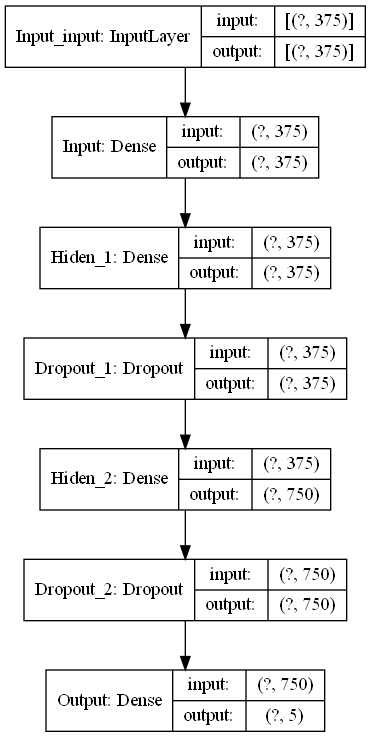

In [73]:
tf.keras.utils.plot_model(model_ANN, to_file= os.path.join(path_models, 'Model_ANN' + norm_type + model_surname + '.png'), show_shapes=True)

### Understanding the column "Param":

- 141,000 parameters is the result of 375 neurons with 375 features + 375  bias values
- 141,000 parameters is the result of 375 neurons with 375 features + 375  bias values
- 282,000 parameters is the result of 750 neurons with 375 features + 750 bias values
- 3,755   parameters is the result of 750 neurons with 5 features  + 5  bias values

In [74]:
print("\n==================================")
print("Training set\n")

print(f'X_train.........: {np.shape(X_train)}')
print(f'y_train.........: {np.shape(y_train)}')
print(f'y_train_OHEV....: {np.shape(y_train_OHEV)}')

print("\n==================================")
print("Testing set\n")

print(f'X_test..........: {np.shape(X_test)}')
print(f'y_test..........: {np.shape(y_test)}')
print(f'y_test_OHEV.....: {np.shape(y_test_OHEV)}')

print("\n==================================")
print("Validation set\n")

print(f'X_val_norm......: {np.shape(X_val_norm)}')
print(f'y_val...........: {np.shape(y_val)}')
print(f'y_OHEV_val......: {np.shape(y_OHEV_val)}')


Training set

X_train.........: (24746, 375)
y_train.........: (24746,)
y_train_OHEV....: (24746, 5)

Testing set

X_test..........: (2750, 375)
y_test..........: (2750,)
y_test_OHEV.....: (2750, 5)

Validation set

X_val_norm......: (3010, 375)
y_val...........: (3010,)
y_OHEV_val......: (3010, 5)


In [75]:
y_train_OHEV

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       ...,
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0]])

In [76]:
batch_size_ANN = 32
epochs_ANN     = 350

history_ANN    = model_ANN.fit(X_train, y_train_OHEV,
                               batch_size      = batch_size_ANN,
                               epochs          = epochs_ANN,
                               verbose         = 1,
                               validation_data = (X_test, y_test_OHEV),
                               callbacks       = callbacks_list)

Epoch 1/350
760/774 [============================>.] - ETA: 0s - loss: 0.9132 - accuracy: 0.6547
Epoch 00001: val_accuracy improved from -inf to 0.76655, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_ANN_weights_0_best_norm_windowed.hdf5
774/774 [==============================] - 2s 2ms/step - loss: 0.9088 - accuracy: 0.6566 - val_loss: 0.6312 - val_accuracy: 0.7665
Epoch 2/350
772/774 [============================>.] - ETA: 0s - loss: 0.5939 - accuracy: 0.7843
Epoch 00002: val_accuracy improved from 0.76655 to 0.79491, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_ANN_weights_0_best_norm_windowed.hdf5
774/774 [==============================] - 1s 2ms/step - loss: 0.5938 - accuracy: 0.7844 - val_loss: 0.5518 - val_accuracy: 0.7949
Epoch 3/350
756/774 [============================>.] - ETA: 0s - loss: 0.5136 - accuracy: 0.8139
Epoch 00003: val_accuracy improved from 0.79491 

Epoch 23/350
764/774 [============================>.] - ETA: 0s - loss: 0.1668 - accuracy: 0.9408
Epoch 00023: val_accuracy improved from 0.90764 to 0.92509, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_ANN_weights_0_best_norm_windowed.hdf5
774/774 [==============================] - 1s 2ms/step - loss: 0.1667 - accuracy: 0.9408 - val_loss: 0.2112 - val_accuracy: 0.9251
Epoch 24/350
759/774 [============================>.] - ETA: 0s - loss: 0.1593 - accuracy: 0.9442
Epoch 00024: val_accuracy improved from 0.92509 to 0.92836, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_ANN_weights_0_best_norm_windowed.hdf5
774/774 [==============================] - 1s 2ms/step - loss: 0.1581 - accuracy: 0.9447 - val_loss: 0.2157 - val_accuracy: 0.9284
Epoch 25/350
766/774 [============================>.] - ETA: 0s - loss: 0.1546 - accuracy: 0.9470
Epoch 00025: val_accuracy improved from 0.

761/774 [============================>.] - ETA: 0s - loss: 0.0635 - accuracy: 0.9785
Epoch 00047: val_accuracy improved from 0.95164 to 0.95636, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_ANN_weights_0_best_norm_windowed.hdf5
774/774 [==============================] - 1s 2ms/step - loss: 0.0632 - accuracy: 0.9786 - val_loss: 0.1462 - val_accuracy: 0.9564
Epoch 48/350
758/774 [============================>.] - ETA: 0s - loss: 0.0625 - accuracy: 0.9796
Epoch 00048: val_accuracy did not improve from 0.95636
774/774 [==============================] - 1s 2ms/step - loss: 0.0625 - accuracy: 0.9796 - val_loss: 0.1695 - val_accuracy: 0.9433
Epoch 49/350
771/774 [============================>.] - ETA: 0s - loss: 0.0618 - accuracy: 0.9789
Epoch 00049: val_accuracy did not improve from 0.95636
774/774 [==============================] - 1s 2ms/step - loss: 0.0618 - accuracy: 0.9789 - val_loss: 0.1411 - val_accuracy: 0.9516
Epoch 50/350
77

769/774 [============================>.] - ETA: 0s - loss: 0.0277 - accuracy: 0.9910
Epoch 00073: val_accuracy did not improve from 0.96218
774/774 [==============================] - 1s 2ms/step - loss: 0.0277 - accuracy: 0.9910 - val_loss: 0.1558 - val_accuracy: 0.9509
Epoch 74/350
769/774 [============================>.] - ETA: 0s - loss: 0.0253 - accuracy: 0.9922
Epoch 00074: val_accuracy did not improve from 0.96218
774/774 [==============================] - 1s 2ms/step - loss: 0.0252 - accuracy: 0.9923 - val_loss: 0.1275 - val_accuracy: 0.9611
Epoch 75/350
752/774 [============================>.] - ETA: 0s - loss: 0.0259 - accuracy: 0.9916
Epoch 00075: val_accuracy did not improve from 0.96218
774/774 [==============================] - 1s 2ms/step - loss: 0.0258 - accuracy: 0.9917 - val_loss: 0.1227 - val_accuracy: 0.9585
Epoch 76/350
766/774 [============================>.] - ETA: 0s - loss: 0.0230 - accuracy: 0.9929
Epoch 00076: val_accuracy improved from 0.96218 to 0.96545, sav

Epoch 101/350
759/774 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9949
Epoch 00101: val_accuracy did not improve from 0.96691
774/774 [==============================] - 1s 2ms/step - loss: 0.0149 - accuracy: 0.9949 - val_loss: 0.1460 - val_accuracy: 0.9596
Epoch 102/350
749/774 [============================>.] - ETA: 0s - loss: 0.0150 - accuracy: 0.9955
Epoch 00102: val_accuracy did not improve from 0.96691
774/774 [==============================] - 1s 2ms/step - loss: 0.0151 - accuracy: 0.9954 - val_loss: 0.1382 - val_accuracy: 0.9596
Epoch 103/350
761/774 [============================>.] - ETA: 0s - loss: 0.0123 - accuracy: 0.9965
Epoch 00103: val_accuracy did not improve from 0.96691
774/774 [==============================] - 1s 2ms/step - loss: 0.0124 - accuracy: 0.9965 - val_loss: 0.1372 - val_accuracy: 0.9644
Epoch 104/350
755/774 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9955
Epoch 00104: val_accuracy did not improve from

Epoch 128/350
751/774 [============================>.] - ETA: 0s - loss: 0.0122 - accuracy: 0.9964
Epoch 00128: val_accuracy did not improve from 0.96945
774/774 [==============================] - 1s 2ms/step - loss: 0.0121 - accuracy: 0.9964 - val_loss: 0.1318 - val_accuracy: 0.9676
Epoch 129/350
758/774 [============================>.] - ETA: 0s - loss: 0.0060 - accuracy: 0.9985
Epoch 00129: val_accuracy did not improve from 0.96945
774/774 [==============================] - 1s 2ms/step - loss: 0.0060 - accuracy: 0.9985 - val_loss: 0.1486 - val_accuracy: 0.9633
Epoch 130/350
757/774 [============================>.] - ETA: 0s - loss: 0.0062 - accuracy: 0.9984
Epoch 00130: val_accuracy did not improve from 0.96945
774/774 [==============================] - 1s 2ms/step - loss: 0.0062 - accuracy: 0.9984 - val_loss: 0.1539 - val_accuracy: 0.9636
Epoch 131/350
753/774 [============================>.] - ETA: 0s - loss: 0.0080 - accuracy: 0.9978
Epoch 00131: val_accuracy did not improve from

756/774 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9987
Epoch 00156: val_accuracy did not improve from 0.97055
774/774 [==============================] - 1s 2ms/step - loss: 0.0046 - accuracy: 0.9987 - val_loss: 0.1465 - val_accuracy: 0.9658
Epoch 157/350
753/774 [============================>.] - ETA: 0s - loss: 0.0044 - accuracy: 0.9989
Epoch 00157: val_accuracy did not improve from 0.97055
774/774 [==============================] - 1s 2ms/step - loss: 0.0046 - accuracy: 0.9989 - val_loss: 0.1649 - val_accuracy: 0.9636
Epoch 158/350
756/774 [============================>.] - ETA: 0s - loss: 0.0044 - accuracy: 0.9988
Epoch 00158: val_accuracy did not improve from 0.97055
774/774 [==============================] - 1s 2ms/step - loss: 0.0044 - accuracy: 0.9989 - val_loss: 0.1986 - val_accuracy: 0.9480
Epoch 159/350
756/774 [============================>.] - ETA: 0s - loss: 0.0060 - accuracy: 0.9984
Epoch 00159: val_accuracy did not improve from 0.97055
774/7

761/774 [============================>.] - ETA: 0s - loss: 0.0062 - accuracy: 0.9979
Epoch 00184: val_accuracy did not improve from 0.97091
774/774 [==============================] - 1s 2ms/step - loss: 0.0062 - accuracy: 0.9979 - val_loss: 0.1608 - val_accuracy: 0.9673
Epoch 185/350
762/774 [============================>.] - ETA: 0s - loss: 0.0033 - accuracy: 0.9991
Epoch 00185: val_accuracy did not improve from 0.97091
774/774 [==============================] - 1s 2ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.1439 - val_accuracy: 0.9698
Epoch 186/350
772/774 [============================>.] - ETA: 0s - loss: 0.0018 - accuracy: 0.9998
Epoch 00186: val_accuracy did not improve from 0.97091
774/774 [==============================] - 1s 2ms/step - loss: 0.0018 - accuracy: 0.9998 - val_loss: 0.1309 - val_accuracy: 0.9680
Epoch 187/350
763/774 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000
Epoch 00187: val_accuracy did not improve from 0.97091
774/7

Epoch 213/350
749/774 [============================>.] - ETA: 0s - loss: 0.0021 - accuracy: 0.9996
Epoch 00213: val_accuracy did not improve from 0.97091
774/774 [==============================] - 1s 2ms/step - loss: 0.0022 - accuracy: 0.9996 - val_loss: 0.1462 - val_accuracy: 0.9665
Epoch 214/350
756/774 [============================>.] - ETA: 0s - loss: 0.0023 - accuracy: 0.9995
Epoch 00214: val_accuracy did not improve from 0.97091
774/774 [==============================] - 1s 2ms/step - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.1386 - val_accuracy: 0.9662
Epoch 215/350
751/774 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 0.9999
Epoch 00215: val_accuracy did not improve from 0.97091
774/774 [==============================] - 1s 2ms/step - loss: 0.0012 - accuracy: 0.9999 - val_loss: 0.1411 - val_accuracy: 0.9691
Epoch 216/350
769/774 [============================>.] - ETA: 0s - loss: 0.0065 - accuracy: 0.9980
Epoch 00216: val_accuracy did not improve from

743/774 [===========================>..] - ETA: 0s - loss: 0.0011 - accuracy: 0.9998
Epoch 00241: val_accuracy did not improve from 0.97127
774/774 [==============================] - 1s 2ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.1522 - val_accuracy: 0.9665
Epoch 242/350
752/774 [============================>.] - ETA: 0s - loss: 0.0084 - accuracy: 0.9974
Epoch 00242: val_accuracy did not improve from 0.97127
774/774 [==============================] - 1s 2ms/step - loss: 0.0084 - accuracy: 0.9975 - val_loss: 0.1643 - val_accuracy: 0.9633
Epoch 243/350
772/774 [============================>.] - ETA: 0s - loss: 0.0036 - accuracy: 0.9990
Epoch 00243: val_accuracy did not improve from 0.97127
774/774 [==============================] - 1s 2ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.1396 - val_accuracy: 0.9676
Epoch 244/350
773/774 [============================>.] - ETA: 0s - loss: 7.8444e-04 - accuracy: 1.0000
Epoch 00244: val_accuracy did not improve from 0.97127
7

Epoch 270/350
752/774 [============================>.] - ETA: 0s - loss: 0.0031 - accuracy: 0.9990
Epoch 00270: val_accuracy did not improve from 0.97127
774/774 [==============================] - 1s 2ms/step - loss: 0.0031 - accuracy: 0.9990 - val_loss: 0.1497 - val_accuracy: 0.9676
Epoch 271/350
762/774 [============================>.] - ETA: 0s - loss: 0.0101 - accuracy: 0.9970
Epoch 00271: val_accuracy did not improve from 0.97127
774/774 [==============================] - 1s 2ms/step - loss: 0.0099 - accuracy: 0.9970 - val_loss: 0.1450 - val_accuracy: 0.9702
Epoch 272/350
765/774 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 0.9996
Epoch 00272: val_accuracy did not improve from 0.97127
774/774 [==============================] - 1s 2ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.1571 - val_accuracy: 0.9684
Epoch 273/350
751/774 [============================>.] - ETA: 0s - loss: 0.0025 - accuracy: 0.9992
Epoch 00273: val_accuracy did not improve from

Epoch 298/350
752/774 [============================>.] - ETA: 0s - loss: 3.8158e-04 - accuracy: 1.0000
Epoch 00298: val_accuracy did not improve from 0.97236
774/774 [==============================] - 1s 2ms/step - loss: 3.8247e-04 - accuracy: 1.0000 - val_loss: 0.1492 - val_accuracy: 0.9673
Epoch 299/350
748/774 [===========================>..] - ETA: 0s - loss: 3.8697e-04 - accuracy: 1.0000
Epoch 00299: val_accuracy did not improve from 0.97236
774/774 [==============================] - 1s 2ms/step - loss: 3.9352e-04 - accuracy: 1.0000 - val_loss: 0.1500 - val_accuracy: 0.9684
Epoch 300/350
767/774 [============================>.] - ETA: 0s - loss: 0.0018 - accuracy: 0.9994
Epoch 00300: val_accuracy did not improve from 0.97236
774/774 [==============================] - 1s 2ms/step - loss: 0.0018 - accuracy: 0.9994 - val_loss: 0.1544 - val_accuracy: 0.9680
Epoch 301/350
773/774 [============================>.] - ETA: 0s - loss: 7.1833e-04 - accuracy: 0.9998
Epoch 00301: val_accuracy 

769/774 [============================>.] - ETA: 0s - loss: 4.4729e-04 - accuracy: 1.0000
Epoch 00326: val_accuracy did not improve from 0.97236
774/774 [==============================] - 1s 2ms/step - loss: 4.4563e-04 - accuracy: 1.0000 - val_loss: 0.1491 - val_accuracy: 0.9691
Epoch 327/350
765/774 [============================>.] - ETA: 0s - loss: 3.0776e-04 - accuracy: 1.0000
Epoch 00327: val_accuracy did not improve from 0.97236
774/774 [==============================] - 1s 2ms/step - loss: 3.0634e-04 - accuracy: 1.0000 - val_loss: 0.1521 - val_accuracy: 0.9676
Epoch 328/350
761/774 [============================>.] - ETA: 0s - loss: 4.3650e-04 - accuracy: 1.0000
Epoch 00328: val_accuracy did not improve from 0.97236
774/774 [==============================] - 1s 2ms/step - loss: 4.3412e-04 - accuracy: 1.0000 - val_loss: 0.1461 - val_accuracy: 0.9702
Epoch 329/350
761/774 [============================>.] - ETA: 0s - loss: 3.2983e-04 - accuracy: 1.0000
Epoch 00329: val_accuracy did no

In [77]:
score_ANN = model_ANN.evaluate(X_test, y_test_OHEV, verbose=0, batch_size = 32)
print('Test loss:', score_ANN[0])
print('Test accuracy:', score_ANN[1])

Test loss: 0.1449861079454422
Test accuracy: 0.9701818227767944


In [78]:
score_ANN[1]

0.9701818227767944

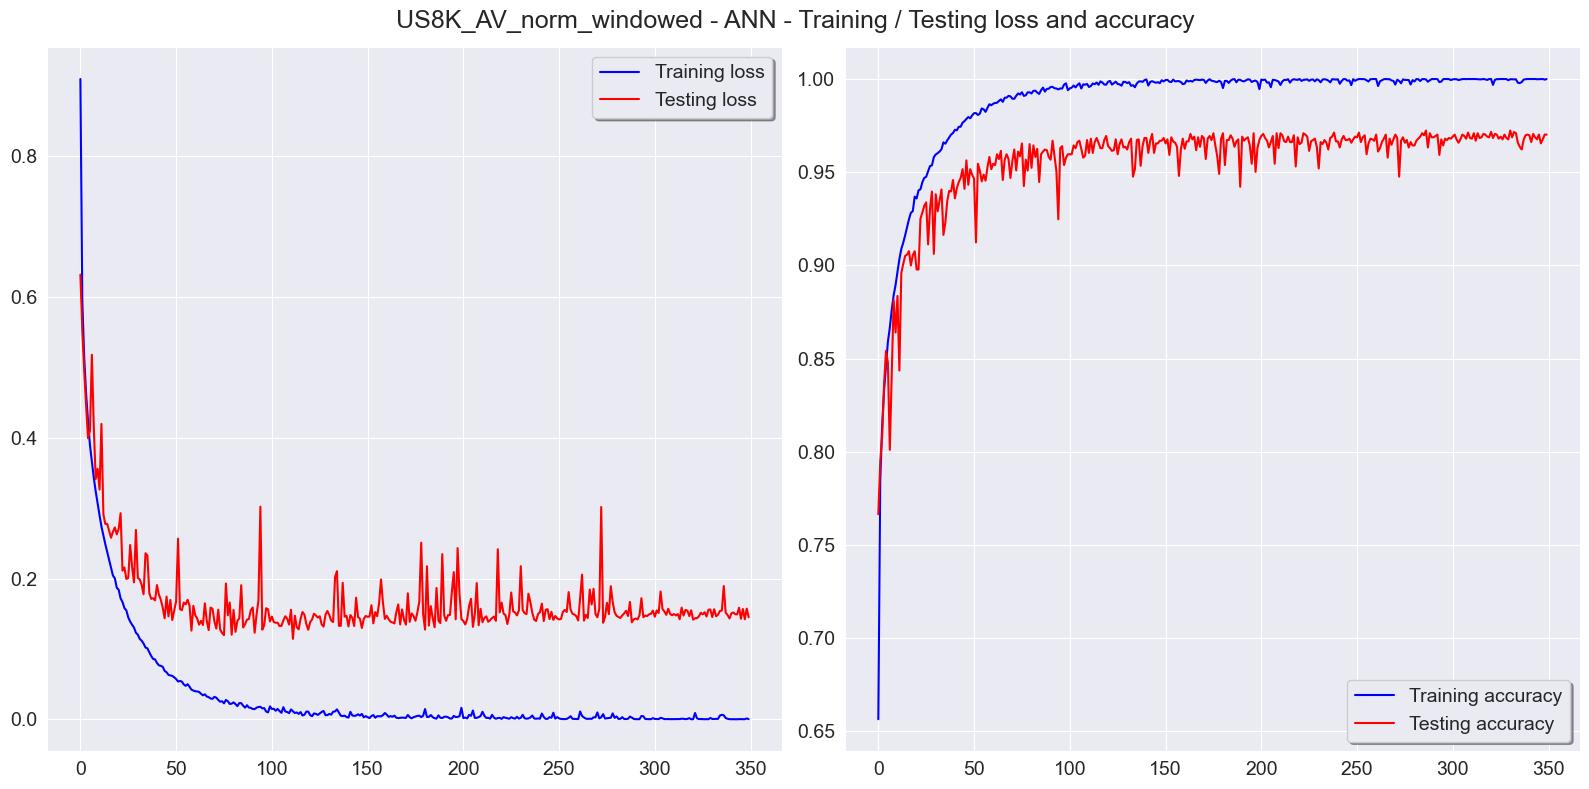

In [79]:
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

fig, ax = plt.subplots(1,2, figsize=(16,8))
fig.suptitle(nom_dataset + norm_type + model_surname + ' - ANN - Training / Testing loss and accuracy', fontsize = 18)
ax[0].plot(history_ANN.history['loss'], color='b', label="Training loss")
ax[0].plot(history_ANN.history['val_loss'], color='r', label="Testing loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True, fontsize = 14)
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=14)

ax[1].plot(history_ANN.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history_ANN.history['val_accuracy'], color='r',label="Testing accuracy")
legend = ax[1].legend(loc='best', shadow=True, fontsize = 14)
ax[1].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='y', labelsize=14)

fig.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

In [80]:
# save model and architecture to single file (not the best model though)

#model_ANN.save(path_models + "Model_ANN.h5")
#print("Saved model to disk")

In [81]:
y_pred_ANN = np.argmax(model_ANN.predict(X_val_norm),axis=1)
y_pred_ANN

array([3, 3, 3, ..., 0, 0, 0], dtype=int64)

In [82]:
y_test_enc = np.argmax(y_OHEV_val, axis=1)
y_test_enc

array([3, 3, 3, ..., 0, 0, 0], dtype=int64)

In [83]:
metrics_set_ANN = classification_report(y_test_enc, y_pred_ANN, target_names=nom_classes)
print(metrics_set_ANN)

                  precision    recall  f1-score   support

      background       0.86      0.82      0.84       756
        car_horn       0.86      0.94      0.90       252
children_playing       0.77      0.81      0.79       700
        dog_bark       0.77      0.85      0.81       700
           siren       0.88      0.75      0.81       602

        accuracy                           0.82      3010
       macro avg       0.83      0.83      0.83      3010
    weighted avg       0.82      0.82      0.82      3010



In [84]:
# Load the model with the highest accuracy

model_ANN_saved = load_model(os.path.join(path_models, 'Model_ANN_weights_0_best' + norm_type + model_surname + '.hdf5'))
model_ANN_saved.summary()

Model: "ANN_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 375)               141000    
_________________________________________________________________
Hiden_1 (Dense)              (None, 375)               141000    
_________________________________________________________________
Dropout_1 (Dropout)          (None, 375)               0         
_________________________________________________________________
Hiden_2 (Dense)              (None, 750)               282000    
_________________________________________________________________
Dropout_2 (Dropout)          (None, 750)               0         
_________________________________________________________________
Output (Dense)               (None, 5)                 3755      
Total params: 567,755
Trainable params: 567,755
Non-trainable params: 0
_______________________________________________________

In [85]:
score_ANN_saved = model_ANN_saved.evaluate(X_val_norm, y_OHEV_val, verbose=1, batch_size = 32)
print('Test loss:', score_ANN_saved[0])
print('Test accuracy:', score_ANN_saved[1])

95/95 [==============================] - 0s 3ms/step - loss: 2.5394 - accuracy: 0.8219
Test loss: 2.539357900619507
Test accuracy: 0.8219268918037415


In [86]:
y_pred_ANN_saved = np.argmax(model_ANN_saved.predict(X_val_norm),axis=1)
y_pred_ANN_saved

array([3, 3, 3, ..., 0, 0, 0], dtype=int64)

In [87]:
metrics_set_ANN_saved = classification_report(y_test_enc, y_pred_ANN_saved, target_names=nom_classes)
print(metrics_set_ANN_saved)

                  precision    recall  f1-score   support

      background       0.88      0.80      0.84       756
        car_horn       0.85      0.94      0.89       252
children_playing       0.75      0.85      0.80       700
        dog_bark       0.79      0.84      0.81       700
           siren       0.89      0.74      0.81       602

        accuracy                           0.82      3010
       macro avg       0.83      0.84      0.83      3010
    weighted avg       0.83      0.82      0.82      3010



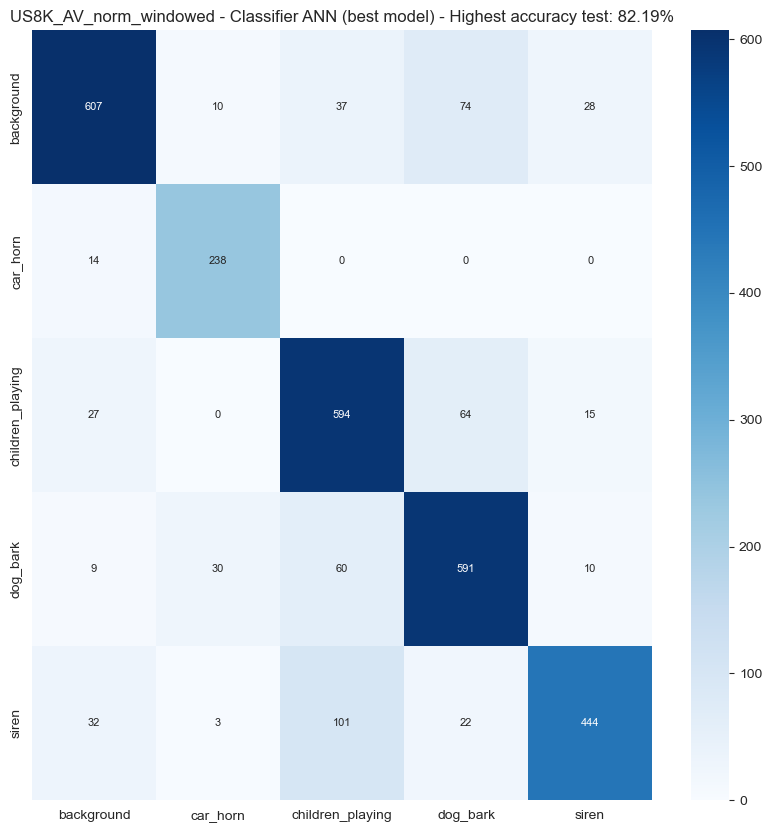

In [88]:
# Simple confusion matrix

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

conf_matrix = metrics.confusion_matrix(y_test_enc, y_pred_ANN_saved)
title = nom_dataset + norm_type + model_surname + ' - Classifier ANN (best model) - Highest accuracy test: '+ str("{:0.2f}%".format(score_ANN_saved[1]*100))

plt.figure(figsize = (10,10))
sns.heatmap(conf_matrix, 
            annot=True, 
            fmt='g', 
            cmap=cmap_cm, 
            annot_kws={"size": 8}, 
            xticklabels=nom_classes, 
            yticklabels=nom_classes)
plt.title(title, fontsize = 12)
plt.savefig(os.path.join(path_pic, picture_name))
plt.show()

In [89]:
model_ANN_saved.layers

In [90]:
for layer in model_ANN_saved.layers:
    print(layer.get_weights())

[array([[-0.00617652,  0.0074141 , -0.03259105, ..., -0.06934977,
        -0.01211499,  0.01012983],
       [-0.03593363, -0.02493946, -0.10158896, ...,  0.0765382 ,
         0.1033669 ,  0.06684168],
       [-0.06668829,  0.0580395 ,  0.06656573, ..., -0.08797868,
        -0.02697253, -0.01941396],
       ...,
       [-0.0320451 , -0.00680774, -0.0255002 , ..., -0.02849849,
         0.00094115,  0.10453606],
       [-0.02970457, -0.00199844, -0.03100302, ..., -0.00411687,
         0.03040912, -0.05984844],
       [ 0.0093646 , -0.0233783 , -0.06762841, ..., -0.06590807,
         0.07432549,  0.06687903]], dtype=float32), array([-2.28268933e-02, -5.85257914e-03,  2.55066925e-03,  5.00838272e-03,
        9.50783119e-03,  1.35360453e-02, -2.30955202e-02, -1.17225489e-02,
        1.52969155e-02,  1.35888197e-02,  9.24894819e-04, -1.77176762e-02,
       -2.55466998e-02, -5.91116445e-03,  7.46766711e-03, -6.15090504e-03,
       -6.68980600e-03, -2.92973183e-02, -7.04758521e-03, -1.94932881e

In [89]:
weights = model_ANN_saved.get_layer('Output').get_weights()
weights[1]

array([ 0.00713627, -0.02420996,  0.03483262, -0.0268757 , -0.00466874],
      dtype=float32)

### CNN 1D

In [91]:
# CNN (Convolutional Neural Network) using Tensorflow

def build_CNN_1D_model(model_name: str, neurons: int):
    
    model = Sequential(name = model_name)

    # 1st conv layer
    model.add(Conv1D(28, 7, activation = 'relu', input_shape = (neurons, 1), name = 'Conv1D_1'))
    #model.add(MaxPooling1D(3, name = 'MaxPool1D_1'))

    # 2nd conv layer
    model.add(Conv1D(34, 5, activation = 'relu', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.01), padding='same', name = 'Conv1D_2'))
    #model.add(MaxPooling1D(2, name = 'MaxPool1D_2'))
    
    # 3nd conv layer 
    model.add(Conv1D(56, 3, activation = 'relu', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.01), padding='same', name = 'Conv1D_3'))
    model.add(MaxPooling1D(2, name = 'MaxPool1D_3'))
    model.add(Dropout(0.2, name = 'Dropout_1'))
    
    # 4nd conv layer + dropout 20%
    model.add(Flatten())
    model.add(Dense(50, name = 'Dense'))

    # Final classification layer, with 1 neuron for each output class. Softmax divides the probability of each class.
    model.add(Dense(num_classes, activation = 'softmax', name = 'Output'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adamax', metrics = ['accuracy'])

    return model

In [92]:
monitor = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=50, verbose=1, mode='auto', restore_best_weights=True)

if not os.path.exists(path_models):
    os.makedirs(path_models)
    
filepath       = os.path.join(path_models, 'Model_CNN_1D_weights_0_best' + norm_type + model_surname + '.hdf5')
checkpoint     = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, monitor]

In [93]:
model_CNN_1D = build_CNN_1D_model('CNN_1D', neurons = n_dim)
model_CNN_1D.summary()

Model: "CNN_1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 369, 28)           224       
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 369, 34)           4794      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 369, 56)           5768      
_________________________________________________________________
MaxPool1D_3 (MaxPooling1D)   (None, 184, 56)           0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 184, 56)           0         
_________________________________________________________________
flatten (Flatten)            (None, 10304)             0         
_________________________________________________________________
Dense (Dense)                (None, 50)                51525

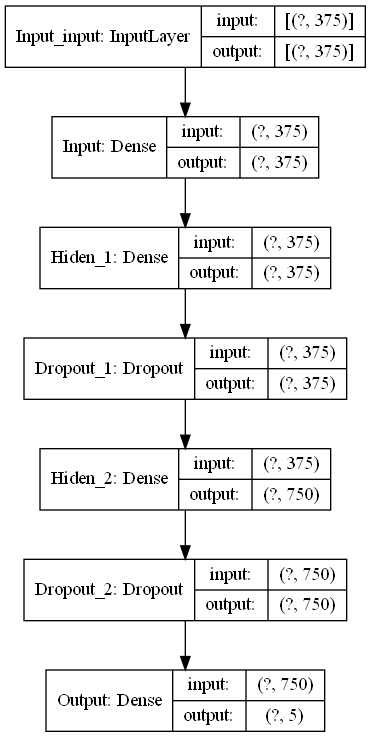

In [94]:
tf.keras.utils.plot_model(model_ANN, to_file= os.path.join(path_models, 'Model_CNN_1D' + norm_type + model_surname + '.png'), show_shapes=True)

### Understanding the column "Param":

1. For `Conv1D` layer:
   - The number of parameters for a `Conv1D` layer is calculated as `(kernel_size * input_channels + 1) * output_channels`, where `kernel_size` is the size of the convolutional kernel, `input_channels` is the number of input channels (1 in this case), and `output_channels` is the number of output channels.

2. For `Dense` layer:
   - The number of parameters for a `Dense` layer is calculated as `(input_units + 1) * output_units`, where `input_units` is the number of input units and `output_units` is the number of output units.
   
3. In the calculation of parameters for a convolutional layer, the term "channels" refers to the number of filters used in that layer.

- 224   parameters is the result of 28 filters * (7 kernels * 1 filter + 1)
- 4,794 parameters is the result of 34 filter * (5 kernels * 28 filters + 1)
- 5,768  parameters is the result of 56 filters * (3 kernels * 34 filters + 1)
- 515,250  parameters is the result of 50 neurons with 10,304 features + 50 bias values
- 255    parameters is the result of 5 neurons with 50 features + 5 bias values

In [95]:
batch_size_CNN_1D = 32
epochs_CNN_1D     = 150

history_CNN_1D    = model_CNN_1D.fit(X_train[..., np.newaxis], y_train_OHEV,
                                     batch_size      = batch_size_CNN_1D,
                                     epochs          = epochs_CNN_1D,
                                     verbose         = 1,
                                     validation_data =(X_test[..., np.newaxis], y_test_OHEV),
                                     callbacks       = callbacks_list)

Epoch 1/150
774/774 [==============================] - ETA: 0s - loss: 0.7970 - accuracy: 0.7278
Epoch 00001: val_accuracy improved from -inf to 0.77200, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_1D_weights_0_best_norm_windowed.hdf5
774/774 [==============================] - 3s 4ms/step - loss: 0.7970 - accuracy: 0.7278 - val_loss: 0.6699 - val_accuracy: 0.7720
Epoch 2/150
772/774 [============================>.] - ETA: 0s - loss: 0.5573 - accuracy: 0.8201
Epoch 00002: val_accuracy improved from 0.77200 to 0.82436, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_1D_weights_0_best_norm_windowed.hdf5
774/774 [==============================] - 3s 4ms/step - loss: 0.5572 - accuracy: 0.8201 - val_loss: 0.5363 - val_accuracy: 0.8244
Epoch 3/150
772/774 [============================>.] - ETA: 0s - loss: 0.4840 - accuracy: 0.8454
Epoch 00003: val_accuracy improved from 0.

771/774 [============================>.] - ETA: 0s - loss: 0.2526 - accuracy: 0.9251
Epoch 00022: val_accuracy did not improve from 0.90873
774/774 [==============================] - 3s 4ms/step - loss: 0.2528 - accuracy: 0.9250 - val_loss: 0.3024 - val_accuracy: 0.9058
Epoch 23/150
767/774 [============================>.] - ETA: 0s - loss: 0.2543 - accuracy: 0.9241
Epoch 00023: val_accuracy did not improve from 0.90873
774/774 [==============================] - 3s 4ms/step - loss: 0.2545 - accuracy: 0.9239 - val_loss: 0.3023 - val_accuracy: 0.9047
Epoch 24/150
764/774 [============================>.] - ETA: 0s - loss: 0.2462 - accuracy: 0.9269
Epoch 00024: val_accuracy did not improve from 0.90873
774/774 [==============================] - 3s 4ms/step - loss: 0.2467 - accuracy: 0.9269 - val_loss: 0.2954 - val_accuracy: 0.9084
Epoch 25/150
772/774 [============================>.] - ETA: 0s - loss: 0.2440 - accuracy: 0.9268
Epoch 00025: val_accuracy did not improve from 0.90873
774/774 

764/774 [============================>.] - ETA: 0s - loss: 0.1789 - accuracy: 0.9479
Epoch 00048: val_accuracy did not improve from 0.92473
774/774 [==============================] - 3s 4ms/step - loss: 0.1793 - accuracy: 0.9477 - val_loss: 0.2625 - val_accuracy: 0.9211
Epoch 49/150
772/774 [============================>.] - ETA: 0s - loss: 0.1806 - accuracy: 0.9475
Epoch 00049: val_accuracy improved from 0.92473 to 0.92545, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_1D_weights_0_best_norm_windowed.hdf5
774/774 [==============================] - 3s 4ms/step - loss: 0.1804 - accuracy: 0.9475 - val_loss: 0.2558 - val_accuracy: 0.9255
Epoch 50/150
762/774 [============================>.] - ETA: 0s - loss: 0.1782 - accuracy: 0.9488
Epoch 00050: val_accuracy did not improve from 0.92545
774/774 [==============================] - 3s 4ms/step - loss: 0.1783 - accuracy: 0.9488 - val_loss: 0.2625 - val_accuracy: 0.9207
Epoch 51/150

765/774 [============================>.] - ETA: 0s - loss: 0.1487 - accuracy: 0.9594
Epoch 00074: val_accuracy did not improve from 0.93273
774/774 [==============================] - 3s 4ms/step - loss: 0.1484 - accuracy: 0.9596 - val_loss: 0.2483 - val_accuracy: 0.9291
Epoch 75/150
767/774 [============================>.] - ETA: 0s - loss: 0.1478 - accuracy: 0.9583
Epoch 00075: val_accuracy did not improve from 0.93273
774/774 [==============================] - 3s 4ms/step - loss: 0.1479 - accuracy: 0.9583 - val_loss: 0.2391 - val_accuracy: 0.9298
Epoch 76/150
773/774 [============================>.] - ETA: 0s - loss: 0.1435 - accuracy: 0.9596
Epoch 00076: val_accuracy did not improve from 0.93273
774/774 [==============================] - 3s 4ms/step - loss: 0.1435 - accuracy: 0.9596 - val_loss: 0.2811 - val_accuracy: 0.9240
Epoch 77/150
771/774 [============================>.] - ETA: 0s - loss: 0.1450 - accuracy: 0.9598
Epoch 00077: val_accuracy did not improve from 0.93273
774/774 

772/774 [============================>.] - ETA: 0s - loss: 0.1258 - accuracy: 0.9661
Epoch 00101: val_accuracy did not improve from 0.93855
774/774 [==============================] - 3s 4ms/step - loss: 0.1258 - accuracy: 0.9661 - val_loss: 0.2572 - val_accuracy: 0.9302
Epoch 102/150
771/774 [============================>.] - ETA: 0s - loss: 0.1264 - accuracy: 0.9649
Epoch 00102: val_accuracy did not improve from 0.93855
774/774 [==============================] - 3s 4ms/step - loss: 0.1264 - accuracy: 0.9650 - val_loss: 0.2340 - val_accuracy: 0.9353
Epoch 103/150
774/774 [==============================] - ETA: 0s - loss: 0.1285 - accuracy: 0.9642
Epoch 00103: val_accuracy did not improve from 0.93855
774/774 [==============================] - 3s 4ms/step - loss: 0.1285 - accuracy: 0.9642 - val_loss: 0.2434 - val_accuracy: 0.9324
Epoch 104/150
770/774 [============================>.] - ETA: 0s - loss: 0.1272 - accuracy: 0.9655
Epoch 00104: val_accuracy did not improve from 0.93855
774/7

Epoch 130/150
763/774 [============================>.] - ETA: 0s - loss: 0.1100 - accuracy: 0.9717
Epoch 00130: val_accuracy did not improve from 0.93855
774/774 [==============================] - 3s 4ms/step - loss: 0.1099 - accuracy: 0.9718 - val_loss: 0.2456 - val_accuracy: 0.9305
Epoch 131/150
772/774 [============================>.] - ETA: 0s - loss: 0.1126 - accuracy: 0.9695
Epoch 00131: val_accuracy did not improve from 0.93855
774/774 [==============================] - 3s 4ms/step - loss: 0.1125 - accuracy: 0.9695 - val_loss: 0.2456 - val_accuracy: 0.9316
Epoch 132/150
763/774 [============================>.] - ETA: 0s - loss: 0.1144 - accuracy: 0.9694
Epoch 00132: val_accuracy did not improve from 0.93855
774/774 [==============================] - 3s 4ms/step - loss: 0.1145 - accuracy: 0.9695 - val_loss: 0.2520 - val_accuracy: 0.9291
Epoch 133/150
766/774 [============================>.] - ETA: 0s - loss: 0.1113 - accuracy: 0.9709
Epoch 00133: val_accuracy did not improve from

In [96]:
score_CNN_1D = model_CNN_1D.evaluate(X_test[..., np.newaxis], y_test_OHEV, verbose=0, batch_size = 32)
print('Test loss:', score_CNN_1D[0])
print('Test accuracy:', score_CNN_1D[1])

Test loss: 0.23589277267456055
Test accuracy: 0.9385454654693604


In [97]:
score_CNN_1D[1]

0.9385454654693604

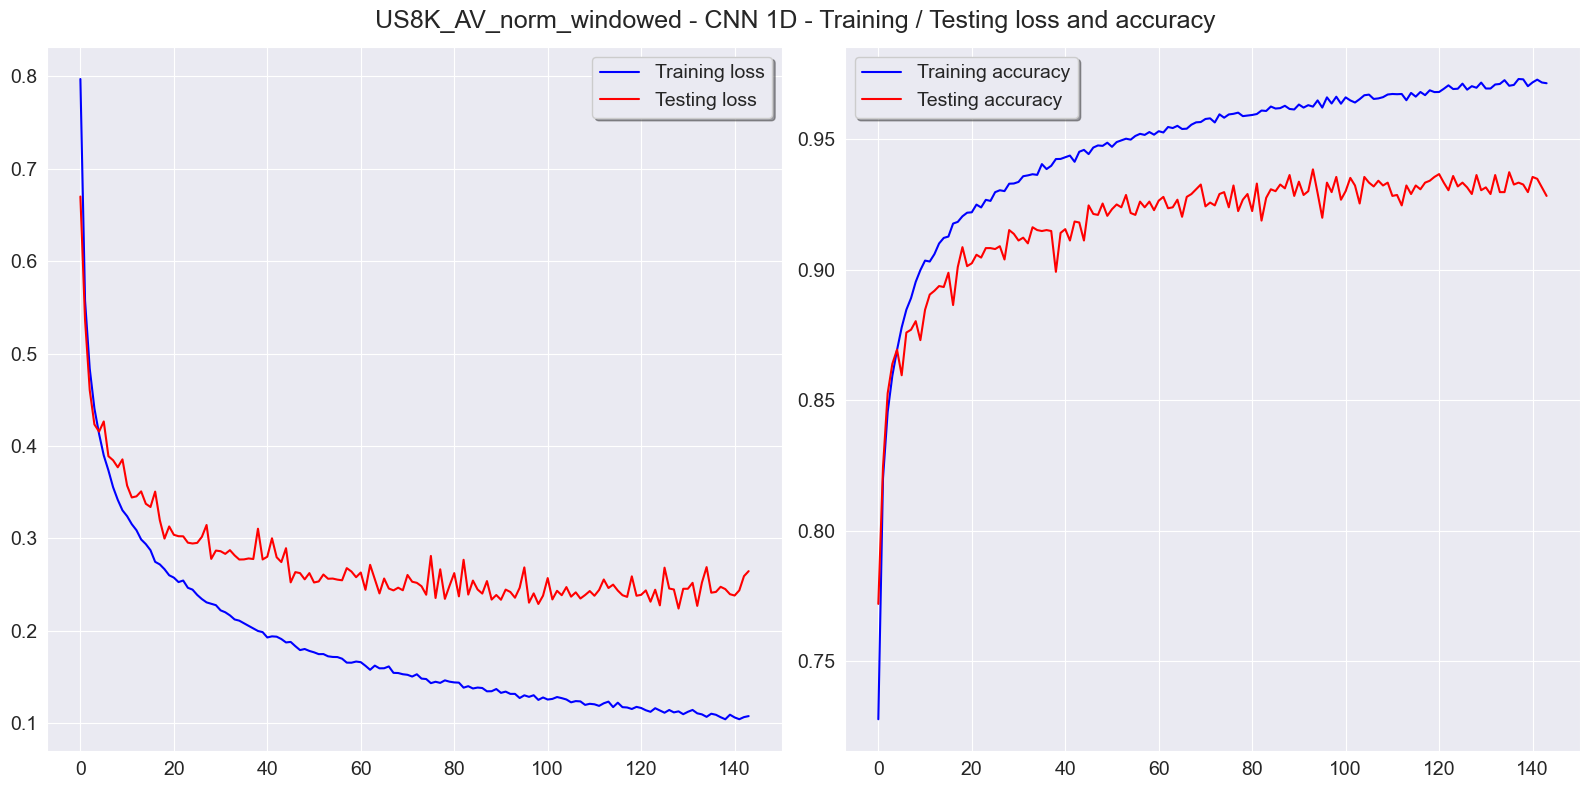

In [98]:
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

fig, ax = plt.subplots(1,2, figsize=(16,8))
fig.suptitle(nom_dataset + norm_type + model_surname + ' - CNN 1D - Training / Testing loss and accuracy', fontsize = 18)
ax[0].plot(history_CNN_1D.history['loss'], color='b', label="Training loss")
ax[0].plot(history_CNN_1D.history['val_loss'], color='r', label="Testing loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True, fontsize = 14)
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=14)

ax[1].plot(history_CNN_1D.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history_CNN_1D.history['val_accuracy'], color='r',label="Testing accuracy")
legend = ax[1].legend(loc='best', shadow=True, fontsize = 14)
ax[1].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='y', labelsize=14)

fig.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

In [99]:
y_pred_CNN_1D = np.argmax(model_CNN_1D.predict(X_val_norm[..., np.newaxis]),axis=1)
y_pred_CNN_1D

array([3, 3, 3, ..., 0, 0, 0], dtype=int64)

In [100]:
y_test_enc = np.argmax(y_OHEV_val, axis=1)
y_test_enc

array([3, 3, 3, ..., 0, 0, 0], dtype=int64)

In [101]:
metrics_set_CNN_1D = classification_report(y_test_enc, y_pred_CNN_1D, target_names=nom_classes)
print(metrics_set_CNN_1D)

                  precision    recall  f1-score   support

      background       0.83      0.73      0.78       756
        car_horn       0.84      0.88      0.86       252
children_playing       0.70      0.76      0.73       700
        dog_bark       0.76      0.85      0.80       700
           siren       0.80      0.71      0.75       602

        accuracy                           0.78      3010
       macro avg       0.79      0.79      0.78      3010
    weighted avg       0.78      0.78      0.77      3010



In [102]:
# Load the model with the highest accuracy

model_CNN_1D_saved = load_model(os.path.join(path_models, 'Model_CNN_1D_weights_0_best' + norm_type + model_surname + '.hdf5'))
model_CNN_1D_saved.summary()

Model: "CNN_1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 369, 28)           224       
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 369, 34)           4794      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 369, 56)           5768      
_________________________________________________________________
MaxPool1D_3 (MaxPooling1D)   (None, 184, 56)           0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 184, 56)           0         
_________________________________________________________________
flatten (Flatten)            (None, 10304)             0         
_________________________________________________________________
Dense (Dense)                (None, 50)                51525

In [103]:
score_CNN_1D_saved = model_CNN_1D_saved.evaluate(X_val_norm[..., np.newaxis], y_OHEV_val, verbose=1, batch_size = 32)
print('Test loss:', score_CNN_1D_saved[0])
print('Test accuracy:', score_CNN_1D_saved[1])

95/95 [==============================] - 0s 2ms/step - loss: 1.7807 - accuracy: 0.7751
Test loss: 1.7807343006134033
Test accuracy: 0.775083065032959


In [104]:
y_pred_CNN_1D_saved = np.argmax(model_CNN_1D_saved.predict(X_val_norm[..., np.newaxis]),axis=1)
y_pred_CNN_1D_saved

array([3, 3, 3, ..., 0, 0, 0], dtype=int64)

In [105]:
metrics_set_CNN_1D_saved = classification_report(y_test_enc, y_pred_CNN_1D_saved, target_names=nom_classes)
print(metrics_set_CNN_1D_saved)

                  precision    recall  f1-score   support

      background       0.83      0.73      0.78       756
        car_horn       0.84      0.88      0.86       252
children_playing       0.70      0.76      0.73       700
        dog_bark       0.76      0.85      0.80       700
           siren       0.80      0.71      0.75       602

        accuracy                           0.78      3010
       macro avg       0.79      0.79      0.78      3010
    weighted avg       0.78      0.78      0.77      3010



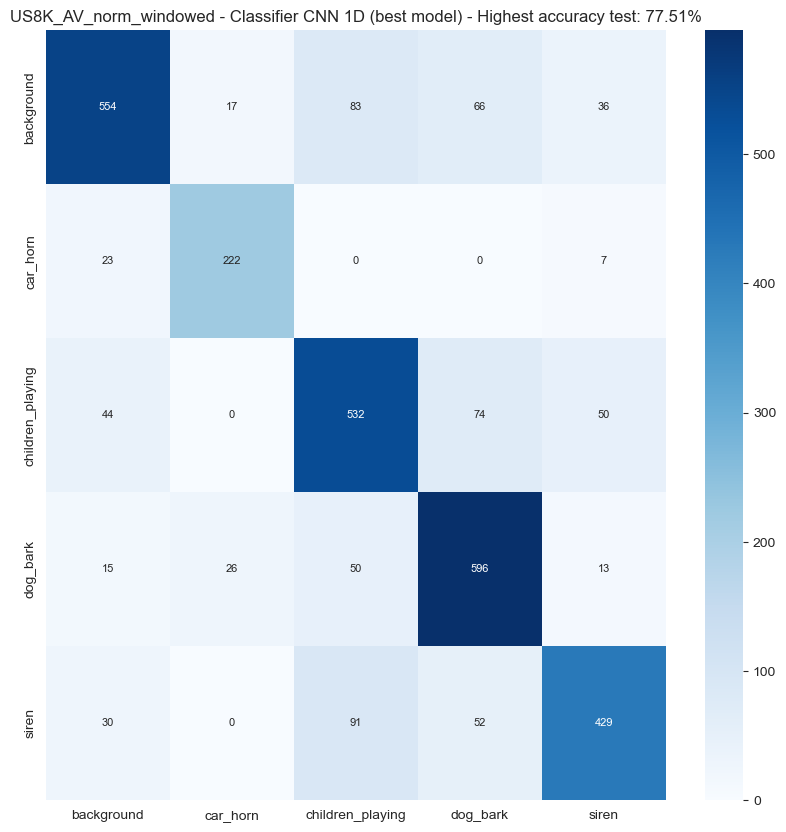

In [106]:
# Simple confusion matrix

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

conf_matrix = metrics.confusion_matrix(y_test_enc, y_pred_CNN_1D_saved)
title = nom_dataset + norm_type + model_surname + ' - Classifier CNN 1D (best model) - Highest accuracy test: '+ str("{:0.2f}%".format(score_CNN_1D_saved[1]*100))

plt.figure(figsize = (10,10))
sns.heatmap(conf_matrix, 
            annot=True, 
            fmt='g', 
            cmap=cmap_cm, 
            annot_kws={"size": 8}, 
            xticklabels=nom_classes, 
            yticklabels=nom_classes)
plt.title(title, fontsize = 12)
plt.savefig(os.path.join(path_pic, picture_name))
plt.show()


In [107]:
model_CNN_1D_saved.layers

In [108]:
for layer in model_CNN_1D_saved.layers:
    print(layer.get_weights())

[array([[[ 0.31187347,  0.56965   ,  0.39437732, -0.20509183,
          0.19913703,  0.2268352 ,  0.09268779,  0.18787232,
          0.04275443,  0.13827178, -0.17619027, -0.4258645 ,
         -1.331382  , -0.14218913, -0.02965143, -0.16826132,
          0.01487918,  0.3717704 ,  0.3878506 , -0.05878924,
         -0.30350992,  0.5127523 , -0.22276865, -0.2655716 ,
          0.20564559, -0.05680934,  0.04388108, -0.24845566]],

       [[ 0.14944993, -0.24126102,  0.4915105 ,  0.14564605,
         -0.17802507, -0.3725471 ,  0.04374021, -0.476927  ,
         -0.27167296, -0.3029667 , -0.10299665,  0.32777965,
         -1.4822747 , -0.47129154, -0.0410324 ,  0.03127728,
         -1.2463312 , -0.08369651, -0.04190935, -0.17118697,
         -0.3997618 ,  0.20154734, -0.36921975,  0.4081965 ,
         -0.34341362,  0.19413154,  0.05621165, -0.26439404]],

       [[ 0.36339745,  0.0211691 , -0.07887495, -0.18689027,
         -0.31200123,  0.30339035,  0.19391611, -0.50361925,
         -0.03620

In [109]:
weights = model_CNN_1D_saved.get_layer('Output').get_weights()
weights[1]

array([-0.00699311, -0.0268539 ,  0.01635103, -0.01566892, -0.00180505],
      dtype=float32)

## Metrics for the classifiers


1. Accuracy: Accuracy is a measure of how many correct predictions a model makes overall, i.e., the ratio of correct predictions to the total number of predictions. It's a commonly used metric for evaluating models, but it may not be suitable in certain situations.

2. Precision: Precision measures the ratio of true positives (correctly predicted positive instances) to all instances predicted as positive. It focuses on the accuracy of positive predictions.

3. Recall: Recall, also known as sensitivity or true positive rate, measures the ratio of true positives to all actual positive instances. It focuses on how well a model captures all the positive instances.

4. F1 Score: The F1 score is the harmonic mean of precision and recall. It provides a balanced measure that takes into account both false positives and false negatives. The F1 score is especially useful when you want to strike a balance between precision and recall.


The F1 score is a metric that combines precision and recall, and it is particularly useful in situations where class imbalance or unequal misclassification costs are present. In such contexts, the F1 score can be more informative and meaningful than accuracy.

A context where considering the F1 score makes more sense than accuracy:

**Medical Diagnosis:**

Imagine you're developing a model to diagnose a rare disease, and only 5% of the population has this disease. In this case, you have a significant class imbalance, where the majority of cases are negative (non-disease) and only a small fraction are positive (disease). If you were to use accuracy as the evaluation metric, the model could achieve a high accuracy by simply predicting "negative" for every case, because it would be correct 95% of the time due to the class imbalance. However, this would be entirely useless for detecting the actual disease.

In this scenario, you'd be more interested in the F1 score. The F1 score considers both precision and recall, helping you find a balance between correctly identifying the disease (high recall) and not making too many false positive predictions (high precision). A high F1 score in this context indicates that your model is effective at correctly identifying the disease while minimizing false alarms.

In [113]:
classifiers = ['ANN', 'CNN_1D']

In [114]:
# Pipeline to run the classifiers and their metrics

def model_classifiers(classifiers:list, 
                      db: pd.DataFrame, 
                      scalerOpt: str, 
                      use_PCA = False):
    
    # Clear the session to start a new training
    K.clear_session()
 
    es = EarlyStopping(monitor='accuracy', min_delta=0.0001, patience=50, verbose=1, mode='auto', restore_best_weights=True)
    
    count       = 1
    batch_size  = 32
    verbose     = True
    models      = []
    acc_set     = pd.DataFrame(index=None, columns=['Model',
                                                    'Fold',
                                                    'Accuracy(Train)',
                                                    'Accuracy(Val)',
                                                    'F1(Train)',
                                                    'F1(Val)', 
                                                    'Precision(Train)',
                                                    'Precision(Val)', 
                                                    'Recall(Train)',
                                                    'Recall(Val)', 
                                                    'Conf_M',
                                                    'Process_time',                                                     
                                                    'Class_report(Val)'])
    
    for fold in np.unique(db['Fold']):
        print(f"Validation fold: {fold}")

        DB_VAL = db[db['Fold'] == fold]
        DB_TRN = db[db['Fold'] != fold]

        X      = DB_TRN.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
        y      = np.array(DB_TRN.Class_categorical.to_list())
        y_OHEV = np.array(DB_TRN.Class_OHEV.to_list())

        X_val      = DB_VAL.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
        y_val      = np.array(DB_VAL.Class_categorical.to_list())
        y_OHEV_val = np.array(DB_VAL.Class_OHEV.to_list())
        
        neurons  = X.shape[1]
        
        X_statistics = pd.DataFrame({'mean': X.mean(), 'std': X.std(), 'min': X.min(), 'max': X.max()})

        X_mean   = X_statistics.values[:, 0]
        X_std    = X_statistics.values[:, 1]
        X_min    = X_statistics.values[:, 2]
        X_max    = X_statistics.values[:, 3]
        
        if scalerOpt == "normalization":
            X_train_norm = (X.values - X_min) / (X_max - X_min)
            X_val_norm   = (X_val.values - X_min) / (X_max - X_min)
            batch_type    = '_norm'
            print(f'X_train_norm shape...:{X_train_norm.shape}')
            print(f'X_val_norm shape.....:{X_val_norm.shape}\n')
            
        elif scalerOpt == "standardization":
            X_train_norm = (X.values - X_mean) / X_std
            X_val_norm   = (X_val.values - X_mean) / X_std
            batch_type    = '_std'
            print(f'X_train_norm shape...:{X_train_norm.shape}')
            print(f'X_val_norm shape.....:{X_val_norm.shape}\n')
            
        else:
            sys.exit()
            
        if use_PCA:
            pcaT = PCA()
            pcaT.fit(X_train_norm)
            ratio = pcaT.explained_variance_ratio_

            batch_type = batch_type + '_PCA'

            T           = 0.98
            current_sum = 0
            countComp   = 0

            for element in ratio:
                current_sum += element
                countComp   += 1

                if current_sum >= T:
                    break

            # Print the result
            print("Sum of elements:", current_sum)
            print("Number of elements summed:", countComp)           

            pca          = PCA(n_components = countComp)
            X_train_norm = pca.fit_transform(X_train_norm)
            X_val_norm   = pca.transform(X_val_norm)
            neurons      = countComp
        
        # The training dataset will be 10% reduced compared with the ML techniques, separating a test set to monitor
        # the accuracy during training
        X_train_norm, X_test_norm, y_train, y_test = train_test_split(X_train_norm, y_OHEV, test_size=0.1, random_state=42, stratify=y_OHEV)

        for i in tqdm(range(len(classifiers))):
            
            name         = classifiers[i]
            model_name   = ('Model_' + classifiers[i] + '_' + str(count))
            count        = count + 1
            
            if classifiers[i] == 'ANN':
                
                filepath       = os.path.join(path_models, 'Model_ANN_weights_0_best' + norm_type + model_surname + '.hdf5')
                checkpoint     = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
                callbacks_list = [checkpoint, es]
               
                model = build_ANN_model(model_name, neurons)
                model.summary()
                print(name)
                print(np.shape(X_train_norm))    

                model.fit(X_train_norm, 
                          y_train, 
                          batch_size      = batch_size, 
                          epochs          = 350, 
                          verbose         = verbose,                               
                          validation_data = (X_test_norm, y_test),
                          callbacks       = callbacks_list)
                
                model= load_model(os.path.join(path_models, 'Model_ANN_weights_0_best' + norm_type + model_surname + '.hdf5'))
                print('Best model loaded')

            else:

                filepath       = os.path.join(path_models, 'Model_CNN_1D_weights_0_best' + norm_type + model_surname + '.hdf5')
                checkpoint     = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
                callbacks_list = [checkpoint]                

                X_train_norm = X_train_norm[..., np.newaxis]
                X_val_norm   = X_val_norm[..., np.newaxis]
                X_test_norm  = X_test_norm[..., np.newaxis]

                model = build_CNN_1D_model(model_name, neurons)
                model.summary()
                print(name)
                print(np.shape(X_train_norm))    
                
                model.fit(X_train_norm, 
                          y_train, 
                          batch_size = batch_size, 
                          epochs = 150, 
                          verbose = verbose,                          
                          validation_data = (X_test_norm, y_test),
                          callbacks       = callbacks_list)

                model= load_model(os.path.join(path_models, 'Model_CNN_1D_weights_0_best' + norm_type + model_surname + '.hdf5'))
                print('Best model loaded')

            # Get the model predictions
            y_train_enc = np.argmax(y_train, axis=1)
            y_val_enc   = np.argmax(y_OHEV_val, axis=1)

            y_train_predicted = np.argmax(model.predict(X_train_norm), axis=1)
            
            t_srt             = time.process_time_ns()
            y_val_predicted   = np.argmax(model.predict(X_val_norm), axis=1)
            t_end             = time.process_time_ns()
            proc_time         = ((t_end - t_srt) / 1000000)         
    
            # Compute the classifier metrics
            accuracy_train = metrics.accuracy_score(y_train_enc, y_train_predicted)
            accuracy_val   = metrics.accuracy_score(y_val_enc,  y_val_predicted)

            f1_Score_train = metrics.f1_score(y_train_enc, y_train_predicted, average = 'weighted')
            f1_Score_val   = metrics.f1_score(y_val_enc,  y_val_predicted,  average = 'weighted')

            precision_score_train = metrics.precision_score(y_train_enc, y_train_predicted, average = 'weighted')
            precision_score_val   = metrics.precision_score(y_val_enc,  y_val_predicted,  average = 'weighted')

            recall_score_train = metrics.recall_score(y_train_enc, y_train_predicted, average = 'weighted')
            recall_score_val   = metrics.recall_score(y_val_enc,  y_val_predicted,  average = 'weighted')

            class_report_val = classification_report(y_val_enc, y_val_predicted, target_names = nom_classes)
            print(class_report_val)
            
            # Compute the confusion matrix
            CM = metrics.confusion_matrix(y_val_enc, y_val_predicted)
            y_val_enc       = []
            y_val_predicted = []

            # Store the name, test accuracy results and model
            models.append((name, accuracy_val, model))
            
            K.clear_session()
            del model
                    
            acc_set = pd.concat([acc_set, pd.DataFrame({'Model': [name],
                                                        'Fold': [fold],
                                                        'Accuracy(Train)': [accuracy_train],
                                                        'Accuracy(Val)': [accuracy_val],
                                                        'F1(Train)': [f1_Score_train],
                                                        'F1(Val)': [f1_Score_val],
                                                        'Precision(Train)': [precision_score_train],
                                                        'Precision(Val)': [precision_score_val],
                                                        'Recall(Train)': [recall_score_train],
                                                        'Recall(Val)': [recall_score_val],
                                                        'Conf_M': [CM],
                                                        'Process_time': [proc_time],
                                                        'Class_report(Val)': class_report_val})], ignore_index = True)
                   
    return acc_set, models, batch_type

In [115]:
# Option for scalerOpt is either "normalization" or "standardization"

metrics_set, models_set, batch_name = model_classifiers(classifiers, 
                                                        DB_from_pkl, 
                                                        scalerOpt = 'standardization',
                                                        use_PCA = True)

Validation fold: 1
X_train_norm shape...:(27496, 375)
X_val_norm shape.....:(3010, 375)

Sum of elements: 0.9801846635764112
Number of elements summed: 231


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_ANN_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 231)               53592     
_________________________________________________________________
Hiden_1 (Dense)              (None, 231)               53592     
_________________________________________________________________
Dropout_1 (Dropout)          (None, 231)               0         
_________________________________________________________________
Hiden_2 (Dense)              (None, 750)               174000    
_________________________________________________________________
Dropout_2 (Dropout)          (None, 750)               0         
_________________________________________________________________
Output (Dense)               (None, 5)                 3755      
Total params: 284,939
Trainable params: 284,939
Non-trainable params: 0
_________________________________________________

Epoch 19/350
750/774 [============================>.] - ETA: 0s - loss: 0.0273 - accuracy: 0.9925
Epoch 00019: val_accuracy improved from 0.94218 to 0.94255, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_ANN_weights_0_best_std_windowed.hdf5
774/774 [==============================] - 2s 2ms/step - loss: 0.0273 - accuracy: 0.9925 - val_loss: 0.2144 - val_accuracy: 0.9425
Epoch 20/350
774/774 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9932
Epoch 00020: val_accuracy improved from 0.94255 to 0.94291, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_ANN_weights_0_best_std_windowed.hdf5
774/774 [==============================] - 2s 2ms/step - loss: 0.0244 - accuracy: 0.9932 - val_loss: 0.2160 - val_accuracy: 0.9429
Epoch 21/350
773/774 [============================>.] - ETA: 0s - loss: 0.0200 - accuracy: 0.9947
Epoch 00021: val_accuracy improved from 0.94

Epoch 73/350
767/774 [============================>.] - ETA: 0s - loss: 0.0014 - accuracy: 0.9997
Epoch 00073: val_accuracy did not improve from 0.95055
774/774 [==============================] - 2s 2ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.2984 - val_accuracy: 0.9498
Epoch 74/350
768/774 [============================>.] - ETA: 0s - loss: 0.0021 - accuracy: 0.9995
Epoch 00074: val_accuracy did not improve from 0.95055
774/774 [==============================] - 1s 2ms/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.3096 - val_accuracy: 0.9495
Epoch 75/350
772/774 [============================>.] - ETA: 0s - loss: 0.0023 - accuracy: 0.9994
Epoch 00075: val_accuracy improved from 0.95055 to 0.95164, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_ANN_weights_0_best_std_windowed.hdf5
774/774 [==============================] - 1s 2ms/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.2966 - val_accuracy: 0.9516
Epo

745/774 [===========================>..] - ETA: 0s - loss: 6.1379e-04 - accuracy: 0.9999
Epoch 00128: val_accuracy did not improve from 0.95236
774/774 [==============================] - 1s 2ms/step - loss: 6.5040e-04 - accuracy: 0.9999 - val_loss: 0.3159 - val_accuracy: 0.9487
Epoch 129/350
749/774 [============================>.] - ETA: 0s - loss: 8.1760e-04 - accuracy: 0.9998
Epoch 00129: val_accuracy did not improve from 0.95236
774/774 [==============================] - 1s 2ms/step - loss: 8.0915e-04 - accuracy: 0.9998 - val_loss: 0.3170 - val_accuracy: 0.9495
Epoch 130/350
756/774 [============================>.] - ETA: 0s - loss: 4.2138e-04 - accuracy: 1.0000
Epoch 00130: val_accuracy did not improve from 0.95236
774/774 [==============================] - 1s 2ms/step - loss: 4.2613e-04 - accuracy: 1.0000 - val_loss: 0.3179 - val_accuracy: 0.9487
Epoch 131/350
774/774 [==============================] - ETA: 0s - loss: 5.5918e-04 - accuracy: 0.9999
Epoch 00131: val_accuracy did no

 50%|█████████████████████████████████████████▌                                         | 1/2 [03:59<03:59, 239.45s/it]

                  precision    recall  f1-score   support

      background       0.83      0.80      0.81       756
        car_horn       0.83      0.92      0.87       252
children_playing       0.77      0.78      0.77       700
        dog_bark       0.77      0.84      0.80       700
           siren       0.85      0.74      0.79       602

        accuracy                           0.80      3010
       macro avg       0.81      0.82      0.81      3010
    weighted avg       0.81      0.80      0.80      3010

Model: "Model_CNN_1D_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 225, 28)           224       
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 225, 34)           4794      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 225, 56)           

Epoch 18/150
768/774 [============================>.] - ETA: 0s - loss: 0.1845 - accuracy: 0.9525
Epoch 00018: val_accuracy improved from 0.90582 to 0.91091, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_1D_weights_0_best_std_windowed.hdf5
774/774 [==============================] - 3s 3ms/step - loss: 0.1847 - accuracy: 0.9525 - val_loss: 0.3313 - val_accuracy: 0.9109
Epoch 19/150
773/774 [============================>.] - ETA: 0s - loss: 0.1769 - accuracy: 0.9559
Epoch 00019: val_accuracy did not improve from 0.91091
774/774 [==============================] - 3s 4ms/step - loss: 0.1770 - accuracy: 0.9558 - val_loss: 0.3201 - val_accuracy: 0.9102
Epoch 20/150
771/774 [============================>.] - ETA: 0s - loss: 0.1720 - accuracy: 0.9572
Epoch 00020: val_accuracy did not improve from 0.91091
774/774 [==============================] - 2s 3ms/step - loss: 0.1719 - accuracy: 0.9572 - val_loss: 0.3350 - val_accuracy: 0.9084


774/774 [==============================] - 2s 3ms/step - loss: 0.0888 - accuracy: 0.9831 - val_loss: 0.3468 - val_accuracy: 0.9225
Epoch 70/150
761/774 [============================>.] - ETA: 0s - loss: 0.0869 - accuracy: 0.9831
Epoch 00070: val_accuracy did not improve from 0.92255
774/774 [==============================] - 2s 3ms/step - loss: 0.0869 - accuracy: 0.9831 - val_loss: 0.3440 - val_accuracy: 0.9211
Epoch 71/150
761/774 [============================>.] - ETA: 0s - loss: 0.0869 - accuracy: 0.9831
Epoch 00071: val_accuracy improved from 0.92255 to 0.92400, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_1D_weights_0_best_std_windowed.hdf5
774/774 [==============================] - 2s 3ms/step - loss: 0.0868 - accuracy: 0.9832 - val_loss: 0.3645 - val_accuracy: 0.9240
Epoch 72/150
756/774 [============================>.] - ETA: 0s - loss: 0.0925 - accuracy: 0.9810
Epoch 00072: val_accuracy did not improve from 0.92400


Epoch 97/150
757/774 [============================>.] - ETA: 0s - loss: 0.0804 - accuracy: 0.9840
Epoch 00097: val_accuracy did not improve from 0.92509
774/774 [==============================] - 2s 3ms/step - loss: 0.0807 - accuracy: 0.9840 - val_loss: 0.3587 - val_accuracy: 0.9149
Epoch 98/150
765/774 [============================>.] - ETA: 0s - loss: 0.0740 - accuracy: 0.9863
Epoch 00098: val_accuracy did not improve from 0.92509
774/774 [==============================] - 3s 3ms/step - loss: 0.0739 - accuracy: 0.9863 - val_loss: 0.3408 - val_accuracy: 0.9251
Epoch 99/150
766/774 [============================>.] - ETA: 0s - loss: 0.0735 - accuracy: 0.9872
Epoch 00099: val_accuracy did not improve from 0.92509
774/774 [==============================] - 3s 3ms/step - loss: 0.0736 - accuracy: 0.9871 - val_loss: 0.3589 - val_accuracy: 0.9171
Epoch 100/150
774/774 [==============================] - ETA: 0s - loss: 0.0713 - accuracy: 0.9863
Epoch 00100: val_accuracy did not improve from 0.

Epoch 125/150
774/774 [==============================] - ETA: 0s - loss: 0.0640 - accuracy: 0.9892
Epoch 00125: val_accuracy did not improve from 0.92655
774/774 [==============================] - 2s 3ms/step - loss: 0.0640 - accuracy: 0.9892 - val_loss: 0.3457 - val_accuracy: 0.9255
Epoch 126/150
770/774 [============================>.] - ETA: 0s - loss: 0.0667 - accuracy: 0.9869
Epoch 00126: val_accuracy did not improve from 0.92655
774/774 [==============================] - 2s 3ms/step - loss: 0.0668 - accuracy: 0.9869 - val_loss: 0.3456 - val_accuracy: 0.9258
Epoch 127/150
770/774 [============================>.] - ETA: 0s - loss: 0.0662 - accuracy: 0.9868
Epoch 00127: val_accuracy improved from 0.92655 to 0.92800, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_1D_weights_0_best_std_windowed.hdf5
774/774 [==============================] - 2s 3ms/step - loss: 0.0661 - accuracy: 0.9869 - val_loss: 0.3429 - val_accuracy: 0.92

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [10:45<00:00, 322.85s/it]

                  precision    recall  f1-score   support

      background       0.87      0.76      0.81       756
        car_horn       0.81      0.90      0.85       252
children_playing       0.73      0.80      0.76       700
        dog_bark       0.74      0.83      0.78       700
           siren       0.88      0.76      0.82       602

        accuracy                           0.80      3010
       macro avg       0.81      0.81      0.81      3010
    weighted avg       0.81      0.80      0.80      3010

Validation fold: 10


X_train_norm shape...:(27573, 375)
X_val_norm shape.....:(2933, 375)

Sum of elements: 0.9800710149454922
Number of elements summed: 234


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_ANN_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 234)               54990     
_________________________________________________________________
Hiden_1 (Dense)              (None, 234)               54990     
_________________________________________________________________
Dropout_1 (Dropout)          (None, 234)               0         
_________________________________________________________________
Hiden_2 (Dense)              (None, 750)               176250    
_________________________________________________________________
Dropout_2 (Dropout)          (None, 750)               0         
_________________________________________________________________
Output (Dense)               (None, 5)                 3755      
Total params: 289,985
Trainable params: 289,985
Non-trainable params: 0
_________________________________________________

Epoch 18/350
768/776 [============================>.] - ETA: 0s - loss: 0.0284 - accuracy: 0.9924
Epoch 00018: val_accuracy did not improve from 0.94634
776/776 [==============================] - 2s 2ms/step - loss: 0.0284 - accuracy: 0.9923 - val_loss: 0.1951 - val_accuracy: 0.9453
Epoch 19/350
768/776 [============================>.] - ETA: 0s - loss: 0.0252 - accuracy: 0.9926
Epoch 00019: val_accuracy did not improve from 0.94634
776/776 [==============================] - 2s 2ms/step - loss: 0.0255 - accuracy: 0.9925 - val_loss: 0.1976 - val_accuracy: 0.9456
Epoch 20/350
761/776 [============================>.] - ETA: 0s - loss: 0.0213 - accuracy: 0.9943
Epoch 00020: val_accuracy improved from 0.94634 to 0.94851, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_ANN_weights_0_best_std_windowed.hdf5
776/776 [==============================] - 1s 2ms/step - loss: 0.0211 - accuracy: 0.9944 - val_loss: 0.1997 - val_accuracy: 0.9485
Epo

Epoch 72/350
762/776 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 0.9999
Epoch 00072: val_accuracy did not improve from 0.95359
776/776 [==============================] - 1s 2ms/step - loss: 0.0012 - accuracy: 0.9999 - val_loss: 0.2578 - val_accuracy: 0.9525
Epoch 73/350
758/776 [============================>.] - ETA: 0s - loss: 0.0020 - accuracy: 0.9995
Epoch 00073: val_accuracy did not improve from 0.95359
776/776 [==============================] - 1s 2ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.2571 - val_accuracy: 0.9532
Epoch 74/350
753/776 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 0.9998
Epoch 00074: val_accuracy did not improve from 0.95359
776/776 [==============================] - 1s 2ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 0.2574 - val_accuracy: 0.9529
Epoch 75/350
775/776 [============================>.] - ETA: 0s - loss: 0.0021 - accuracy: 0.9996
Epoch 00075: val_accuracy did not improve from 0.9

Epoch 98/350
754/776 [============================>.] - ETA: 0s - loss: 7.7488e-04 - accuracy: 0.9999
Epoch 00098: val_accuracy did not improve from 0.95649
776/776 [==============================] - 1s 2ms/step - loss: 7.7267e-04 - accuracy: 0.9999 - val_loss: 0.2698 - val_accuracy: 0.9529
Epoch 99/350
768/776 [============================>.] - ETA: 0s - loss: 9.9292e-04 - accuracy: 0.9998
Epoch 00099: val_accuracy did not improve from 0.95649
776/776 [==============================] - 1s 2ms/step - loss: 9.8703e-04 - accuracy: 0.9998 - val_loss: 0.2662 - val_accuracy: 0.9554
Epoch 100/350
768/776 [============================>.] - ETA: 0s - loss: 0.0010 - accuracy: 0.9998
Epoch 00100: val_accuracy did not improve from 0.95649
776/776 [==============================] - 1s 2ms/step - loss: 9.9258e-04 - accuracy: 0.9998 - val_loss: 0.2662 - val_accuracy: 0.9547
Epoch 101/350
773/776 [============================>.] - ETA: 0s - loss: 9.8036e-04 - accuracy: 0.9997
Epoch 00101: val_accurac

 50%|█████████████████████████████████████████▌                                         | 1/2 [02:50<02:50, 170.54s/it]

                  precision    recall  f1-score   support

      background       0.84      0.88      0.86       721
        car_horn       0.79      0.80      0.79       231
children_playing       0.68      0.80      0.74       700
        dog_bark       0.73      0.77      0.75       700
           siren       0.83      0.56      0.67       581

        accuracy                           0.76      2933
       macro avg       0.77      0.76      0.76      2933
    weighted avg       0.77      0.76      0.76      2933

Model: "Model_CNN_1D_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 228, 28)           224       
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 228, 34)           4794      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 228, 56)           

Epoch 17/150
762/776 [============================>.] - ETA: 0s - loss: 0.1846 - accuracy: 0.9544
Epoch 00017: val_accuracy did not improve from 0.92386
776/776 [==============================] - 2s 3ms/step - loss: 0.1850 - accuracy: 0.9542 - val_loss: 0.3175 - val_accuracy: 0.9191
Epoch 18/150
774/776 [============================>.] - ETA: 0s - loss: 0.1820 - accuracy: 0.9547
Epoch 00018: val_accuracy improved from 0.92386 to 0.92676, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_1D_weights_0_best_std_windowed.hdf5
776/776 [==============================] - 2s 3ms/step - loss: 0.1822 - accuracy: 0.9546 - val_loss: 0.3075 - val_accuracy: 0.9268
Epoch 19/150
776/776 [==============================] - ETA: 0s - loss: 0.1744 - accuracy: 0.9579
Epoch 00019: val_accuracy did not improve from 0.92676
776/776 [==============================] - 2s 3ms/step - loss: 0.1744 - accuracy: 0.9579 - val_loss: 0.2983 - val_accuracy: 0.9231


Epoch 71/150
762/776 [============================>.] - ETA: 0s - loss: 0.0864 - accuracy: 0.9827
Epoch 00071: val_accuracy did not improve from 0.93075
776/776 [==============================] - 2s 3ms/step - loss: 0.0867 - accuracy: 0.9826 - val_loss: 0.3539 - val_accuracy: 0.9224
Epoch 72/150
757/776 [============================>.] - ETA: 0s - loss: 0.0825 - accuracy: 0.9845
Epoch 00072: val_accuracy did not improve from 0.93075
776/776 [==============================] - 2s 3ms/step - loss: 0.0827 - accuracy: 0.9844 - val_loss: 0.3405 - val_accuracy: 0.9253
Epoch 73/150
760/776 [============================>.] - ETA: 0s - loss: 0.0849 - accuracy: 0.9831
Epoch 00073: val_accuracy did not improve from 0.93075
776/776 [==============================] - 2s 3ms/step - loss: 0.0848 - accuracy: 0.9833 - val_loss: 0.3510 - val_accuracy: 0.9228
Epoch 74/150
762/776 [============================>.] - ETA: 0s - loss: 0.0807 - accuracy: 0.9861
Epoch 00074: val_accuracy did not improve from 0.9

Epoch 128/150
773/776 [============================>.] - ETA: 0s - loss: 0.0581 - accuracy: 0.9899
Epoch 00128: val_accuracy did not improve from 0.93328
776/776 [==============================] - 2s 3ms/step - loss: 0.0581 - accuracy: 0.9899 - val_loss: 0.3593 - val_accuracy: 0.9300
Epoch 129/150
776/776 [==============================] - ETA: 0s - loss: 0.0631 - accuracy: 0.9880
Epoch 00129: val_accuracy did not improve from 0.93328
776/776 [==============================] - 2s 3ms/step - loss: 0.0631 - accuracy: 0.9880 - val_loss: 0.3571 - val_accuracy: 0.9278
Epoch 130/150
769/776 [============================>.] - ETA: 0s - loss: 0.0635 - accuracy: 0.9878
Epoch 00130: val_accuracy did not improve from 0.93328
776/776 [==============================] - 2s 3ms/step - loss: 0.0635 - accuracy: 0.9878 - val_loss: 0.3759 - val_accuracy: 0.9275
Epoch 131/150
765/776 [============================>.] - ETA: 0s - loss: 0.0666 - accuracy: 0.9868
Epoch 00131: val_accuracy did not improve from

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [08:38<00:00, 259.13s/it]

                  precision    recall  f1-score   support

      background       0.81      0.90      0.85       721
        car_horn       0.87      0.76      0.81       231
children_playing       0.62      0.82      0.71       700
        dog_bark       0.77      0.74      0.76       700
           siren       0.81      0.48      0.60       581

        accuracy                           0.75      2933
       macro avg       0.78      0.74      0.75      2933
    weighted avg       0.76      0.75      0.74      2933

Validation fold: 2


X_train_norm shape...:(27503, 375)
X_val_norm shape.....:(3003, 375)

Sum of elements: 0.9802557517920008
Number of elements summed: 233


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_ANN_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 233)               54522     
_________________________________________________________________
Hiden_1 (Dense)              (None, 233)               54522     
_________________________________________________________________
Dropout_1 (Dropout)          (None, 233)               0         
_________________________________________________________________
Hiden_2 (Dense)              (None, 750)               175500    
_________________________________________________________________
Dropout_2 (Dropout)          (None, 750)               0         
_________________________________________________________________
Output (Dense)               (None, 5)                 3755      
Total params: 288,299
Trainable params: 288,299
Non-trainable params: 0
_________________________________________________

Epoch 19/350
750/774 [============================>.] - ETA: 0s - loss: 0.0273 - accuracy: 0.9920
Epoch 00019: val_accuracy improved from 0.93748 to 0.93893, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_ANN_weights_0_best_std_windowed.hdf5
774/774 [==============================] - 2s 2ms/step - loss: 0.0275 - accuracy: 0.9918 - val_loss: 0.2233 - val_accuracy: 0.9389
Epoch 20/350
764/774 [============================>.] - ETA: 0s - loss: 0.0228 - accuracy: 0.9934
Epoch 00020: val_accuracy did not improve from 0.93893
774/774 [==============================] - 2s 2ms/step - loss: 0.0228 - accuracy: 0.9934 - val_loss: 0.2408 - val_accuracy: 0.9375
Epoch 21/350
756/774 [============================>.] - ETA: 0s - loss: 0.0195 - accuracy: 0.9945
Epoch 00021: val_accuracy improved from 0.93893 to 0.94111, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_ANN_weights_0_best_std_win

Epoch 73/350
772/774 [============================>.] - ETA: 0s - loss: 9.7374e-04 - accuracy: 0.9999
Epoch 00073: val_accuracy did not improve from 0.94838
774/774 [==============================] - 1s 2ms/step - loss: 9.7358e-04 - accuracy: 0.9999 - val_loss: 0.2967 - val_accuracy: 0.9466
Epoch 74/350
749/774 [============================>.] - ETA: 0s - loss: 0.0010 - accuracy: 0.9999  
Epoch 00074: val_accuracy did not improve from 0.94838
774/774 [==============================] - 1s 2ms/step - loss: 0.0010 - accuracy: 0.9999 - val_loss: 0.3028 - val_accuracy: 0.9447
Epoch 75/350
743/774 [===========================>..] - ETA: 0s - loss: 0.0013 - accuracy: 0.9998
Epoch 00075: val_accuracy did not improve from 0.94838
774/774 [==============================] - 1s 2ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.3028 - val_accuracy: 0.9458
Epoch 76/350
759/774 [============================>.] - ETA: 0s - loss: 0.0018 - accuracy: 0.9996
Epoch 00076: val_accuracy did not improv

Epoch 102/350
754/774 [============================>.] - ETA: 0s - loss: 8.4906e-04 - accuracy: 0.9999
Epoch 00102: val_accuracy did not improve from 0.94838
774/774 [==============================] - 1s 2ms/step - loss: 8.3986e-04 - accuracy: 0.9999 - val_loss: 0.3253 - val_accuracy: 0.9473
Epoch 103/350
755/774 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 0.9998
Epoch 00103: val_accuracy did not improve from 0.94838
774/774 [==============================] - 1s 2ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.3363 - val_accuracy: 0.9462
Epoch 104/350
774/774 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.9998
Epoch 00104: val_accuracy did not improve from 0.94838
774/774 [==============================] - 1s 2ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.3290 - val_accuracy: 0.9480
Epoch 105/350
750/774 [============================>.] - ETA: 0s - loss: 7.4116e-04 - accuracy: 0.9998
Epoch 00105: val_accuracy did not 

Epoch 130/350
747/774 [===========================>..] - ETA: 0s - loss: 5.0176e-04 - accuracy: 1.0000
Epoch 00130: val_accuracy did not improve from 0.94911
774/774 [==============================] - 1s 2ms/step - loss: 5.2114e-04 - accuracy: 1.0000 - val_loss: 0.3373 - val_accuracy: 0.9473
Epoch 131/350
757/774 [============================>.] - ETA: 0s - loss: 5.4787e-04 - accuracy: 1.0000
Epoch 00131: val_accuracy did not improve from 0.94911
774/774 [==============================] - 1s 2ms/step - loss: 5.4023e-04 - accuracy: 1.0000 - val_loss: 0.3374 - val_accuracy: 0.9469
Epoch 132/350
767/774 [============================>.] - ETA: 0s - loss: 6.8644e-04 - accuracy: 0.9998
Epoch 00132: val_accuracy did not improve from 0.94911
774/774 [==============================] - 1s 2ms/step - loss: 6.8093e-04 - accuracy: 0.9998 - val_loss: 0.3379 - val_accuracy: 0.9462
Epoch 133/350
744/774 [===========================>..] - ETA: 0s - loss: 5.4224e-04 - accuracy: 1.0000
Epoch 00133: val_a

 50%|█████████████████████████████████████████▌                                         | 1/2 [03:39<03:39, 219.40s/it]

                  precision    recall  f1-score   support

      background       0.70      0.61      0.66       672
        car_horn       0.68      0.56      0.62       294
children_playing       0.77      0.89      0.83       700
        dog_bark       0.79      0.85      0.82       700
           siren       0.70      0.68      0.69       637

        accuracy                           0.74      3003
       macro avg       0.73      0.72      0.72      3003
    weighted avg       0.74      0.74      0.74      3003

Model: "Model_CNN_1D_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 227, 28)           224       
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 227, 34)           4794      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 227, 56)           

Epoch 18/150
755/774 [============================>.] - ETA: 0s - loss: 0.1797 - accuracy: 0.9561
Epoch 00018: val_accuracy did not improve from 0.90513
774/774 [==============================] - 2s 3ms/step - loss: 0.1798 - accuracy: 0.9561 - val_loss: 0.3785 - val_accuracy: 0.9019
Epoch 19/150
766/774 [============================>.] - ETA: 0s - loss: 0.1750 - accuracy: 0.9594
Epoch 00019: val_accuracy did not improve from 0.90513
774/774 [==============================] - 2s 3ms/step - loss: 0.1751 - accuracy: 0.9592 - val_loss: 0.3812 - val_accuracy: 0.9040
Epoch 20/150
772/774 [============================>.] - ETA: 0s - loss: 0.1697 - accuracy: 0.9598
Epoch 00020: val_accuracy did not improve from 0.90513
774/774 [==============================] - 2s 3ms/step - loss: 0.1699 - accuracy: 0.9597 - val_loss: 0.4189 - val_accuracy: 0.8982
Epoch 21/150
757/774 [============================>.] - ETA: 0s - loss: 0.1632 - accuracy: 0.9616
Epoch 00021: val_accuracy did not improve from 0.9

Epoch 45/150
774/774 [==============================] - ETA: 0s - loss: 0.1026 - accuracy: 0.9814
Epoch 00045: val_accuracy did not improve from 0.91203
774/774 [==============================] - 2s 3ms/step - loss: 0.1026 - accuracy: 0.9814 - val_loss: 0.4033 - val_accuracy: 0.9080
Epoch 46/150
769/774 [============================>.] - ETA: 0s - loss: 0.1094 - accuracy: 0.9776
Epoch 00046: val_accuracy improved from 0.91203 to 0.91240, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_1D_weights_0_best_std_windowed.hdf5
774/774 [==============================] - 2s 3ms/step - loss: 0.1094 - accuracy: 0.9776 - val_loss: 0.3983 - val_accuracy: 0.9124
Epoch 47/150
762/774 [============================>.] - ETA: 0s - loss: 0.1058 - accuracy: 0.9790
Epoch 00047: val_accuracy did not improve from 0.91240
774/774 [==============================] - 2s 3ms/step - loss: 0.1058 - accuracy: 0.9790 - val_loss: 0.4051 - val_accuracy: 0.9106


Epoch 100/150
768/774 [============================>.] - ETA: 0s - loss: 0.0758 - accuracy: 0.9860
Epoch 00100: val_accuracy did not improve from 0.91858
774/774 [==============================] - 2s 3ms/step - loss: 0.0758 - accuracy: 0.9860 - val_loss: 0.4268 - val_accuracy: 0.9124
Epoch 101/150
760/774 [============================>.] - ETA: 0s - loss: 0.0705 - accuracy: 0.9872
Epoch 00101: val_accuracy did not improve from 0.91858
774/774 [==============================] - 2s 3ms/step - loss: 0.0707 - accuracy: 0.9872 - val_loss: 0.4160 - val_accuracy: 0.9149
Epoch 102/150
774/774 [==============================] - ETA: 0s - loss: 0.0729 - accuracy: 0.9870
Epoch 00102: val_accuracy did not improve from 0.91858
774/774 [==============================] - 2s 3ms/step - loss: 0.0729 - accuracy: 0.9870 - val_loss: 0.4248 - val_accuracy: 0.9157
Epoch 103/150
761/774 [============================>.] - ETA: 0s - loss: 0.0727 - accuracy: 0.9869
Epoch 00103: val_accuracy improved from 0.9185

Epoch 128/150
769/774 [============================>.] - ETA: 0s - loss: 0.0676 - accuracy: 0.9875
Epoch 00128: val_accuracy did not improve from 0.92112
774/774 [==============================] - 2s 3ms/step - loss: 0.0676 - accuracy: 0.9874 - val_loss: 0.4185 - val_accuracy: 0.9153
Epoch 129/150
767/774 [============================>.] - ETA: 0s - loss: 0.0614 - accuracy: 0.9899
Epoch 00129: val_accuracy did not improve from 0.92112
774/774 [==============================] - 2s 3ms/step - loss: 0.0615 - accuracy: 0.9899 - val_loss: 0.4355 - val_accuracy: 0.9113
Epoch 130/150
773/774 [============================>.] - ETA: 0s - loss: 0.0635 - accuracy: 0.9883
Epoch 00130: val_accuracy did not improve from 0.92112
774/774 [==============================] - 2s 3ms/step - loss: 0.0635 - accuracy: 0.9883 - val_loss: 0.4370 - val_accuracy: 0.9113
Epoch 131/150
771/774 [============================>.] - ETA: 0s - loss: 0.0656 - accuracy: 0.9873
Epoch 00131: val_accuracy did not improve from

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [09:56<00:00, 298.25s/it]

                  precision    recall  f1-score   support

      background       0.65      0.66      0.66       672
        car_horn       0.65      0.50      0.56       294
children_playing       0.74      0.85      0.79       700
        dog_bark       0.81      0.82      0.81       700
           siren       0.76      0.69      0.72       637

        accuracy                           0.73      3003
       macro avg       0.72      0.70      0.71      3003
    weighted avg       0.73      0.73      0.73      3003

Validation fold: 3


X_train_norm shape...:(27132, 375)
X_val_norm shape.....:(3374, 375)

Sum of elements: 0.9802037458487682
Number of elements summed: 233


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_ANN_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 233)               54522     
_________________________________________________________________
Hiden_1 (Dense)              (None, 233)               54522     
_________________________________________________________________
Dropout_1 (Dropout)          (None, 233)               0         
_________________________________________________________________
Hiden_2 (Dense)              (None, 750)               175500    
_________________________________________________________________
Dropout_2 (Dropout)          (None, 750)               0         
_________________________________________________________________
Output (Dense)               (None, 5)                 3755      
Total params: 288,299
Trainable params: 288,299
Non-trainable params: 0
_________________________________________________

Epoch 18/350
742/764 [============================>.] - ETA: 0s - loss: 0.0335 - accuracy: 0.9904
Epoch 00018: val_accuracy improved from 0.93994 to 0.94068, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_ANN_weights_0_best_std_windowed.hdf5
764/764 [==============================] - 1s 2ms/step - loss: 0.0334 - accuracy: 0.9904 - val_loss: 0.2198 - val_accuracy: 0.9407
Epoch 19/350
745/764 [============================>.] - ETA: 0s - loss: 0.0285 - accuracy: 0.9920
Epoch 00019: val_accuracy improved from 0.94068 to 0.94289, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_ANN_weights_0_best_std_windowed.hdf5
764/764 [==============================] - 1s 2ms/step - loss: 0.0284 - accuracy: 0.9919 - val_loss: 0.2194 - val_accuracy: 0.9429
Epoch 20/350
733/764 [===========================>..] - ETA: 0s - loss: 0.0238 - accuracy: 0.9934
Epoch 00020: val_accuracy did not improve fr

Epoch 44/350
734/764 [===========================>..] - ETA: 0s - loss: 0.0035 - accuracy: 0.9993
Epoch 00044: val_accuracy improved from 0.94915 to 0.94989, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_ANN_weights_0_best_std_windowed.hdf5
764/764 [==============================] - 1s 2ms/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 0.2737 - val_accuracy: 0.9499
Epoch 45/350
755/764 [============================>.] - ETA: 0s - loss: 0.0039 - accuracy: 0.9990
Epoch 00045: val_accuracy did not improve from 0.94989
764/764 [==============================] - 1s 2ms/step - loss: 0.0040 - accuracy: 0.9989 - val_loss: 0.2722 - val_accuracy: 0.9499
Epoch 46/350
731/764 [===========================>..] - ETA: 0s - loss: 0.0035 - accuracy: 0.9994
Epoch 00046: val_accuracy did not improve from 0.94989
764/764 [==============================] - 1s 2ms/step - loss: 0.0035 - accuracy: 0.9994 - val_loss: 0.2759 - val_accuracy: 0.9466
Epo

Epoch 99/350
747/764 [============================>.] - ETA: 0s - loss: 8.7839e-04 - accuracy: 0.9999
Epoch 00099: val_accuracy did not improve from 0.95210
764/764 [==============================] - 2s 2ms/step - loss: 8.7096e-04 - accuracy: 0.9999 - val_loss: 0.3212 - val_accuracy: 0.9521
Epoch 100/350
763/764 [============================>.] - ETA: 0s - loss: 9.5819e-04 - accuracy: 0.9999
Epoch 00100: val_accuracy did not improve from 0.95210
764/764 [==============================] - 2s 2ms/step - loss: 9.5811e-04 - accuracy: 0.9999 - val_loss: 0.3252 - val_accuracy: 0.9514
Epoch 101/350
751/764 [============================>.] - ETA: 0s - loss: 7.3124e-04 - accuracy: 1.0000
Epoch 00101: val_accuracy did not improve from 0.95210
764/764 [==============================] - 2s 2ms/step - loss: 7.2800e-04 - accuracy: 1.0000 - val_loss: 0.3260 - val_accuracy: 0.9503
Epoch 102/350
745/764 [============================>.] - ETA: 0s - loss: 0.0014 - accuracy: 0.9997
Epoch 00102: val_accura

 50%|█████████████████████████████████████████▌                                         | 1/2 [02:50<02:50, 170.94s/it]

                  precision    recall  f1-score   support

      background       0.78      0.81      0.80       840
        car_horn       0.86      0.98      0.91       301
children_playing       0.78      0.78      0.78       700
        dog_bark       0.84      0.80      0.82       700
           siren       0.88      0.84      0.86       833

        accuracy                           0.82      3374
       macro avg       0.83      0.84      0.83      3374
    weighted avg       0.82      0.82      0.82      3374

Model: "Model_CNN_1D_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 227, 28)           224       
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 227, 34)           4794      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 227, 56)           

759/764 [============================>.] - ETA: 0s - loss: 0.1171 - accuracy: 0.9765
Epoch 00042: val_accuracy did not improve from 0.91378
764/764 [==============================] - 2s 3ms/step - loss: 0.1170 - accuracy: 0.9766 - val_loss: 0.3623 - val_accuracy: 0.9108
Epoch 43/150
750/764 [============================>.] - ETA: 0s - loss: 0.1164 - accuracy: 0.9754
Epoch 00043: val_accuracy improved from 0.91378 to 0.91525, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_1D_weights_0_best_std_windowed.hdf5
764/764 [==============================] - 2s 3ms/step - loss: 0.1161 - accuracy: 0.9755 - val_loss: 0.3575 - val_accuracy: 0.9153
Epoch 44/150
755/764 [============================>.] - ETA: 0s - loss: 0.1210 - accuracy: 0.9733
Epoch 00044: val_accuracy did not improve from 0.91525
764/764 [==============================] - 2s 3ms/step - loss: 0.1207 - accuracy: 0.9735 - val_loss: 0.3734 - val_accuracy: 0.9075
Epoch 45/150


Epoch 70/150
752/764 [============================>.] - ETA: 0s - loss: 0.0891 - accuracy: 0.9833
Epoch 00070: val_accuracy did not improve from 0.91746
764/764 [==============================] - 2s 3ms/step - loss: 0.0889 - accuracy: 0.9834 - val_loss: 0.3716 - val_accuracy: 0.9127
Epoch 71/150
749/764 [============================>.] - ETA: 0s - loss: 0.0911 - accuracy: 0.9829
Epoch 00071: val_accuracy did not improve from 0.91746
764/764 [==============================] - 2s 3ms/step - loss: 0.0909 - accuracy: 0.9828 - val_loss: 0.3647 - val_accuracy: 0.9141
Epoch 72/150
748/764 [============================>.] - ETA: 0s - loss: 0.0897 - accuracy: 0.9830
Epoch 00072: val_accuracy did not improve from 0.91746
764/764 [==============================] - 2s 3ms/step - loss: 0.0897 - accuracy: 0.9828 - val_loss: 0.3797 - val_accuracy: 0.9068
Epoch 73/150
749/764 [============================>.] - ETA: 0s - loss: 0.0871 - accuracy: 0.9841
Epoch 00073: val_accuracy did not improve from 0.9

Epoch 99/150
755/764 [============================>.] - ETA: 0s - loss: 0.0798 - accuracy: 0.9843
Epoch 00099: val_accuracy did not improve from 0.91746
764/764 [==============================] - 2s 3ms/step - loss: 0.0796 - accuracy: 0.9844 - val_loss: 0.3903 - val_accuracy: 0.9123
Epoch 100/150
762/764 [============================>.] - ETA: 0s - loss: 0.0747 - accuracy: 0.9867
Epoch 00100: val_accuracy did not improve from 0.91746
764/764 [==============================] - 2s 3ms/step - loss: 0.0747 - accuracy: 0.9866 - val_loss: 0.3732 - val_accuracy: 0.9149
Epoch 101/150
757/764 [============================>.] - ETA: 0s - loss: 0.0721 - accuracy: 0.9876
Epoch 00101: val_accuracy did not improve from 0.91746
764/764 [==============================] - 2s 3ms/step - loss: 0.0720 - accuracy: 0.9877 - val_loss: 0.3844 - val_accuracy: 0.9123
Epoch 102/150
762/764 [============================>.] - ETA: 0s - loss: 0.0722 - accuracy: 0.9881
Epoch 00102: val_accuracy improved from 0.91746

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [08:42<00:00, 261.43s/it]

                  precision    recall  f1-score   support

      background       0.76      0.83      0.79       840
        car_horn       0.87      0.96      0.91       301
children_playing       0.75      0.79      0.77       700
        dog_bark       0.81      0.77      0.79       700
           siren       0.90      0.78      0.84       833

        accuracy                           0.81      3374
       macro avg       0.82      0.83      0.82      3374
    weighted avg       0.81      0.81      0.81      3374

Validation fold: 4


X_train_norm shape...:(26733, 375)
X_val_norm shape.....:(3773, 375)

Sum of elements: 0.9803348031146931
Number of elements summed: 237


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_ANN_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 237)               56406     
_________________________________________________________________
Hiden_1 (Dense)              (None, 237)               56406     
_________________________________________________________________
Dropout_1 (Dropout)          (None, 237)               0         
_________________________________________________________________
Hiden_2 (Dense)              (None, 750)               178500    
_________________________________________________________________
Dropout_2 (Dropout)          (None, 750)               0         
_________________________________________________________________
Output (Dense)               (None, 5)                 3755      
Total params: 295,067
Trainable params: 295,067
Non-trainable params: 0
_________________________________________________

726/752 [===========================>..] - ETA: 0s - loss: 0.0033 - accuracy: 0.9994
Epoch 00044: val_accuracy did not improve from 0.95475
752/752 [==============================] - 1s 2ms/step - loss: 0.0033 - accuracy: 0.9994 - val_loss: 0.2223 - val_accuracy: 0.9529
Epoch 45/350
734/752 [============================>.] - ETA: 0s - loss: 0.0023 - accuracy: 0.9998
Epoch 00045: val_accuracy improved from 0.95475 to 0.95587, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_ANN_weights_0_best_std_windowed.hdf5
752/752 [==============================] - 1s 2ms/step - loss: 0.0022 - accuracy: 0.9998 - val_loss: 0.2249 - val_accuracy: 0.9559
Epoch 46/350
725/752 [===========================>..] - ETA: 0s - loss: 0.0030 - accuracy: 0.9994
Epoch 00046: val_accuracy did not improve from 0.95587
752/752 [==============================] - 1s 2ms/step - loss: 0.0030 - accuracy: 0.9995 - val_loss: 0.2310 - val_accuracy: 0.9510
Epoch 47/350
726

Epoch 72/350
738/752 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 0.9998
Epoch 00072: val_accuracy did not improve from 0.95662
752/752 [==============================] - 1s 2ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 0.2529 - val_accuracy: 0.9544
Epoch 73/350
741/752 [============================>.] - ETA: 0s - loss: 0.0016 - accuracy: 0.9997
Epoch 00073: val_accuracy did not improve from 0.95662
752/752 [==============================] - 1s 2ms/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.2542 - val_accuracy: 0.9529
Epoch 74/350
738/752 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 0.9998
Epoch 00074: val_accuracy did not improve from 0.95662
752/752 [==============================] - 1s 2ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.2559 - val_accuracy: 0.9525
Epoch 75/350
732/752 [============================>.] - ETA: 0s - loss: 0.0016 - accuracy: 0.9997
Epoch 00075: val_accuracy did not improve from 0.9

Epoch 101/350
746/752 [============================>.] - ETA: 0s - loss: 7.7267e-04 - accuracy: 0.9999
Epoch 00101: val_accuracy did not improve from 0.95662
752/752 [==============================] - 1s 2ms/step - loss: 7.6910e-04 - accuracy: 0.9999 - val_loss: 0.2536 - val_accuracy: 0.9540
Epoch 102/350
749/752 [============================>.] - ETA: 0s - loss: 8.0665e-04 - accuracy: 0.9999
Epoch 00102: val_accuracy improved from 0.95662 to 0.95699, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_ANN_weights_0_best_std_windowed.hdf5
752/752 [==============================] - 1s 2ms/step - loss: 8.0448e-04 - accuracy: 0.9999 - val_loss: 0.2488 - val_accuracy: 0.9570
Epoch 103/350
747/752 [============================>.] - ETA: 0s - loss: 7.0428e-04 - accuracy: 1.0000
Epoch 00103: val_accuracy did not improve from 0.95699
752/752 [==============================] - 1s 2ms/step - loss: 7.0140e-04 - accuracy: 1.0000 - val_loss: 0.2515

 50%|█████████████████████████████████████████▌                                         | 1/2 [02:15<02:15, 135.31s/it]

                  precision    recall  f1-score   support

      background       0.71      0.79      0.75       798
        car_horn       0.82      0.59      0.68       413
children_playing       0.66      0.64      0.65       700
        dog_bark       0.69      0.84      0.76       700
           siren       0.91      0.83      0.87      1162

        accuracy                           0.76      3773
       macro avg       0.76      0.74      0.74      3773
    weighted avg       0.77      0.76      0.76      3773

Model: "Model_CNN_1D_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 231, 28)           224       
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 231, 34)           4794      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 231, 56)          

741/752 [============================>.] - ETA: 0s - loss: 0.1116 - accuracy: 0.9771
Epoch 00045: val_accuracy did not improve from 0.91997
752/752 [==============================] - 2s 3ms/step - loss: 0.1116 - accuracy: 0.9770 - val_loss: 0.3684 - val_accuracy: 0.9185
Epoch 46/150
737/752 [============================>.] - ETA: 0s - loss: 0.1103 - accuracy: 0.9774
Epoch 00046: val_accuracy did not improve from 0.91997
752/752 [==============================] - 2s 3ms/step - loss: 0.1102 - accuracy: 0.9773 - val_loss: 0.3585 - val_accuracy: 0.9151
Epoch 47/150
736/752 [============================>.] - ETA: 0s - loss: 0.1059 - accuracy: 0.9771
Epoch 00047: val_accuracy did not improve from 0.91997
752/752 [==============================] - 2s 3ms/step - loss: 0.1059 - accuracy: 0.9772 - val_loss: 0.3693 - val_accuracy: 0.9110
Epoch 48/150
742/752 [============================>.] - ETA: 0s - loss: 0.1086 - accuracy: 0.9776
Epoch 00048: val_accuracy improved from 0.91997 to 0.92147, sav

Epoch 74/150
735/752 [============================>.] - ETA: 0s - loss: 0.0849 - accuracy: 0.9844
Epoch 00074: val_accuracy improved from 0.92221 to 0.92334, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_1D_weights_0_best_std_windowed.hdf5
752/752 [==============================] - 2s 3ms/step - loss: 0.0853 - accuracy: 0.9842 - val_loss: 0.3525 - val_accuracy: 0.9233
Epoch 75/150
735/752 [============================>.] - ETA: 0s - loss: 0.0808 - accuracy: 0.9855
Epoch 00075: val_accuracy did not improve from 0.92334
752/752 [==============================] - 2s 3ms/step - loss: 0.0811 - accuracy: 0.9854 - val_loss: 0.3727 - val_accuracy: 0.9218
Epoch 76/150
748/752 [============================>.] - ETA: 0s - loss: 0.0836 - accuracy: 0.9835
Epoch 00076: val_accuracy did not improve from 0.92334
752/752 [==============================] - 2s 3ms/step - loss: 0.0836 - accuracy: 0.9835 - val_loss: 0.3713 - val_accuracy: 0.9185


Epoch 130/150
735/752 [============================>.] - ETA: 0s - loss: 0.0614 - accuracy: 0.9895
Epoch 00130: val_accuracy did not improve from 0.92670
752/752 [==============================] - 2s 3ms/step - loss: 0.0615 - accuracy: 0.9894 - val_loss: 0.3782 - val_accuracy: 0.9263
Epoch 131/150
746/752 [============================>.] - ETA: 0s - loss: 0.0593 - accuracy: 0.9902
Epoch 00131: val_accuracy did not improve from 0.92670
752/752 [==============================] - 2s 3ms/step - loss: 0.0593 - accuracy: 0.9901 - val_loss: 0.3880 - val_accuracy: 0.9222
Epoch 132/150
740/752 [============================>.] - ETA: 0s - loss: 0.0608 - accuracy: 0.9895
Epoch 00132: val_accuracy did not improve from 0.92670
752/752 [==============================] - 2s 3ms/step - loss: 0.0612 - accuracy: 0.9893 - val_loss: 0.3859 - val_accuracy: 0.9196
Epoch 133/150
740/752 [============================>.] - ETA: 0s - loss: 0.0626 - accuracy: 0.9888
Epoch 00133: val_accuracy did not improve from

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [07:53<00:00, 236.63s/it]

                  precision    recall  f1-score   support

      background       0.68      0.75      0.71       798
        car_horn       0.88      0.50      0.63       413
children_playing       0.64      0.64      0.64       700
        dog_bark       0.68      0.84      0.75       700
           siren       0.93      0.86      0.89      1162

        accuracy                           0.76      3773
       macro avg       0.76      0.72      0.73      3773
    weighted avg       0.77      0.76      0.75      3773

Validation fold: 5


X_train_norm shape...:(27230, 375)
X_val_norm shape.....:(3276, 375)

Sum of elements: 0.9802872505448041
Number of elements summed: 239


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_ANN_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 239)               57360     
_________________________________________________________________
Hiden_1 (Dense)              (None, 239)               57360     
_________________________________________________________________
Dropout_1 (Dropout)          (None, 239)               0         
_________________________________________________________________
Hiden_2 (Dense)              (None, 750)               180000    
_________________________________________________________________
Dropout_2 (Dropout)          (None, 750)               0         
_________________________________________________________________
Output (Dense)               (None, 5)                 3755      
Total params: 298,475
Trainable params: 298,475
Non-trainable params: 0
________________________________________________

Epoch 19/350
735/766 [===========================>..] - ETA: 0s - loss: 0.0221 - accuracy: 0.9948
Epoch 00019: val_accuracy did not improve from 0.94565
766/766 [==============================] - 1s 2ms/step - loss: 0.0220 - accuracy: 0.9949 - val_loss: 0.2095 - val_accuracy: 0.9423
Epoch 20/350
757/766 [============================>.] - ETA: 0s - loss: 0.0181 - accuracy: 0.9953
Epoch 00020: val_accuracy did not improve from 0.94565
766/766 [==============================] - 1s 2ms/step - loss: 0.0181 - accuracy: 0.9953 - val_loss: 0.2033 - val_accuracy: 0.9431
Epoch 21/350
765/766 [============================>.] - ETA: 0s - loss: 0.0165 - accuracy: 0.9960
Epoch 00021: val_accuracy did not improve from 0.94565
766/766 [==============================] - 1s 2ms/step - loss: 0.0166 - accuracy: 0.9959 - val_loss: 0.2076 - val_accuracy: 0.9453
Epoch 22/350
757/766 [============================>.] - ETA: 0s - loss: 0.0144 - accuracy: 0.9970
Epoch 00022: val_accuracy improved from 0.94565 to

Epoch 73/350
759/766 [============================>.] - ETA: 0s - loss: 0.0014 - accuracy: 0.9997
Epoch 00073: val_accuracy did not improve from 0.95152
766/766 [==============================] - 1s 2ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.2723 - val_accuracy: 0.9493
Epoch 74/350
758/766 [============================>.] - ETA: 0s - loss: 0.0013 - accuracy: 0.9998
Epoch 00074: val_accuracy did not improve from 0.95152
766/766 [==============================] - 1s 2ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.2778 - val_accuracy: 0.9471
Epoch 75/350
736/766 [===========================>..] - ETA: 0s - loss: 0.0013 - accuracy: 0.9998
Epoch 00075: val_accuracy did not improve from 0.95152
766/766 [==============================] - 1s 2ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.2802 - val_accuracy: 0.9515
Epoch 76/350
738/766 [===========================>..] - ETA: 0s - loss: 0.0014 - accuracy: 0.9997
Epoch 00076: val_accuracy did not improve from 0.9

756/766 [============================>.] - ETA: 0s - loss: 4.2174e-04 - accuracy: 1.0000
Epoch 00129: val_accuracy did not improve from 0.95189
766/766 [==============================] - 1s 2ms/step - loss: 4.1764e-04 - accuracy: 1.0000 - val_loss: 0.3105 - val_accuracy: 0.9482
Epoch 130/350
760/766 [============================>.] - ETA: 0s - loss: 5.0147e-04 - accuracy: 0.9999
Epoch 00130: val_accuracy did not improve from 0.95189
766/766 [==============================] - 1s 2ms/step - loss: 5.0188e-04 - accuracy: 0.9999 - val_loss: 0.3209 - val_accuracy: 0.9512
Epoch 131/350
766/766 [==============================] - ETA: 0s - loss: 3.4587e-04 - accuracy: 1.0000
Epoch 00131: val_accuracy did not improve from 0.95189
766/766 [==============================] - 1s 2ms/step - loss: 3.4587e-04 - accuracy: 1.0000 - val_loss: 0.3140 - val_accuracy: 0.9479
Epoch 132/350
740/766 [===========================>..] - ETA: 0s - loss: 5.6295e-04 - accuracy: 0.9999
Epoch 00132: val_accuracy did no

 50%|█████████████████████████████████████████▌                                         | 1/2 [03:06<03:06, 186.83s/it]

                  precision    recall  f1-score   support

      background       0.68      0.85      0.76       693
        car_horn       0.93      0.67      0.78       686
children_playing       0.76      0.74      0.75       700
        dog_bark       0.74      0.77      0.75       700
           siren       0.86      0.88      0.87       497

        accuracy                           0.77      3276
       macro avg       0.79      0.78      0.78      3276
    weighted avg       0.79      0.77      0.77      3276

Model: "Model_CNN_1D_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 233, 28)           224       
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 233, 34)           4794      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 233, 56)          

760/766 [============================>.] - ETA: 0s - loss: 0.1121 - accuracy: 0.9761
Epoch 00043: val_accuracy did not improve from 0.92435
766/766 [==============================] - 2s 3ms/step - loss: 0.1123 - accuracy: 0.9760 - val_loss: 0.3391 - val_accuracy: 0.9214
Epoch 44/150
757/766 [============================>.] - ETA: 0s - loss: 0.1101 - accuracy: 0.9765
Epoch 00044: val_accuracy did not improve from 0.92435
766/766 [==============================] - 2s 3ms/step - loss: 0.1099 - accuracy: 0.9766 - val_loss: 0.3518 - val_accuracy: 0.9170
Epoch 45/150
751/766 [============================>.] - ETA: 0s - loss: 0.1099 - accuracy: 0.9785
Epoch 00045: val_accuracy did not improve from 0.92435
766/766 [==============================] - 2s 3ms/step - loss: 0.1107 - accuracy: 0.9780 - val_loss: 0.3479 - val_accuracy: 0.9207
Epoch 46/150
752/766 [============================>.] - ETA: 0s - loss: 0.1103 - accuracy: 0.9777
Epoch 00046: val_accuracy did not improve from 0.92435
766/766 

Epoch 72/150
761/766 [============================>.] - ETA: 0s - loss: 0.0841 - accuracy: 0.9835
Epoch 00072: val_accuracy did not improve from 0.92692
766/766 [==============================] - 2s 3ms/step - loss: 0.0843 - accuracy: 0.9835 - val_loss: 0.3694 - val_accuracy: 0.9218
Epoch 73/150
756/766 [============================>.] - ETA: 0s - loss: 0.0838 - accuracy: 0.9840
Epoch 00073: val_accuracy did not improve from 0.92692
766/766 [==============================] - 2s 3ms/step - loss: 0.0839 - accuracy: 0.9840 - val_loss: 0.3784 - val_accuracy: 0.9188
Epoch 74/150
766/766 [==============================] - ETA: 0s - loss: 0.0871 - accuracy: 0.9824
Epoch 00074: val_accuracy did not improve from 0.92692
766/766 [==============================] - 2s 3ms/step - loss: 0.0871 - accuracy: 0.9824 - val_loss: 0.3618 - val_accuracy: 0.9207
Epoch 75/150
752/766 [============================>.] - ETA: 0s - loss: 0.0871 - accuracy: 0.9826
Epoch 00075: val_accuracy did not improve from 0.9

Epoch 101/150
758/766 [============================>.] - ETA: 0s - loss: 0.0704 - accuracy: 0.9872
Epoch 00101: val_accuracy did not improve from 0.92692
766/766 [==============================] - 2s 3ms/step - loss: 0.0707 - accuracy: 0.9871 - val_loss: 0.3625 - val_accuracy: 0.9262
Epoch 102/150
752/766 [============================>.] - ETA: 0s - loss: 0.0699 - accuracy: 0.9874
Epoch 00102: val_accuracy did not improve from 0.92692
766/766 [==============================] - 2s 3ms/step - loss: 0.0697 - accuracy: 0.9874 - val_loss: 0.3770 - val_accuracy: 0.9243
Epoch 103/150
753/766 [============================>.] - ETA: 0s - loss: 0.0738 - accuracy: 0.9853
Epoch 00103: val_accuracy did not improve from 0.92692
766/766 [==============================] - 2s 3ms/step - loss: 0.0742 - accuracy: 0.9852 - val_loss: 0.3792 - val_accuracy: 0.9170
Epoch 104/150
753/766 [============================>.] - ETA: 0s - loss: 0.0691 - accuracy: 0.9871
Epoch 00104: val_accuracy did not improve from

Epoch 130/150
751/766 [============================>.] - ETA: 0s - loss: 0.0597 - accuracy: 0.9896
Epoch 00130: val_accuracy did not improve from 0.92692
766/766 [==============================] - 2s 3ms/step - loss: 0.0597 - accuracy: 0.9896 - val_loss: 0.3758 - val_accuracy: 0.9214
Epoch 131/150
752/766 [============================>.] - ETA: 0s - loss: 0.0596 - accuracy: 0.9897
Epoch 00131: val_accuracy did not improve from 0.92692
766/766 [==============================] - 2s 3ms/step - loss: 0.0594 - accuracy: 0.9898 - val_loss: 0.4008 - val_accuracy: 0.9199
Epoch 132/150
766/766 [==============================] - ETA: 0s - loss: 0.0627 - accuracy: 0.9882
Epoch 00132: val_accuracy did not improve from 0.92692
766/766 [==============================] - 2s 3ms/step - loss: 0.0627 - accuracy: 0.9882 - val_loss: 0.3997 - val_accuracy: 0.9210
Epoch 133/150
760/766 [============================>.] - ETA: 0s - loss: 0.0642 - accuracy: 0.9876
Epoch 00133: val_accuracy did not improve from

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [09:03<00:00, 271.64s/it]

                  precision    recall  f1-score   support

      background       0.64      0.85      0.73       693
        car_horn       0.93      0.67      0.78       686
children_playing       0.69      0.71      0.70       700
        dog_bark       0.78      0.74      0.76       700
           siren       0.82      0.79      0.80       497

        accuracy                           0.75      3276
       macro avg       0.77      0.75      0.75      3276
    weighted avg       0.77      0.75      0.75      3276

Validation fold: 6


X_train_norm shape...:(27706, 375)
X_val_norm shape.....:(2800, 375)

Sum of elements: 0.9803388072660862
Number of elements summed: 233


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_ANN_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 233)               54522     
_________________________________________________________________
Hiden_1 (Dense)              (None, 233)               54522     
_________________________________________________________________
Dropout_1 (Dropout)          (None, 233)               0         
_________________________________________________________________
Hiden_2 (Dense)              (None, 750)               175500    
_________________________________________________________________
Dropout_2 (Dropout)          (None, 750)               0         
_________________________________________________________________
Output (Dense)               (None, 5)                 3755      
Total params: 288,299
Trainable params: 288,299
Non-trainable params: 0
________________________________________________

749/780 [===========================>..] - ETA: 0s - loss: 0.0033 - accuracy: 0.9994
Epoch 00045: val_accuracy did not improve from 0.95200
780/780 [==============================] - 1s 2ms/step - loss: 0.0033 - accuracy: 0.9994 - val_loss: 0.2292 - val_accuracy: 0.9491
Epoch 46/350
755/780 [============================>.] - ETA: 0s - loss: 0.0031 - accuracy: 0.9995
Epoch 00046: val_accuracy did not improve from 0.95200
780/780 [==============================] - 1s 2ms/step - loss: 0.0032 - accuracy: 0.9994 - val_loss: 0.2332 - val_accuracy: 0.9480
Epoch 47/350
754/780 [============================>.] - ETA: 0s - loss: 0.0033 - accuracy: 0.9993
Epoch 00047: val_accuracy did not improve from 0.95200
780/780 [==============================] - 1s 2ms/step - loss: 0.0033 - accuracy: 0.9993 - val_loss: 0.2344 - val_accuracy: 0.9506
Epoch 48/350
772/780 [============================>.] - ETA: 0s - loss: 0.0034 - accuracy: 0.9993
Epoch 00048: val_accuracy did not improve from 0.95200
780/780 

Epoch 73/350
755/780 [============================>.] - ETA: 0s - loss: 0.0014 - accuracy: 0.9997
Epoch 00073: val_accuracy did not improve from 0.95381
780/780 [==============================] - 1s 2ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.2448 - val_accuracy: 0.9531
Epoch 74/350
762/780 [============================>.] - ETA: 0s - loss: 0.0013 - accuracy: 0.9999
Epoch 00074: val_accuracy did not improve from 0.95381
780/780 [==============================] - 1s 2ms/step - loss: 0.0013 - accuracy: 0.9999 - val_loss: 0.2453 - val_accuracy: 0.9498
Epoch 75/350
756/780 [============================>.] - ETA: 0s - loss: 0.0013 - accuracy: 0.9997
Epoch 00075: val_accuracy did not improve from 0.95381
780/780 [==============================] - 1s 2ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.2415 - val_accuracy: 0.9520
Epoch 76/350
754/780 [============================>.] - ETA: 0s - loss: 0.0020 - accuracy: 0.9998
Epoch 00076: val_accuracy did not improve from 0.9

Epoch 101/350
752/780 [===========================>..] - ETA: 0s - loss: 7.6234e-04 - accuracy: 1.0000
Epoch 00101: val_accuracy did not improve from 0.95669
780/780 [==============================] - 1s 2ms/step - loss: 7.6733e-04 - accuracy: 1.0000 - val_loss: 0.2612 - val_accuracy: 0.9531
Epoch 102/350
760/780 [============================>.] - ETA: 0s - loss: 7.1378e-04 - accuracy: 0.9998
Epoch 00102: val_accuracy did not improve from 0.95669
780/780 [==============================] - 1s 2ms/step - loss: 7.0584e-04 - accuracy: 0.9998 - val_loss: 0.2653 - val_accuracy: 0.9534
Epoch 103/350
755/780 [============================>.] - ETA: 0s - loss: 6.8157e-04 - accuracy: 0.9999
Epoch 00103: val_accuracy did not improve from 0.95669
780/780 [==============================] - 1s 2ms/step - loss: 6.8374e-04 - accuracy: 0.9999 - val_loss: 0.2593 - val_accuracy: 0.9524
Epoch 104/350
757/780 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 0.9998
Epoch 00104: val_accur

Epoch 128/350
777/780 [============================>.] - ETA: 0s - loss: 4.1995e-04 - accuracy: 1.0000
Epoch 00128: val_accuracy did not improve from 0.95778
780/780 [==============================] - 1s 2ms/step - loss: 4.1910e-04 - accuracy: 1.0000 - val_loss: 0.2686 - val_accuracy: 0.9563
Epoch 129/350
751/780 [===========================>..] - ETA: 0s - loss: 7.5277e-04 - accuracy: 0.9999
Epoch 00129: val_accuracy did not improve from 0.95778
780/780 [==============================] - 1s 2ms/step - loss: 7.3603e-04 - accuracy: 0.9999 - val_loss: 0.2713 - val_accuracy: 0.9553
Epoch 130/350
758/780 [============================>.] - ETA: 0s - loss: 5.2124e-04 - accuracy: 1.0000
Epoch 00130: val_accuracy did not improve from 0.95778
780/780 [==============================] - 1s 2ms/step - loss: 5.4392e-04 - accuracy: 0.9999 - val_loss: 0.2762 - val_accuracy: 0.9560
Epoch 131/350
768/780 [============================>.] - ETA: 0s - loss: 4.7297e-04 - accuracy: 1.0000
Epoch 00131: val_a

 50%|█████████████████████████████████████████▌                                         | 1/2 [03:17<03:17, 197.12s/it]

                  precision    recall  f1-score   support

      background       0.73      0.75      0.74       686
        car_horn       0.74      0.96      0.84       196
children_playing       0.76      0.83      0.79       700
        dog_bark       0.82      0.76      0.79       700
           siren       0.81      0.68      0.74       518

        accuracy                           0.77      2800
       macro avg       0.77      0.79      0.78      2800
    weighted avg       0.78      0.77      0.77      2800

Model: "Model_CNN_1D_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 227, 28)           224       
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 227, 34)           4794      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 227, 56)          

Epoch 18/150
779/780 [============================>.] - ETA: 0s - loss: 0.1847 - accuracy: 0.9547
Epoch 00018: val_accuracy did not improve from 0.92097
780/780 [==============================] - 2s 3ms/step - loss: 0.1847 - accuracy: 0.9547 - val_loss: 0.3007 - val_accuracy: 0.9170
Epoch 19/150
778/780 [============================>.] - ETA: 0s - loss: 0.1782 - accuracy: 0.9563
Epoch 00019: val_accuracy did not improve from 0.92097
780/780 [==============================] - 2s 3ms/step - loss: 0.1783 - accuracy: 0.9562 - val_loss: 0.3017 - val_accuracy: 0.9174
Epoch 20/150
776/780 [============================>.] - ETA: 0s - loss: 0.1768 - accuracy: 0.9568
Epoch 00020: val_accuracy did not improve from 0.92097
780/780 [==============================] - 3s 3ms/step - loss: 0.1770 - accuracy: 0.9567 - val_loss: 0.3135 - val_accuracy: 0.9148
Epoch 21/150
768/780 [============================>.] - ETA: 0s - loss: 0.1717 - accuracy: 0.9590
Epoch 00021: val_accuracy did not improve from 0.9

767/780 [============================>.] - ETA: 0s - loss: 0.0903 - accuracy: 0.9814
Epoch 00073: val_accuracy did not improve from 0.92710
780/780 [==============================] - 2s 3ms/step - loss: 0.0904 - accuracy: 0.9813 - val_loss: 0.3313 - val_accuracy: 0.9228
Epoch 74/150
772/780 [============================>.] - ETA: 0s - loss: 0.0875 - accuracy: 0.9838
Epoch 00074: val_accuracy did not improve from 0.92710
780/780 [==============================] - 2s 3ms/step - loss: 0.0874 - accuracy: 0.9838 - val_loss: 0.3264 - val_accuracy: 0.9202
Epoch 75/150
773/780 [============================>.] - ETA: 0s - loss: 0.0872 - accuracy: 0.9828
Epoch 00075: val_accuracy did not improve from 0.92710
780/780 [==============================] - 2s 3ms/step - loss: 0.0873 - accuracy: 0.9827 - val_loss: 0.3138 - val_accuracy: 0.9217
Epoch 76/150
772/780 [============================>.] - ETA: 0s - loss: 0.0871 - accuracy: 0.9825
Epoch 00076: val_accuracy did not improve from 0.92710
780/780 

Epoch 101/150
773/780 [============================>.] - ETA: 0s - loss: 0.0713 - accuracy: 0.9874
Epoch 00101: val_accuracy did not improve from 0.92963
780/780 [==============================] - 2s 3ms/step - loss: 0.0714 - accuracy: 0.9874 - val_loss: 0.3229 - val_accuracy: 0.9253
Epoch 102/150
767/780 [============================>.] - ETA: 0s - loss: 0.0733 - accuracy: 0.9871
Epoch 00102: val_accuracy did not improve from 0.92963
780/780 [==============================] - 2s 3ms/step - loss: 0.0733 - accuracy: 0.9870 - val_loss: 0.3178 - val_accuracy: 0.9235
Epoch 103/150
776/780 [============================>.] - ETA: 0s - loss: 0.0787 - accuracy: 0.9851
Epoch 00103: val_accuracy did not improve from 0.92963
780/780 [==============================] - 2s 3ms/step - loss: 0.0786 - accuracy: 0.9852 - val_loss: 0.3415 - val_accuracy: 0.9188
Epoch 104/150
770/780 [============================>.] - ETA: 0s - loss: 0.0764 - accuracy: 0.9851
Epoch 00104: val_accuracy did not improve from

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [09:16<00:00, 278.09s/it]

                  precision    recall  f1-score   support

      background       0.68      0.73      0.70       686
        car_horn       0.80      0.88      0.83       196
children_playing       0.74      0.83      0.78       700
        dog_bark       0.80      0.72      0.76       700
           siren       0.77      0.65      0.70       518

        accuracy                           0.75      2800
       macro avg       0.76      0.76      0.76      2800
    weighted avg       0.75      0.75      0.75      2800

Validation fold: 7


X_train_norm shape...:(27671, 375)
X_val_norm shape.....:(2835, 375)

Sum of elements: 0.9802503685859969
Number of elements summed: 234


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_ANN_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 234)               54990     
_________________________________________________________________
Hiden_1 (Dense)              (None, 234)               54990     
_________________________________________________________________
Dropout_1 (Dropout)          (None, 234)               0         
_________________________________________________________________
Hiden_2 (Dense)              (None, 750)               176250    
_________________________________________________________________
Dropout_2 (Dropout)          (None, 750)               0         
_________________________________________________________________
Output (Dense)               (None, 5)                 3755      
Total params: 289,985
Trainable params: 289,985
Non-trainable params: 0
________________________________________________

Epoch 19/350
752/779 [===========================>..] - ETA: 0s - loss: 0.0239 - accuracy: 0.9939
Epoch 00019: val_accuracy improved from 0.94256 to 0.94364, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_ANN_weights_0_best_std_windowed.hdf5
779/779 [==============================] - 1s 2ms/step - loss: 0.0239 - accuracy: 0.9938 - val_loss: 0.2021 - val_accuracy: 0.9436
Epoch 20/350
776/779 [============================>.] - ETA: 0s - loss: 0.0201 - accuracy: 0.9950
Epoch 00020: val_accuracy did not improve from 0.94364
779/779 [==============================] - 1s 2ms/step - loss: 0.0201 - accuracy: 0.9951 - val_loss: 0.2115 - val_accuracy: 0.9408
Epoch 21/350
761/779 [============================>.] - ETA: 0s - loss: 0.0183 - accuracy: 0.9956
Epoch 00021: val_accuracy did not improve from 0.94364
779/779 [==============================] - 1s 2ms/step - loss: 0.0184 - accuracy: 0.9956 - val_loss: 0.2070 - val_accuracy: 0.9436
Epo

Epoch 73/350
773/779 [============================>.] - ETA: 0s - loss: 0.0019 - accuracy: 0.9996
Epoch 00073: val_accuracy did not improve from 0.95195
779/779 [==============================] - 1s 2ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.2862 - val_accuracy: 0.9469
Epoch 74/350
766/779 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 0.9998
Epoch 00074: val_accuracy did not improve from 0.95195
779/779 [==============================] - 1s 2ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 0.2835 - val_accuracy: 0.9473
Epoch 75/350
760/779 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 0.9999
Epoch 00075: val_accuracy did not improve from 0.95195
779/779 [==============================] - 1s 2ms/step - loss: 0.0012 - accuracy: 0.9999 - val_loss: 0.2842 - val_accuracy: 0.9501
Epoch 76/350
770/779 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 0.9999
Epoch 00076: val_accuracy did not improve from 0.9

Epoch 101/350
776/779 [============================>.] - ETA: 0s - loss: 7.0540e-04 - accuracy: 1.0000
Epoch 00101: val_accuracy did not improve from 0.95340
779/779 [==============================] - 1s 2ms/step - loss: 7.0416e-04 - accuracy: 1.0000 - val_loss: 0.2837 - val_accuracy: 0.9512
Epoch 102/350
775/779 [============================>.] - ETA: 0s - loss: 9.0493e-04 - accuracy: 0.9998
Epoch 00102: val_accuracy did not improve from 0.95340
779/779 [==============================] - 1s 2ms/step - loss: 9.1504e-04 - accuracy: 0.9998 - val_loss: 0.2897 - val_accuracy: 0.9512
Epoch 103/350
776/779 [============================>.] - ETA: 0s - loss: 8.8748e-04 - accuracy: 0.9998
Epoch 00103: val_accuracy did not improve from 0.95340
779/779 [==============================] - 1s 2ms/step - loss: 8.8790e-04 - accuracy: 0.9998 - val_loss: 0.2924 - val_accuracy: 0.9501
Epoch 104/350
776/779 [============================>.] - ETA: 0s - loss: 6.2698e-04 - accuracy: 0.9999
Epoch 00104: val_a

771/779 [============================>.] - ETA: 0s - loss: 6.6663e-04 - accuracy: 0.9999
Epoch 00129: val_accuracy did not improve from 0.95340
779/779 [==============================] - 1s 2ms/step - loss: 6.6199e-04 - accuracy: 0.9999 - val_loss: 0.3022 - val_accuracy: 0.9494
Epoch 130/350
769/779 [============================>.] - ETA: 0s - loss: 7.3118e-04 - accuracy: 0.9999
Epoch 00130: val_accuracy did not improve from 0.95340
779/779 [==============================] - 1s 2ms/step - loss: 7.2504e-04 - accuracy: 0.9999 - val_loss: 0.3024 - val_accuracy: 0.9498
Epoch 131/350
777/779 [============================>.] - ETA: 0s - loss: 7.3354e-04 - accuracy: 0.9998
Epoch 00131: val_accuracy did not improve from 0.95340
779/779 [==============================] - 1s 2ms/step - loss: 7.3240e-04 - accuracy: 0.9998 - val_loss: 0.2998 - val_accuracy: 0.9509
Epoch 132/350
777/779 [============================>.] - ETA: 0s - loss: 7.2816e-04 - accuracy: 0.9999
Epoch 00132: val_accuracy did no

 50%|█████████████████████████████████████████▌                                         | 1/2 [03:04<03:04, 184.42s/it]

                  precision    recall  f1-score   support

      background       0.71      0.73      0.72       700
        car_horn       0.82      0.69      0.75       196
children_playing       0.74      0.72      0.73       700
        dog_bark       0.75      0.86      0.80       700
           siren       0.73      0.63      0.67       539

        accuracy                           0.74      2835
       macro avg       0.75      0.73      0.74      2835
    weighted avg       0.74      0.74      0.74      2835

Model: "Model_CNN_1D_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 228, 28)           224       
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 228, 34)           4794      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 228, 56)          

Epoch 17/150
766/779 [============================>.] - ETA: 0s - loss: 0.1907 - accuracy: 0.9522
Epoch 00017: val_accuracy did not improve from 0.91727
779/779 [==============================] - 2s 3ms/step - loss: 0.1911 - accuracy: 0.9519 - val_loss: 0.3253 - val_accuracy: 0.9137
Epoch 18/150
770/779 [============================>.] - ETA: 0s - loss: 0.1878 - accuracy: 0.9538
Epoch 00018: val_accuracy did not improve from 0.91727
779/779 [==============================] - 2s 3ms/step - loss: 0.1878 - accuracy: 0.9537 - val_loss: 0.3188 - val_accuracy: 0.9147
Epoch 19/150
769/779 [============================>.] - ETA: 0s - loss: 0.1770 - accuracy: 0.9585
Epoch 00019: val_accuracy did not improve from 0.91727
779/779 [==============================] - 2s 3ms/step - loss: 0.1771 - accuracy: 0.9586 - val_loss: 0.3226 - val_accuracy: 0.9144
Epoch 20/150
778/779 [============================>.] - ETA: 0s - loss: 0.1758 - accuracy: 0.9574
Epoch 00020: val_accuracy did not improve from 0.9

Epoch 44/150
770/779 [============================>.] - ETA: 0s - loss: 0.1150 - accuracy: 0.9759
Epoch 00044: val_accuracy did not improve from 0.92269
779/779 [==============================] - 2s 3ms/step - loss: 0.1150 - accuracy: 0.9759 - val_loss: 0.3336 - val_accuracy: 0.9176
Epoch 45/150
761/779 [============================>.] - ETA: 0s - loss: 0.1143 - accuracy: 0.9752
Epoch 00045: val_accuracy did not improve from 0.92269
779/779 [==============================] - 2s 3ms/step - loss: 0.1144 - accuracy: 0.9753 - val_loss: 0.3349 - val_accuracy: 0.9187
Epoch 46/150
765/779 [============================>.] - ETA: 0s - loss: 0.1121 - accuracy: 0.9763
Epoch 00046: val_accuracy did not improve from 0.92269
779/779 [==============================] - 2s 3ms/step - loss: 0.1122 - accuracy: 0.9763 - val_loss: 0.3265 - val_accuracy: 0.9205
Epoch 47/150
776/779 [============================>.] - ETA: 0s - loss: 0.1122 - accuracy: 0.9766
Epoch 00047: val_accuracy did not improve from 0.9

Epoch 100/150
765/779 [============================>.] - ETA: 0s - loss: 0.0737 - accuracy: 0.9868
Epoch 00100: val_accuracy did not improve from 0.92883
779/779 [==============================] - 2s 3ms/step - loss: 0.0736 - accuracy: 0.9869 - val_loss: 0.3297 - val_accuracy: 0.9252
Epoch 101/150
768/779 [============================>.] - ETA: 0s - loss: 0.0723 - accuracy: 0.9871
Epoch 00101: val_accuracy did not improve from 0.92883
779/779 [==============================] - 2s 3ms/step - loss: 0.0721 - accuracy: 0.9872 - val_loss: 0.3508 - val_accuracy: 0.9198
Epoch 102/150
767/779 [============================>.] - ETA: 0s - loss: 0.0761 - accuracy: 0.9861
Epoch 00102: val_accuracy did not improve from 0.92883
779/779 [==============================] - 2s 3ms/step - loss: 0.0764 - accuracy: 0.9861 - val_loss: 0.3261 - val_accuracy: 0.9238
Epoch 103/150
771/779 [============================>.] - ETA: 0s - loss: 0.0706 - accuracy: 0.9876
Epoch 00103: val_accuracy did not improve from

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [08:46<00:00, 263.15s/it]

                  precision    recall  f1-score   support

      background       0.66      0.70      0.68       700
        car_horn       0.82      0.63      0.71       196
children_playing       0.69      0.70      0.70       700
        dog_bark       0.77      0.86      0.81       700
           siren       0.72      0.59      0.65       539

        accuracy                           0.71      2835
       macro avg       0.73      0.70      0.71      2835
    weighted avg       0.72      0.71      0.71      2835

Validation fold: 8


X_train_norm shape...:(27776, 375)
X_val_norm shape.....:(2730, 375)

Sum of elements: 0.9800451063769955
Number of elements summed: 234


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_ANN_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 234)               54990     
_________________________________________________________________
Hiden_1 (Dense)              (None, 234)               54990     
_________________________________________________________________
Dropout_1 (Dropout)          (None, 234)               0         
_________________________________________________________________
Hiden_2 (Dense)              (None, 750)               176250    
_________________________________________________________________
Dropout_2 (Dropout)          (None, 750)               0         
_________________________________________________________________
Output (Dense)               (None, 5)                 3755      
Total params: 289,985
Trainable params: 289,985
Non-trainable params: 0
________________________________________________

Epoch 19/350
768/782 [============================>.] - ETA: 0s - loss: 0.0261 - accuracy: 0.9933
Epoch 00019: val_accuracy did not improve from 0.94096
782/782 [==============================] - 1s 2ms/step - loss: 0.0262 - accuracy: 0.9932 - val_loss: 0.2243 - val_accuracy: 0.9392
Epoch 20/350
773/782 [============================>.] - ETA: 0s - loss: 0.0209 - accuracy: 0.9947
Epoch 00020: val_accuracy did not improve from 0.94096
782/782 [==============================] - 1s 2ms/step - loss: 0.0208 - accuracy: 0.9947 - val_loss: 0.2322 - val_accuracy: 0.9399
Epoch 21/350
775/782 [============================>.] - ETA: 0s - loss: 0.0195 - accuracy: 0.9953
Epoch 00021: val_accuracy did not improve from 0.94096
782/782 [==============================] - 1s 2ms/step - loss: 0.0195 - accuracy: 0.9953 - val_loss: 0.2381 - val_accuracy: 0.9381
Epoch 22/350
758/782 [============================>.] - ETA: 0s - loss: 0.0173 - accuracy: 0.9966
Epoch 00022: val_accuracy did not improve from 0.9

Epoch 46/350
776/782 [============================>.] - ETA: 0s - loss: 0.0034 - accuracy: 0.9994
Epoch 00046: val_accuracy did not improve from 0.94708
782/782 [==============================] - 1s 2ms/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 0.2767 - val_accuracy: 0.9442
Epoch 47/350
766/782 [============================>.] - ETA: 0s - loss: 0.0031 - accuracy: 0.9995
Epoch 00047: val_accuracy did not improve from 0.94708
782/782 [==============================] - 1s 2ms/step - loss: 0.0031 - accuracy: 0.9995 - val_loss: 0.2806 - val_accuracy: 0.9428
Epoch 48/350
778/782 [============================>.] - ETA: 0s - loss: 0.0032 - accuracy: 0.9994
Epoch 00048: val_accuracy did not improve from 0.94708
782/782 [==============================] - 1s 2ms/step - loss: 0.0032 - accuracy: 0.9994 - val_loss: 0.2830 - val_accuracy: 0.9388
Epoch 49/350
777/782 [============================>.] - ETA: 0s - loss: 0.0027 - accuracy: 0.9996
Epoch 00049: val_accuracy did not improve from 0.9

Epoch 75/350
778/782 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 0.9997
Epoch 00075: val_accuracy did not improve from 0.94708
782/782 [==============================] - 1s 2ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.3026 - val_accuracy: 0.9442
Epoch 76/350
751/782 [===========================>..] - ETA: 0s - loss: 0.0013 - accuracy: 0.9998
Epoch 00076: val_accuracy did not improve from 0.94708
782/782 [==============================] - 1s 2ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.3043 - val_accuracy: 0.9460
Epoch 77/350
771/782 [============================>.] - ETA: 0s - loss: 0.0014 - accuracy: 0.9998
Epoch 00077: val_accuracy did not improve from 0.94708
782/782 [==============================] - 1s 2ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 0.3079 - val_accuracy: 0.9449
Epoch 78/350
765/782 [============================>.] - ETA: 0s - loss: 0.0010 - accuracy: 0.9999
Epoch 00078: val_accuracy did not improve from 0.9

780/782 [============================>.] - ETA: 0s - loss: 8.4075e-04 - accuracy: 0.9999
Epoch 00103: val_accuracy improved from 0.94744 to 0.94780, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_ANN_weights_0_best_std_windowed.hdf5
782/782 [==============================] - 1s 2ms/step - loss: 8.4054e-04 - accuracy: 0.9999 - val_loss: 0.3140 - val_accuracy: 0.9478
Epoch 104/350
759/782 [============================>.] - ETA: 0s - loss: 8.9225e-04 - accuracy: 0.9998
Epoch 00104: val_accuracy did not improve from 0.94780
782/782 [==============================] - 1s 2ms/step - loss: 8.7777e-04 - accuracy: 0.9998 - val_loss: 0.3231 - val_accuracy: 0.9464
Epoch 105/350
782/782 [==============================] - ETA: 0s - loss: 8.8921e-04 - accuracy: 0.9998
Epoch 00105: val_accuracy did not improve from 0.94780
782/782 [==============================] - 1s 2ms/step - loss: 8.8921e-04 - accuracy: 0.9998 - val_loss: 0.3215 - val_accurac

 50%|█████████████████████████████████████████▌                                         | 1/2 [02:28<02:28, 148.54s/it]

                  precision    recall  f1-score   support

      background       0.72      0.80      0.76       560
        car_horn       0.81      0.90      0.85       210
children_playing       0.81      0.72      0.76       700
        dog_bark       0.80      0.79      0.79       700
           siren       0.80      0.81      0.81       560

        accuracy                           0.78      2730
       macro avg       0.79      0.80      0.79      2730
    weighted avg       0.79      0.78      0.78      2730

Model: "Model_CNN_1D_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 228, 28)           224       
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 228, 34)           4794      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 228, 56)          

Epoch 43/150
775/782 [============================>.] - ETA: 0s - loss: 0.1171 - accuracy: 0.9743
Epoch 00043: val_accuracy did not improve from 0.92117
782/782 [==============================] - 2s 3ms/step - loss: 0.1171 - accuracy: 0.9742 - val_loss: 0.3618 - val_accuracy: 0.9201
Epoch 44/150
771/782 [============================>.] - ETA: 0s - loss: 0.1137 - accuracy: 0.9767
Epoch 00044: val_accuracy did not improve from 0.92117
782/782 [==============================] - 2s 3ms/step - loss: 0.1143 - accuracy: 0.9763 - val_loss: 0.3623 - val_accuracy: 0.9140
Epoch 45/150
766/782 [============================>.] - ETA: 0s - loss: 0.1124 - accuracy: 0.9763
Epoch 00045: val_accuracy did not improve from 0.92117
782/782 [==============================] - 2s 3ms/step - loss: 0.1127 - accuracy: 0.9761 - val_loss: 0.3751 - val_accuracy: 0.9176
Epoch 46/150
766/782 [============================>.] - ETA: 0s - loss: 0.1043 - accuracy: 0.9795
Epoch 00046: val_accuracy did not improve from 0.9

Epoch 99/150
769/782 [============================>.] - ETA: 0s - loss: 0.0711 - accuracy: 0.9872
Epoch 00099: val_accuracy did not improve from 0.92801
782/782 [==============================] - 2s 3ms/step - loss: 0.0712 - accuracy: 0.9872 - val_loss: 0.3966 - val_accuracy: 0.9215
Epoch 100/150
780/782 [============================>.] - ETA: 0s - loss: 0.0722 - accuracy: 0.9874
Epoch 00100: val_accuracy did not improve from 0.92801
782/782 [==============================] - 2s 3ms/step - loss: 0.0722 - accuracy: 0.9874 - val_loss: 0.3938 - val_accuracy: 0.9244
Epoch 101/150
764/782 [============================>.] - ETA: 0s - loss: 0.0700 - accuracy: 0.9872
Epoch 00101: val_accuracy did not improve from 0.92801
782/782 [==============================] - 2s 3ms/step - loss: 0.0699 - accuracy: 0.9873 - val_loss: 0.3949 - val_accuracy: 0.9237
Epoch 102/150
770/782 [============================>.] - ETA: 0s - loss: 0.0704 - accuracy: 0.9882
Epoch 00102: val_accuracy did not improve from 

Epoch 128/150
773/782 [============================>.] - ETA: 0s - loss: 0.0635 - accuracy: 0.9898
Epoch 00128: val_accuracy did not improve from 0.92801
782/782 [==============================] - 2s 3ms/step - loss: 0.0634 - accuracy: 0.9898 - val_loss: 0.3984 - val_accuracy: 0.9222
Epoch 129/150
764/782 [============================>.] - ETA: 0s - loss: 0.0599 - accuracy: 0.9894
Epoch 00129: val_accuracy did not improve from 0.92801
782/782 [==============================] - 2s 3ms/step - loss: 0.0598 - accuracy: 0.9895 - val_loss: 0.4147 - val_accuracy: 0.9219
Epoch 130/150
770/782 [============================>.] - ETA: 0s - loss: 0.0641 - accuracy: 0.9881
Epoch 00130: val_accuracy did not improve from 0.92801
782/782 [==============================] - 2s 3ms/step - loss: 0.0641 - accuracy: 0.9882 - val_loss: 0.4096 - val_accuracy: 0.9255
Epoch 131/150
773/782 [============================>.] - ETA: 0s - loss: 0.0604 - accuracy: 0.9898
Epoch 00131: val_accuracy did not improve from

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [08:06<00:00, 243.05s/it]

                  precision    recall  f1-score   support

      background       0.69      0.78      0.73       560
        car_horn       0.91      0.91      0.91       210
children_playing       0.73      0.67      0.70       700
        dog_bark       0.77      0.74      0.76       700
           siren       0.79      0.80      0.79       560

        accuracy                           0.76      2730
       macro avg       0.78      0.78      0.78      2730
    weighted avg       0.76      0.76      0.76      2730

Validation fold: 9


X_train_norm shape...:(27734, 375)
X_val_norm shape.....:(2772, 375)

Sum of elements: 0.980110730570213
Number of elements summed: 235


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_ANN_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 235)               55460     
_________________________________________________________________
Hiden_1 (Dense)              (None, 235)               55460     
_________________________________________________________________
Dropout_1 (Dropout)          (None, 235)               0         
_________________________________________________________________
Hiden_2 (Dense)              (None, 750)               177000    
_________________________________________________________________
Dropout_2 (Dropout)          (None, 750)               0         
_________________________________________________________________
Output (Dense)               (None, 5)                 3755      
Total params: 291,675
Trainable params: 291,675
Non-trainable params: 0
________________________________________________

Epoch 17/350
767/780 [============================>.] - ETA: 0s - loss: 0.0369 - accuracy: 0.9890
Epoch 00017: val_accuracy did not improve from 0.95061
780/780 [==============================] - 1s 1ms/step - loss: 0.0368 - accuracy: 0.9890 - val_loss: 0.1827 - val_accuracy: 0.9466
Epoch 18/350
769/780 [============================>.] - ETA: 0s - loss: 0.0317 - accuracy: 0.9904
Epoch 00018: val_accuracy improved from 0.95061 to 0.95169, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_ANN_weights_0_best_std_windowed.hdf5
780/780 [==============================] - 1s 1ms/step - loss: 0.0316 - accuracy: 0.9905 - val_loss: 0.1748 - val_accuracy: 0.9517
Epoch 19/350
757/780 [============================>.] - ETA: 0s - loss: 0.0263 - accuracy: 0.9926
Epoch 00019: val_accuracy did not improve from 0.95169
780/780 [==============================] - 1s 1ms/step - loss: 0.0264 - accuracy: 0.9925 - val_loss: 0.1908 - val_accuracy: 0.9470
Epo

Epoch 44/350
766/780 [============================>.] - ETA: 0s - loss: 0.0038 - accuracy: 0.9993
Epoch 00044: val_accuracy improved from 0.95710 to 0.95818, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_ANN_weights_0_best_std_windowed.hdf5
780/780 [==============================] - 1s 1ms/step - loss: 0.0038 - accuracy: 0.9993 - val_loss: 0.2284 - val_accuracy: 0.9582
Epoch 45/350
739/780 [===========================>..] - ETA: 0s - loss: 0.0040 - accuracy: 0.9992
Epoch 00045: val_accuracy did not improve from 0.95818
780/780 [==============================] - 1s 1ms/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 0.2261 - val_accuracy: 0.9567
Epoch 46/350
780/780 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 0.9996
Epoch 00046: val_accuracy did not improve from 0.95818
780/780 [==============================] - 1s 1ms/step - loss: 0.0028 - accuracy: 0.9996 - val_loss: 0.2292 - val_accuracy: 0.9560
Epo

Epoch 72/350
737/780 [===========================>..] - ETA: 0s - loss: 0.0014 - accuracy: 0.9998
Epoch 00072: val_accuracy did not improve from 0.95854
780/780 [==============================] - 1s 1ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 0.2576 - val_accuracy: 0.9571
Epoch 73/350
777/780 [============================>.] - ETA: 0s - loss: 0.0021 - accuracy: 0.9995
Epoch 00073: val_accuracy did not improve from 0.95854
780/780 [==============================] - 1s 1ms/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.2617 - val_accuracy: 0.9546
Epoch 74/350
766/780 [============================>.] - ETA: 0s - loss: 0.0016 - accuracy: 0.9996
Epoch 00074: val_accuracy did not improve from 0.95854
780/780 [==============================] - 1s 1ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.2616 - val_accuracy: 0.9571
Epoch 75/350
779/780 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 0.9996
Epoch 00075: val_accuracy did not improve from 0.9

779/780 [============================>.] - ETA: 0s - loss: 5.3943e-04 - accuracy: 0.9999
Epoch 00127: val_accuracy did not improve from 0.96071
780/780 [==============================] - 1s 1ms/step - loss: 5.3879e-04 - accuracy: 0.9999 - val_loss: 0.2754 - val_accuracy: 0.9571
Epoch 128/350
739/780 [===========================>..] - ETA: 0s - loss: 6.2164e-04 - accuracy: 0.9999
Epoch 00128: val_accuracy did not improve from 0.96071
780/780 [==============================] - 1s 1ms/step - loss: 6.1073e-04 - accuracy: 0.9999 - val_loss: 0.2760 - val_accuracy: 0.9582
Epoch 129/350
774/780 [============================>.] - ETA: 0s - loss: 5.6246e-04 - accuracy: 0.9999
Epoch 00129: val_accuracy did not improve from 0.96071
780/780 [==============================] - 1s 1ms/step - loss: 5.7001e-04 - accuracy: 0.9999 - val_loss: 0.2788 - val_accuracy: 0.9578
Epoch 130/350
769/780 [============================>.] - ETA: 0s - loss: 4.1367e-04 - accuracy: 1.0000
Epoch 00130: val_accuracy did no

Epoch 00154: early stopping
Best model loaded


 50%|█████████████████████████████████████████▌                                         | 1/2 [02:41<02:41, 161.09s/it]

                  precision    recall  f1-score   support

      background       0.85      0.85      0.85       574
        car_horn       0.82      0.91      0.86       224
children_playing       0.82      0.77      0.80       700
        dog_bark       0.79      0.74      0.76       700
           siren       0.87      0.97      0.92       574

        accuracy                           0.83      2772
       macro avg       0.83      0.85      0.84      2772
    weighted avg       0.83      0.83      0.83      2772

Model: "Model_CNN_1D_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 229, 28)           224       
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 229, 34)           4794      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 229, 56)          

Epoch 46/150
778/780 [============================>.] - ETA: 0s - loss: 0.1139 - accuracy: 0.9756
Epoch 00046: val_accuracy did not improve from 0.92033
780/780 [==============================] - 2s 3ms/step - loss: 0.1141 - accuracy: 0.9755 - val_loss: 0.3279 - val_accuracy: 0.9167
Epoch 47/150
763/780 [============================>.] - ETA: 0s - loss: 0.1118 - accuracy: 0.9774
Epoch 00047: val_accuracy did not improve from 0.92033
780/780 [==============================] - 2s 3ms/step - loss: 0.1117 - accuracy: 0.9775 - val_loss: 0.3415 - val_accuracy: 0.9146
Epoch 48/150
766/780 [============================>.] - ETA: 0s - loss: 0.1097 - accuracy: 0.9774
Epoch 00048: val_accuracy did not improve from 0.92033
780/780 [==============================] - 2s 3ms/step - loss: 0.1096 - accuracy: 0.9773 - val_loss: 0.3411 - val_accuracy: 0.9135
Epoch 49/150
776/780 [============================>.] - ETA: 0s - loss: 0.1078 - accuracy: 0.9769
Epoch 00049: val_accuracy did not improve from 0.9

Epoch 74/150
765/780 [============================>.] - ETA: 0s - loss: 0.0875 - accuracy: 0.9825
Epoch 00074: val_accuracy did not improve from 0.92574
780/780 [==============================] - 2s 3ms/step - loss: 0.0874 - accuracy: 0.9826 - val_loss: 0.3417 - val_accuracy: 0.9200
Epoch 75/150
771/780 [============================>.] - ETA: 0s - loss: 0.0872 - accuracy: 0.9830
Epoch 00075: val_accuracy did not improve from 0.92574
780/780 [==============================] - 2s 3ms/step - loss: 0.0869 - accuracy: 0.9832 - val_loss: 0.3430 - val_accuracy: 0.9214
Epoch 76/150
769/780 [============================>.] - ETA: 0s - loss: 0.0840 - accuracy: 0.9846
Epoch 00076: val_accuracy did not improve from 0.92574
780/780 [==============================] - 2s 3ms/step - loss: 0.0840 - accuracy: 0.9845 - val_loss: 0.3440 - val_accuracy: 0.9203
Epoch 77/150
770/780 [============================>.] - ETA: 0s - loss: 0.0867 - accuracy: 0.9833
Epoch 00077: val_accuracy did not improve from 0.9

Epoch 130/150
768/780 [============================>.] - ETA: 0s - loss: 0.0641 - accuracy: 0.9891
Epoch 00130: val_accuracy did not improve from 0.93079
780/780 [==============================] - 2s 3ms/step - loss: 0.0643 - accuracy: 0.9890 - val_loss: 0.3548 - val_accuracy: 0.9257
Epoch 131/150
780/780 [==============================] - ETA: 0s - loss: 0.0661 - accuracy: 0.9877
Epoch 00131: val_accuracy did not improve from 0.93079
780/780 [==============================] - 2s 3ms/step - loss: 0.0661 - accuracy: 0.9877 - val_loss: 0.3478 - val_accuracy: 0.9297
Epoch 132/150
767/780 [============================>.] - ETA: 0s - loss: 0.0662 - accuracy: 0.9876
Epoch 00132: val_accuracy did not improve from 0.93079
780/780 [==============================] - 2s 3ms/step - loss: 0.0660 - accuracy: 0.9877 - val_loss: 0.3436 - val_accuracy: 0.9265
Epoch 133/150
774/780 [============================>.] - ETA: 0s - loss: 0.0660 - accuracy: 0.9879
Epoch 00133: val_accuracy improved from 0.9307

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [07:59<00:00, 239.71s/it]

                  precision    recall  f1-score   support

      background       0.77      0.82      0.79       574
        car_horn       0.83      0.89      0.86       224
children_playing       0.78      0.75      0.76       700
        dog_bark       0.76      0.67      0.71       700
           siren       0.87      0.96      0.91       574

        accuracy                           0.80      2772
       macro avg       0.80      0.82      0.81      2772
    weighted avg       0.80      0.80      0.80      2772



In [116]:
metrics_set

,Model,Fold,Accuracy(Train),Accuracy(Val),...,Recall(Val),Conf_M,Process_time,Class_report(Val)
0,ANN,1,1.000000,0.802990,...,0.802990,"[[606, 12, 27, 73, 38], [17, 231, 0, 2, 2], [44, 4, 546, 82, 24], [19, 28, 52, 588, 13], [46, 4, 88, 18, 446]]",62.500,precision recall f1-score support\n\n background 0.83 0.80 0.81 7...
1,CNN_1D,1,0.999758,0.798007,...,0.798007,"[[577, 24, 57, 70, 28], [13, 228, 1, 8, 2], [39, 1, 557, 89, 14], [11, 28, 62, 582, 17], [21, 1, 88, 34, 458]]",265.625,precision recall f1-score support\n\n background 0.87 0.76 0.81 7...
2,ANN,10,1.000000,0.763382,...,0.763382,"[[631, 20, 33, 14, 23], [26, 184, 16, 3, 2], [22, 4, 557, 95, 22], [43, 13, 82, 540, 22], [33, 12, 126, 83, 327]]",62.500,precision recall f1-score support\n\n background 0.84 0.88 0.86 7...
3,CNN_1D,10,0.999275,0.747358,...,0.747358,"[[648, 5, 41, 13, 14], [39, 175, 15, 1, 1], [30, 1, 574, 63, 32], [46, 3, 116, 519, 16], [37, 17, 173, 78, 276]]",343.750,precision recall f1-score support\n\n background 0.81 0.90 0.85 7...
4,ANN,2,1.000000,0.741592,...,0.741592,"[[413, 26, 68, 25, 140], [44, 166, 15, 45, 24], [36, 1, 621, 29, 13], [36, 18, 46, 596, 4], [60, 32, 54, 60, 431]]",109.375,precision recall f1-score support\n\n background 0.70 0.61 0.66 6...
5,CNN_1D,2,0.999677,0.731269,...,0.731269,"[[445, 33, 82, 30, 82], [108, 146, 1, 19, 20], [31, 2, 597, 40, 30], [34, 14, 74, 571, 7], [65, 31, 55, 49, 437]]",703.125,precision recall f1-score support\n\n background 0.65 0.66 0.66 6...
6,ANN,3,1.000000,0.823355,...,0.823355,"[[680, 40, 48, 28, 44], [2, 294, 0, 5, 0], [54, 3, 547, 69, 27], [24, 5, 86, 560, 25], [107, 1, 22, 6, 697]]",78.125,precision recall f1-score support\n\n background 0.78 0.81 0.80 8...
7,CNN_1D,3,0.999713,0.808239,...,0.808239,"[[698, 41, 58, 20, 23], [5, 289, 0, 7, 0], [46, 1, 551, 81, 21], [45, 1, 92, 536, 26], [125, 1, 36, 18, 653]]",359.375,precision recall f1-score support\n\n background 0.76 0.83 0.79 8...
8,ANN,4,1.000000,0.761993,...,0.761993,"[[631, 30, 50, 45, 42], [119, 243, 14, 28, 9], [83, 12, 447, 134, 24], [41, 7, 41, 590, 21], [12, 5, 127, 54, 964]]",78.125,precision recall f1-score support\n\n background 0.71 0.79 0.75 7...
9,CNN_1D,4,0.999875,0.755102,...,0.755102,"[[600, 19, 110, 38, 31], [160, 205, 19, 20, 9], [87, 3, 451, 148, 11], [22, 6, 56, 590, 26], [13, 1, 68, 77, 1003]]",812.500,precision recall f1-score support\n\n background 0.68 0.75 0.71 7...


In [117]:
# Sort by Model and Accuracy test. Reset the index.

metrics_set = metrics_set.sort_values(['Model', 'Accuracy(Val)'], ascending = [True, True]).reset_index()
metrics_set

,index,Model,Fold,Accuracy(Train),...,Recall(Val),Conf_M,Process_time,Class_report(Val)
0,14,ANN,7,1.000000,...,0.738977,"[[514, 14, 73, 43, 56], [21, 135, 23, 11, 6], [82, 5, 503, 78, 32], [15, 0, 49, 605, 31], [94, 11, 29, 67, 338]]",62.500,precision recall f1-score support\n\n background 0.71 0.73 0.72 7...
1,4,ANN,2,1.000000,...,0.741592,"[[413, 26, 68, 25, 140], [44, 166, 15, 45, 24], [36, 1, 621, 29, 13], [36, 18, 46, 596, 4], [60, 32, 54, 60, 431]]",109.375,precision recall f1-score support\n\n background 0.70 0.61 0.66 6...
2,8,ANN,4,1.000000,...,0.761993,"[[631, 30, 50, 45, 42], [119, 243, 14, 28, 9], [83, 12, 447, 134, 24], [41, 7, 41, 590, 21], [12, 5, 127, 54, 964]]",78.125,precision recall f1-score support\n\n background 0.71 0.79 0.75 7...
3,2,ANN,10,1.000000,...,0.763382,"[[631, 20, 33, 14, 23], [26, 184, 16, 3, 2], [22, 4, 557, 95, 22], [43, 13, 82, 540, 22], [33, 12, 126, 83, 327]]",62.500,precision recall f1-score support\n\n background 0.84 0.88 0.86 7...
4,12,ANN,6,1.000000,...,0.772500,"[[513, 36, 65, 38, 34], [4, 189, 0, 3, 0], [32, 12, 579, 53, 24], [52, 3, 87, 532, 26], [99, 16, 28, 25, 350]]",62.500,precision recall f1-score support\n\n background 0.73 0.75 0.74 6...
5,10,ANN,5,1.000000,...,0.774420,"[[586, 13, 35, 49, 10], [159, 458, 9, 40, 20], [68, 7, 520, 71, 34], [31, 3, 120, 537, 9], [13, 14, 3, 31, 436]]",140.625,precision recall f1-score support\n\n background 0.68 0.85 0.76 6...
6,16,ANN,8,1.000000,...,0.784982,"[[448, 12, 32, 42, 26], [7, 188, 14, 1, 0], [66, 25, 504, 68, 37], [45, 3, 54, 551, 47], [54, 4, 22, 28, 452]]",62.500,precision recall f1-score support\n\n background 0.72 0.80 0.76 5...
7,0,ANN,1,1.000000,...,0.802990,"[[606, 12, 27, 73, 38], [17, 231, 0, 2, 2], [44, 4, 546, 82, 24], [19, 28, 52, 588, 13], [46, 4, 88, 18, 446]]",62.500,precision recall f1-score support\n\n background 0.83 0.80 0.81 7...
8,6,ANN,3,1.000000,...,0.823355,"[[680, 40, 48, 28, 44], [2, 294, 0, 5, 0], [54, 3, 547, 69, 27], [24, 5, 86, 560, 25], [107, 1, 22, 6, 697]]",78.125,precision recall f1-score support\n\n background 0.78 0.81 0.80 8...
9,18,ANN,9,1.000000,...,0.831890,"[[486, 25, 29, 14, 20], [10, 204, 1, 7, 2], [12, 7, 542, 107, 32], [58, 13, 87, 515, 27], [5, 0, 4, 6, 559]]",93.750,precision recall f1-score support\n\n background 0.85 0.85 0.85 5...


In [118]:
metrics_set[['Model', 'Accuracy(Val)']].style.background_gradient(cmap = cmap_cm)

,Model,Accuracy(Val)
0,ANN,0.738977
1,ANN,0.741592
2,ANN,0.761993
3,ANN,0.763382
4,ANN,0.772500
5,ANN,0.774420
6,ANN,0.784982
7,ANN,0.802990
8,ANN,0.823355
9,ANN,0.831890


In [119]:
highest_accuracy = metrics_set.groupby('Model')['Accuracy(Val)'].max()
highest_accuracy

Model
ANN       0.831890
CNN_1D    0.808239
Name: Accuracy(Val), dtype: float64

In [120]:
# Creates a dictionary of each classifier and its data explanation

unique_models = []
results       = {}

for c in classifiers:
    unique_models.append(c)

for model in unique_models:
    result = metrics_set[metrics_set['Model'] == model].describe().round(4)
    results[model] = result

In [121]:
for model in results.keys():
    print(f'Model...: {model}')
    display(results[model])

Model...: ANN


,index,Accuracy(Train),Accuracy(Val),F1(Train),...,Precision(Val),Recall(Train),Recall(Val),Process_time
count,10.0000,10.0,10.0000,10.0,...,10.0000,10.0,10.0000,10.0000
mean,9.0000,1.0,0.7796,1.0,...,0.7827,1.0,0.7796,81.2500
std,6.0553,0.0,0.0316,0.0,...,0.0313,0.0,0.0316,26.3523
min,0.0000,1.0,0.7390,1.0,...,0.7372,1.0,0.7390,62.5000
25%,4.5000,1.0,0.7623,1.0,...,0.7702,1.0,0.7623,62.5000
50%,9.0000,1.0,0.7735,1.0,...,0.7811,1.0,0.7735,70.3125
75%,13.5000,1.0,0.7985,1.0,...,0.8008,1.0,0.7985,89.8438
max,18.0000,1.0,0.8319,1.0,...,0.8301,1.0,0.8319,140.6250


Model...: CNN_1D


,index,Accuracy(Train),Accuracy(Val),F1(Train),...,Precision(Val),Recall(Train),Recall(Val),Process_time
count,10.0000,10.0000,10.0000,10.0000,...,10.0000,10.0000,10.0000,10.0000
mean,10.0000,0.9997,0.7606,0.9997,...,0.7668,0.9997,0.7606,423.4375
std,6.0553,0.0002,0.0309,0.0002,...,0.0312,0.0002,0.0309,212.0054
min,1.0000,0.9993,0.7146,0.9993,...,0.7161,0.9993,0.7146,93.7500
25%,5.5000,0.9997,0.7474,0.9997,...,0.7526,0.9997,0.7474,332.0312
50%,10.0000,0.9997,0.7519,0.9997,...,0.7651,0.9997,0.7519,351.5625
75%,14.5000,0.9999,0.7876,0.9999,...,0.7892,0.9999,0.7876,519.5312
max,19.0000,0.9999,0.8082,0.9999,...,0.8126,0.9999,0.8082,812.5000


In [122]:
metrics_set_no_cm = metrics_set.drop(['Conf_M', 'Class_report(Val)'], axis=1)
metrics_set_no_cm

,index,Model,Fold,Accuracy(Train),...,Precision(Val),Recall(Train),Recall(Val),Process_time
0,14,ANN,7,1.000000,...,0.739424,1.000000,0.738977,62.500
1,4,ANN,2,1.000000,...,0.737229,1.000000,0.741592,109.375
2,8,ANN,4,1.000000,...,0.771040,1.000000,0.761993,78.125
3,2,ANN,10,1.000000,...,0.769877,1.000000,0.763382,62.500
4,12,ANN,6,1.000000,...,0.775436,1.000000,0.772500,62.500
5,10,ANN,5,1.000000,...,0.787695,1.000000,0.774420,140.625
6,16,ANN,8,1.000000,...,0.786730,1.000000,0.784982,62.500
7,0,ANN,1,1.000000,...,0.805109,1.000000,0.802990,62.500
8,6,ANN,3,1.000000,...,0.824088,1.000000,0.823355,78.125
9,18,ANN,9,1.000000,...,0.830138,1.000000,0.831890,93.750


In [123]:
metrics_set_name       = nom_dataset + '_metrics_set_NN' + batch_name +  model_surname + '.pkl'
metrics_set_name_no_cm = nom_dataset + '_metrics_set_NN' + batch_name +  model_surname + '_no_cm.csv'

print(metrics_set_name)
print(metrics_set_name_no_cm)

US8K_AV_metrics_set_NN_std_PCA_windowed.pkl
US8K_AV_metrics_set_NN_std_PCA_windowed_no_cm.csv


In [124]:
# Writes de results to a PKL and CSV file

with open(os.path.join(path_models, metrics_set_name), 'wb') as file:
    pickle.dump(metrics_set, file)
    
metrics_set_no_cm.to_csv(os.path.join(path_models, metrics_set_name_no_cm), sep='\t', encoding='utf-8')

In [125]:
metrics_set_from_pkl = pd.read_pickle(os.path.join(path_models, metrics_set_name))
metrics_set_from_pkl

,index,Model,Fold,Accuracy(Train),...,Recall(Val),Conf_M,Process_time,Class_report(Val)
0,14,ANN,7,1.000000,...,0.738977,"[[514, 14, 73, 43, 56], [21, 135, 23, 11, 6], [82, 5, 503, 78, 32], [15, 0, 49, 605, 31], [94, 11, 29, 67, 338]]",62.500,precision recall f1-score support\n\n background 0.71 0.73 0.72 7...
1,4,ANN,2,1.000000,...,0.741592,"[[413, 26, 68, 25, 140], [44, 166, 15, 45, 24], [36, 1, 621, 29, 13], [36, 18, 46, 596, 4], [60, 32, 54, 60, 431]]",109.375,precision recall f1-score support\n\n background 0.70 0.61 0.66 6...
2,8,ANN,4,1.000000,...,0.761993,"[[631, 30, 50, 45, 42], [119, 243, 14, 28, 9], [83, 12, 447, 134, 24], [41, 7, 41, 590, 21], [12, 5, 127, 54, 964]]",78.125,precision recall f1-score support\n\n background 0.71 0.79 0.75 7...
3,2,ANN,10,1.000000,...,0.763382,"[[631, 20, 33, 14, 23], [26, 184, 16, 3, 2], [22, 4, 557, 95, 22], [43, 13, 82, 540, 22], [33, 12, 126, 83, 327]]",62.500,precision recall f1-score support\n\n background 0.84 0.88 0.86 7...
4,12,ANN,6,1.000000,...,0.772500,"[[513, 36, 65, 38, 34], [4, 189, 0, 3, 0], [32, 12, 579, 53, 24], [52, 3, 87, 532, 26], [99, 16, 28, 25, 350]]",62.500,precision recall f1-score support\n\n background 0.73 0.75 0.74 6...
5,10,ANN,5,1.000000,...,0.774420,"[[586, 13, 35, 49, 10], [159, 458, 9, 40, 20], [68, 7, 520, 71, 34], [31, 3, 120, 537, 9], [13, 14, 3, 31, 436]]",140.625,precision recall f1-score support\n\n background 0.68 0.85 0.76 6...
6,16,ANN,8,1.000000,...,0.784982,"[[448, 12, 32, 42, 26], [7, 188, 14, 1, 0], [66, 25, 504, 68, 37], [45, 3, 54, 551, 47], [54, 4, 22, 28, 452]]",62.500,precision recall f1-score support\n\n background 0.72 0.80 0.76 5...
7,0,ANN,1,1.000000,...,0.802990,"[[606, 12, 27, 73, 38], [17, 231, 0, 2, 2], [44, 4, 546, 82, 24], [19, 28, 52, 588, 13], [46, 4, 88, 18, 446]]",62.500,precision recall f1-score support\n\n background 0.83 0.80 0.81 7...
8,6,ANN,3,1.000000,...,0.823355,"[[680, 40, 48, 28, 44], [2, 294, 0, 5, 0], [54, 3, 547, 69, 27], [24, 5, 86, 560, 25], [107, 1, 22, 6, 697]]",78.125,precision recall f1-score support\n\n background 0.78 0.81 0.80 8...
9,18,ANN,9,1.000000,...,0.831890,"[[486, 25, 29, 14, 20], [10, 204, 1, 7, 2], [12, 7, 542, 107, 32], [58, 13, 87, 515, 27], [5, 0, 4, 6, 559]]",93.750,precision recall f1-score support\n\n background 0.85 0.85 0.85 5...


In [126]:
idx = metrics_set.groupby('Model')['Accuracy(Val)'].idxmax()
conf_matrices = metrics_set.loc[idx, ['Model','Accuracy(Val)','Conf_M']]
conf_matrices.set_index('Model', inplace=True)
conf_matrices_dict = conf_matrices.to_dict('index')
conf_matrices_dict

{'ANN': {'Accuracy(Val)': 0.8318903318903319,
  'Conf_M': array([[486,  25,  29,  14,  20],
         [ 10, 204,   1,   7,   2],
         [ 12,   7, 542, 107,  32],
         [ 58,  13,  87, 515,  27],
         [  5,   0,   4,   6, 559]], dtype=int64)},
 'CNN_1D': {'Accuracy(Val)': 0.8082394783639597,
  'Conf_M': array([[698,  41,  58,  20,  23],
         [  5, 289,   0,   7,   0],
         [ 46,   1, 551,  81,  21],
         [ 45,   1,  92, 536,  26],
         [125,   1,  36,  18, 653]], dtype=int64)}}

In [127]:
conf_matrices_dict['ANN']['Conf_M']

array([[486,  25,  29,  14,  20],
       [ 10, 204,   1,   7,   2],
       [ 12,   7, 542, 107,  32],
       [ 58,  13,  87, 515,  27],
       [  5,   0,   4,   6, 559]], dtype=int64)

In [128]:
for i, idx in zip(conf_matrices_dict.keys(), range(1, len(conf_matrices_dict) + 1)):
    print(idx)
    print(i)
    print(conf_matrices_dict[i]['Accuracy(Val)'])
    print(conf_matrices_dict[i]['Conf_M'])

1
ANN
0.8318903318903319
[[486  25  29  14  20]
 [ 10 204   1   7   2]
 [ 12   7 542 107  32]
 [ 58  13  87 515  27]
 [  5   0   4   6 559]]
2
CNN_1D
0.8082394783639597
[[698  41  58  20  23]
 [  5 289   0   7   0]
 [ 46   1 551  81  21]
 [ 45   1  92 536  26]
 [125   1  36  18 653]]


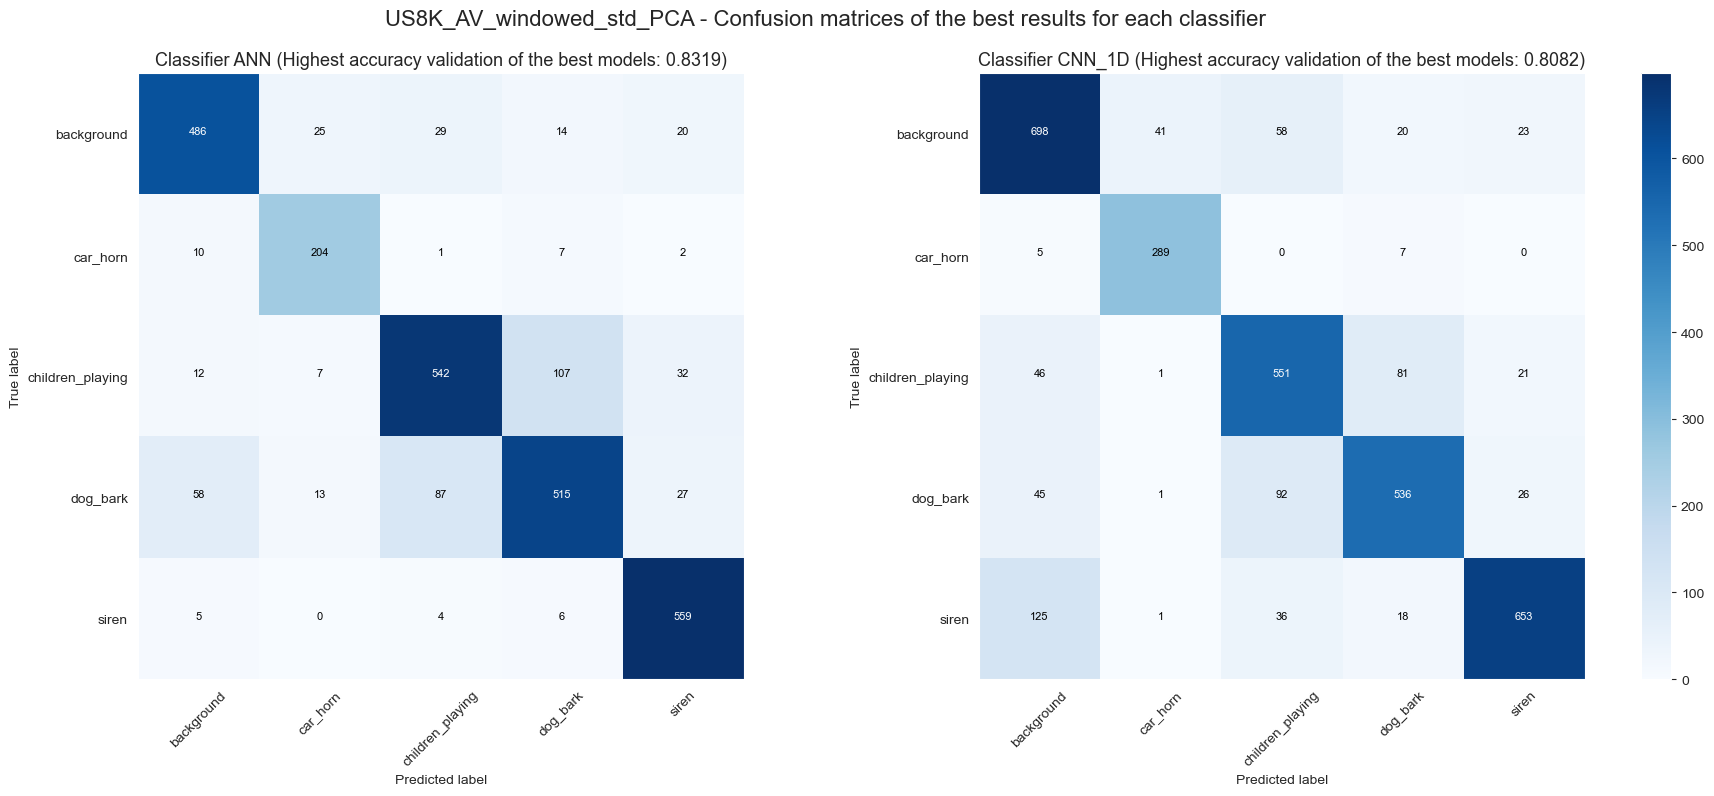

In [129]:
# Plot the confusion matrix for the highest accuracy test classifiers

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

plt.figure(figsize=(20,8))
plt.suptitle(nom_dataset + model_surname + batch_name + ' - Confusion matrices of the best results for each classifier', fontsize = 16,  y=0.99)
for i, idx in zip(conf_matrices_dict.keys(), range(1, len(conf_matrices_dict) + 1)):
    title = 'Classifier '+ i + ' (Highest accuracy validation of the best models: ' + str("{:0.4f}".format(conf_matrices_dict[i]['Accuracy(Val)'])) +')'
    plt.subplot(1,2,idx)
    plot_confusion_matrix(conf_matrices_dict[i]['Conf_M'],  
                          nom_classes, 
                          title,
                          cmap = None,                          
                          normalize = False)

plt.savefig(os.path.join(path_pic, picture_name))
plt.tight_layout()

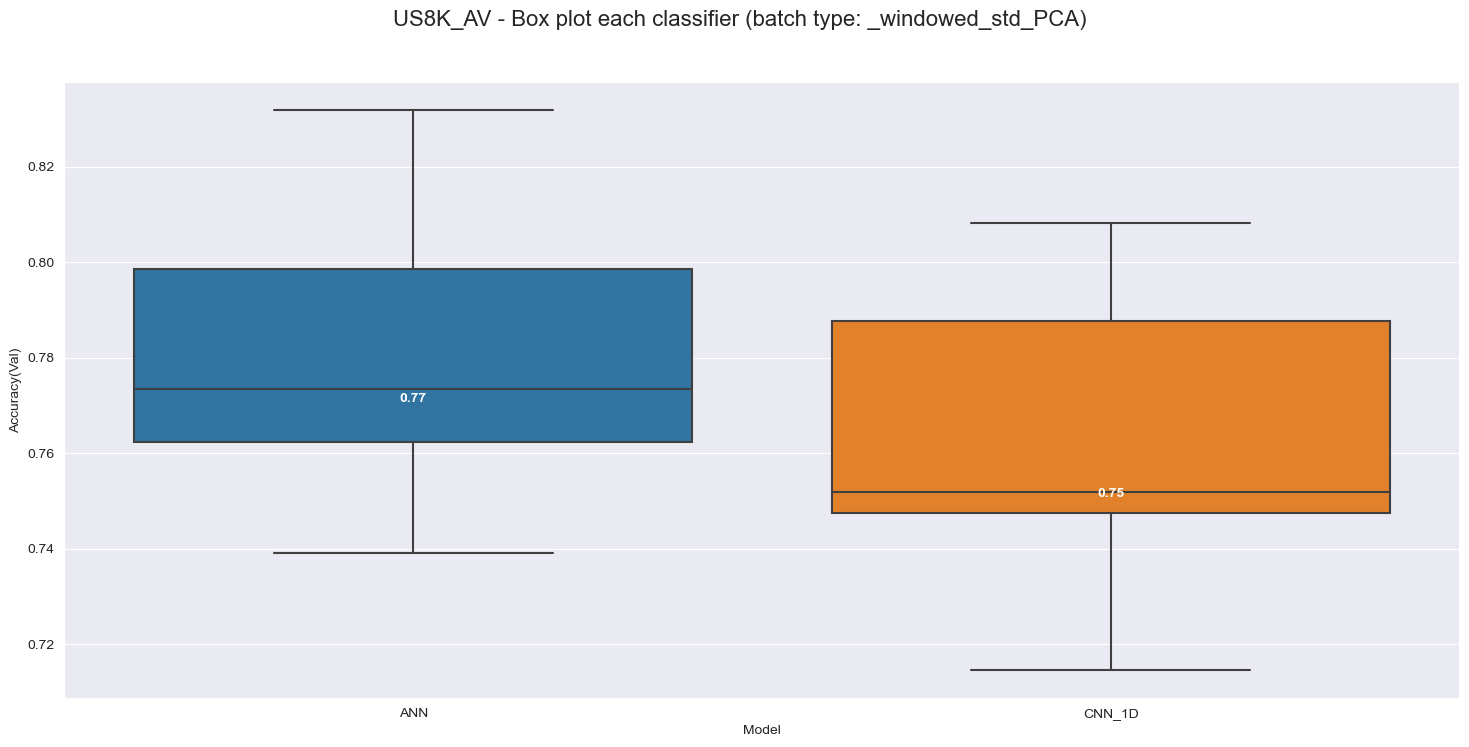

In [130]:
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

plt.figure(figsize=(18,8))
plt.suptitle(f'{nom_dataset} - Box plot each classifier (batch type: {model_surname + batch_name})', fontsize = 16,  y=0.97)
box_plot = sns.boxplot(data=metrics_set, x="Model", y="Accuracy(Val)", showfliers = True)

medians = list(metrics_set.groupby(['Model'])['Accuracy(Val)'].median())
medians = [round(element, 2) for element in medians]

vertical_offset = metrics_set['Accuracy(Val)'].median()*0.001  # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick, medians[xtick] + vertical_offset, medians[xtick], 
            horizontalalignment='center',size='medium',color='w',weight='semibold')
plt.savefig(os.path.join(path_pic, picture_name))

## Results ESC-10

## Results BDLib2

## Results US8K

## Results US8K

# End of the notebook

# 

# 

# 